In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from datetime import datetime
from itertools import product
import math
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling
from random import shuffle
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

## Constantes e funções auxiliares

In [4]:
WEEKDAY_DICT = {
    0: 'monday',
    1: 'tuesday',
    2: 'wednesday',
    3: 'thursday',
    4: 'friday',
    5: 'saturday',
    6: 'sunday',
}

## Pré-processamento

### Abrir arquivo

In [5]:
air_quality_df = pd.read_csv(
    '../data/qualidade_do_ar.csv',
    sep=';'
)

In [37]:
air_quality_df.head()

Date      Time  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
datetime                                                                     
2004-03-10 18:00:00  10/03/2004  18.00.00         1360       150      11.9   
2004-03-10 19:00:00  10/03/2004  19.00.00         1292       112       9.4   
2004-03-10 20:00:00  10/03/2004  20.00.00         1402        88       9.0   
2004-03-10 21:00:00  10/03/2004  21.00.00         1376        80       9.2   
2004-03-10 22:00:00  10/03/2004  22.00.00         1272        51       6.5   

                     PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  \
datetime                                                             
2004-03-10 18:00:00           1046      166          1056      113   
2004-03-10 19:00:00            955      103          1174       92   
2004-03-10 20:00:00            939      131          1140      114   
2004-03-10 21:00:00            948      172          1092      122   
2004-03-10 22:00:00            836      131          1205      116   

                     PT08.S4(NO2)  ...  sin_hour      cos_hour    weekday  \
datetime                           ...                                      
2004-03-10 18:00:00          1692  ... -1.000000 -1.836970e-16  wednesday   
2004-03-10 19:00:00          1559  ... -0.965926  2.588190e-01  wednesday   
2004-03-10 20:00:00          1555  ... -0.866025  5.000000e-01  wednesday   
2004-03-10 21:00:00          1584  ... -0.707107  7.071068e-01  wednesday   
2004-03-10 22:00:00          1490  ... -0.500000  8.660254e-01  wednesday   

                     friday  monday  saturday  sunday thursday  tuesday  \
datetime                                                                  
2004-03-10 18:00:00       0       0         0       0        0        0   
2004-03-10 19:00:00       0       0         0       0        0        0   
2004-03-10 20:00:00       0       0         0       0        0        0   
2004-03-10 21:00:00       0       0         0       0        0        0   
2004-03-10 22:00:00       0       0         0       0        0        0   

                     wednesday  
datetime                        
2004-03-10 18:00:00          1  
2004-03-10 19:00:00          1  
2004-03-10 20:00:00          1  
2004-03-10 21:00:00          1  
2004-03-10 22:00:00          1  

[5 rows x 25 columns]

### Feature engineering

Vamos criar uma coluna do tipo `datetime` a partir dos valores de `Date` e `Time`.

In [6]:
air_quality_df['datetime'] = air_quality_df[['Date', 'Time']].apply(
    lambda x: datetime.strptime('{} {}'.format(x.Date, x.Time), '%d/%m/%Y %H.%M.%S'),
    axis=1
)

Precisamos trocar o `,` por `.` e transformar os valores das colunas `C6H6(GT)`, `T`, `RH` e `AH` de texto para número com ponto flutuante.

In [7]:
for col in ['C6H6(GT)', 'T', 'RH', 'AH']:
    air_quality_df[col] = air_quality_df[col].apply(lambda x: float(x.replace(',', '.')))

In [8]:
air_quality_df.head()

Date      Time  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  \
0  10/03/2004  18.00.00         1360       150      11.9           1046   
1  10/03/2004  19.00.00         1292       112       9.4            955   
2  10/03/2004  20.00.00         1402        88       9.0            939   
3  10/03/2004  21.00.00         1376        80       9.2            948   
4  10/03/2004  22.00.00         1272        51       6.5            836   

   NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH  \
0      166          1056      113          1692         1268  13.6  48.9   
1      103          1174       92          1559          972  13.3  47.7   
2      131          1140      114          1555         1074  11.9  54.0   
3      172          1092      122          1584         1203  11.0  60.0   
4      131          1205      116          1490         1110  11.2  59.6   

       AH            datetime  
0  0.7578 2004-03-10 18:00:00  
1  0.7255 2004-03-10 19:00:00  
2  0.7502 2004-03-10 20:00:00  
3  0.7867 2004-03-10 21:00:00  
4  0.7888 2004-03-10 22:00:00

In [11]:
air_quality_df = air_quality_df.set_index('datetime')

Vamos criar uma variável com a hora do dia em que as medições foram tomadas (`hour`) e transformá-la em duas variáveis senoidais (`sin_hour` e `cos_hour`), para dar conta de sua natureza cíclica (i.e. 0h vem logo depois das 23h e assim por diante).

In [12]:
air_quality_df['hour'] = air_quality_df['Time'].apply(lambda x: x.split('.')[0] if x is not None else x)

In [13]:
air_quality_df['hour'] = air_quality_df['hour'].astype(int)

In [14]:
HOURS_IN_A_DAY = 24
air_quality_df['sin_hour'] = np.sin(2 * np.pi * air_quality_df['hour'] / HOURS_IN_A_DAY)
air_quality_df['cos_hour'] = np.cos(2 * np.pi * air_quality_df['hour'] / HOURS_IN_A_DAY)

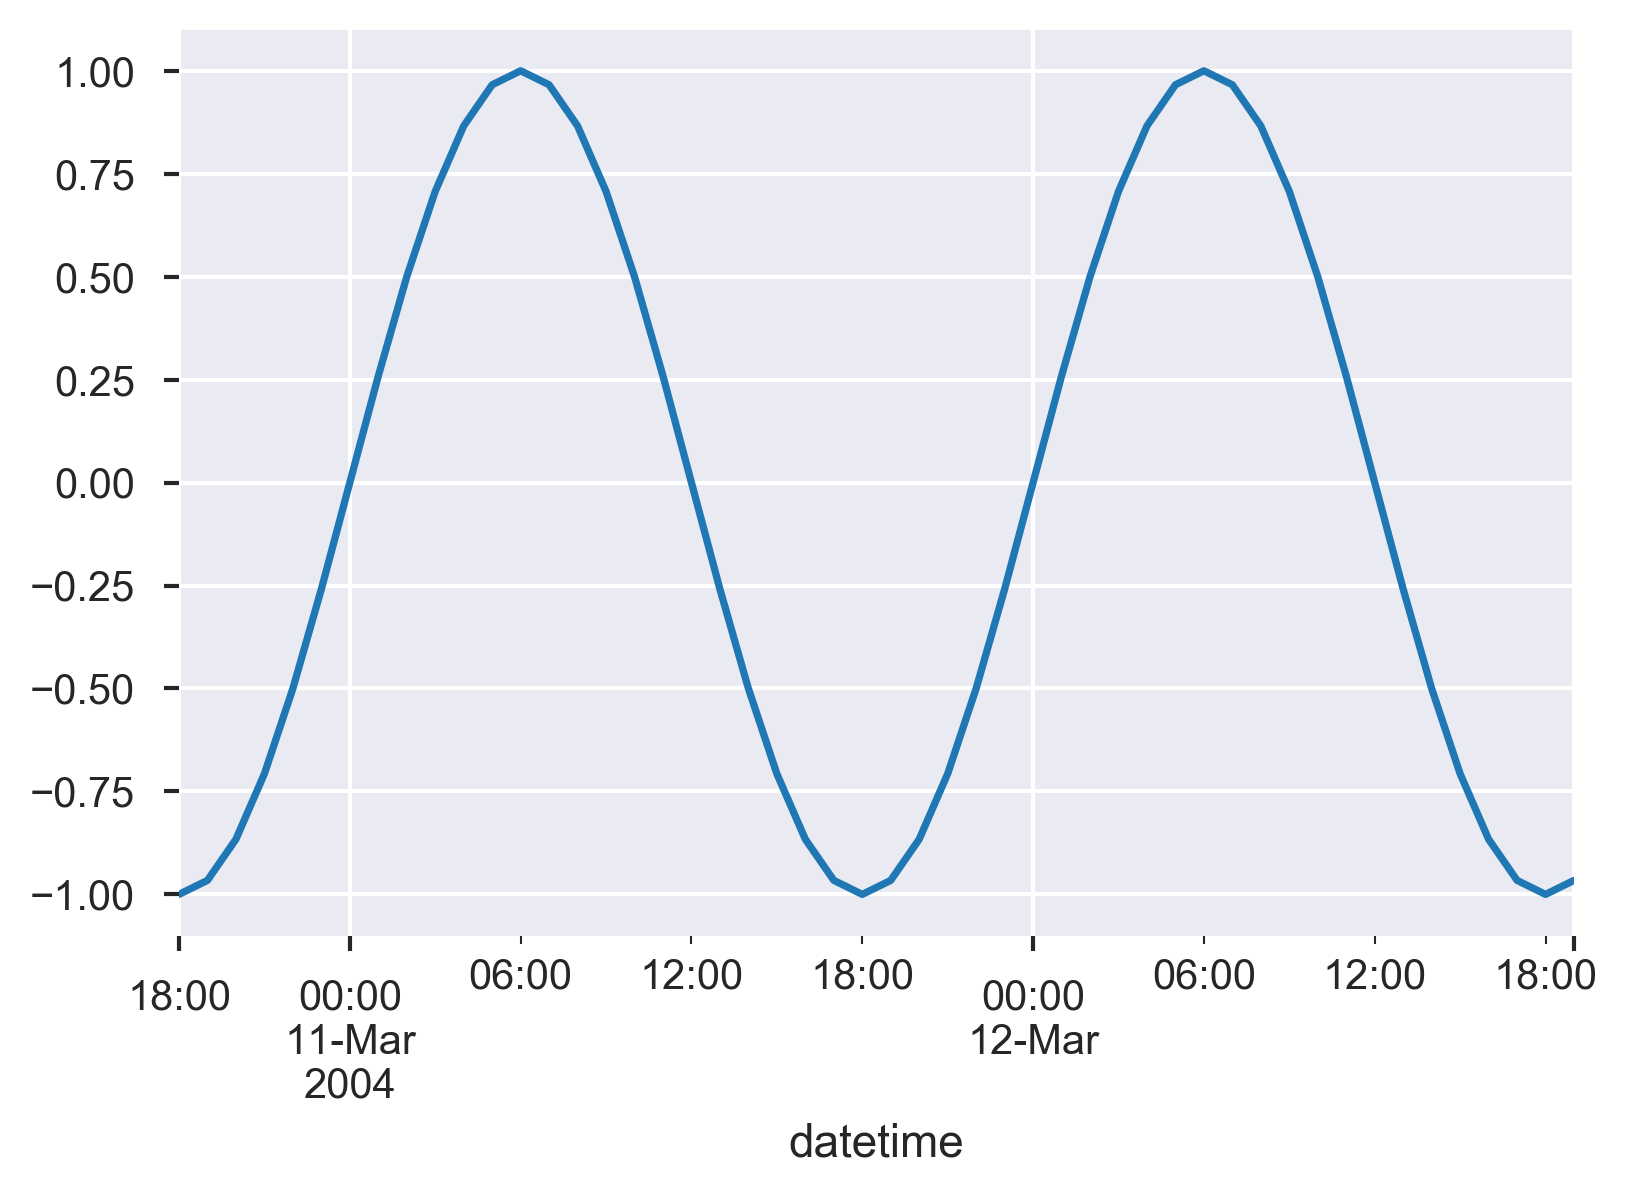

In [28]:
air_quality_df['sin_hour'].iloc[:50].plot();

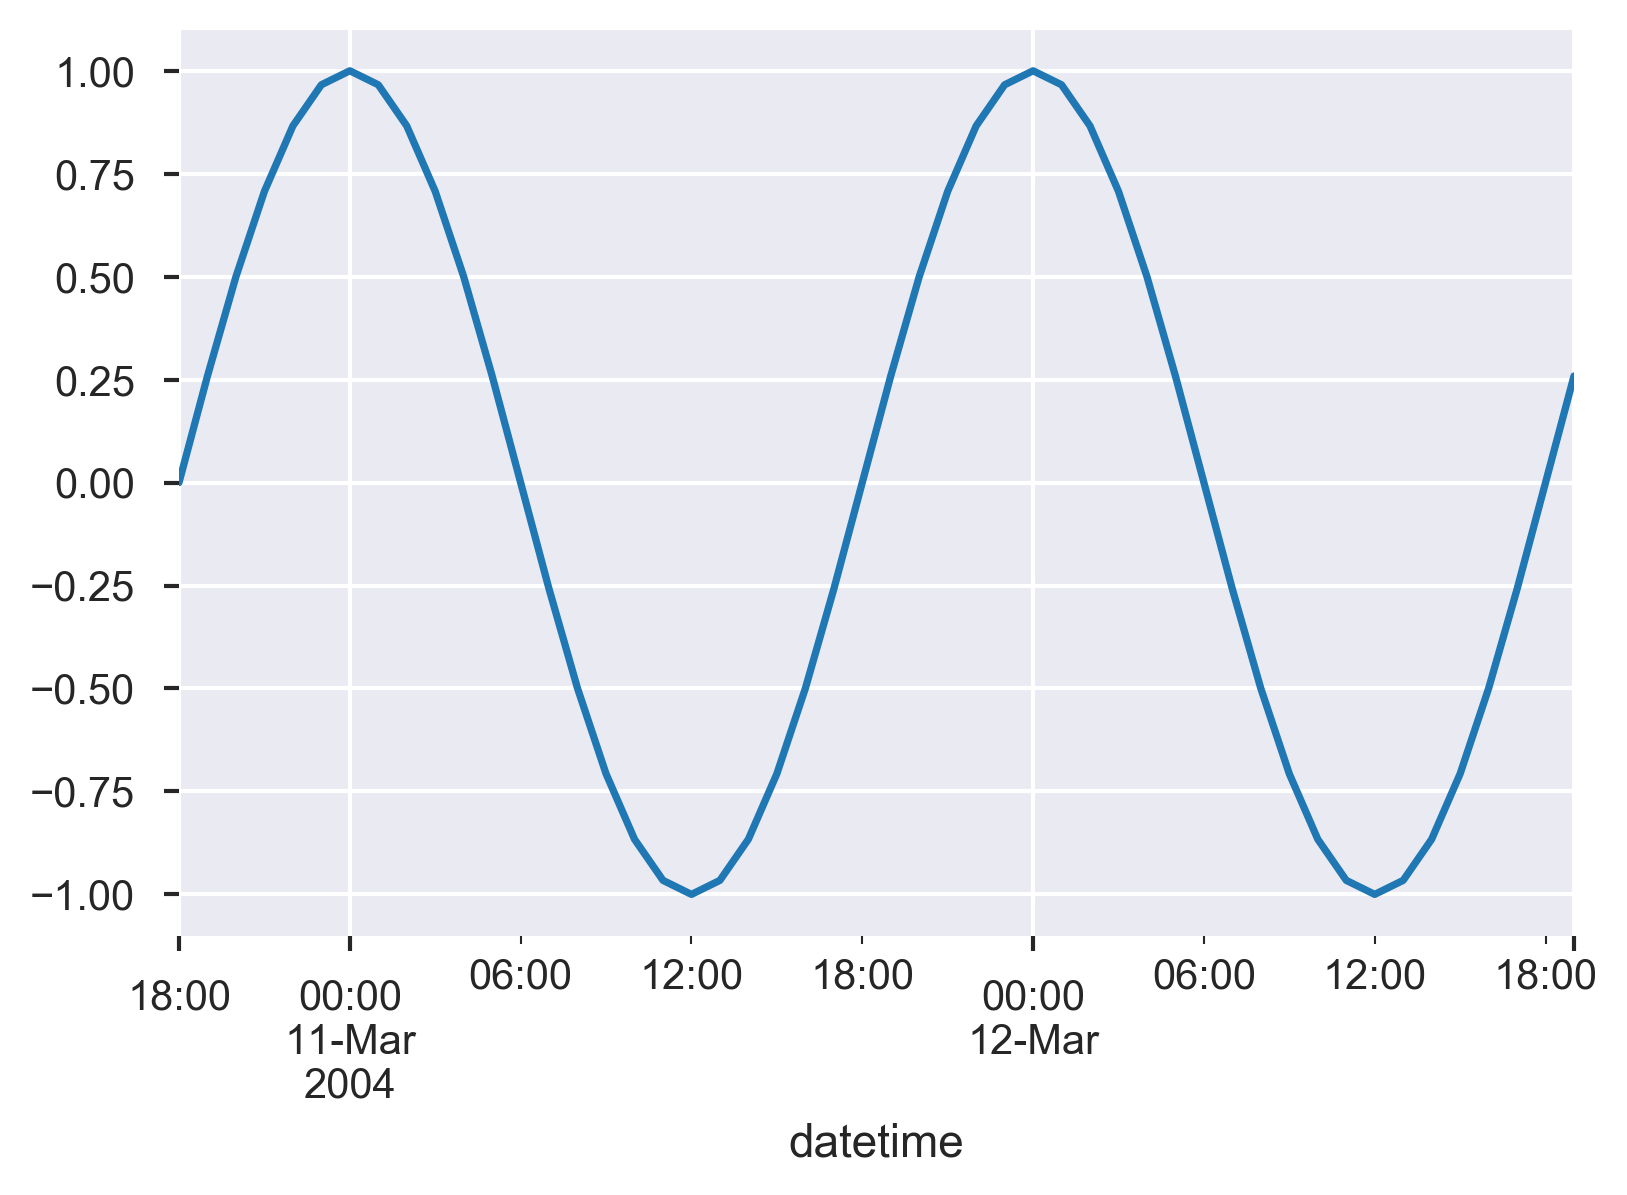

In [29]:
air_quality_df['cos_hour'].iloc[:50].plot();

Agora vamos criar uma variável que armazene o dia da semana em que as medições foram tomadas (`weekday`) e depois criar colunas de *one hot encoding* para categorizar essa informação de forma binária.

In [30]:
air_quality_df['weekday'] = air_quality_df.index.map(lambda x: WEEKDAY_DICT[x.weekday()])

In [31]:
air_quality_df = pd.concat([air_quality_df, pd.get_dummies(air_quality_df['weekday'])], axis=1)

In [32]:
air_quality_df[
    [
        'Date', 'Time', 'PT08.S1(CO)', 
        'monday', 'tuesday', 'wednesday', 'thursday', 
        'friday', 'saturday', 'sunday'
    ]
].head()

Date      Time  PT08.S1(CO)  monday  tuesday  \
datetime                                                                  
2004-03-10 18:00:00  10/03/2004  18.00.00         1360       0        0   
2004-03-10 19:00:00  10/03/2004  19.00.00         1292       0        0   
2004-03-10 20:00:00  10/03/2004  20.00.00         1402       0        0   
2004-03-10 21:00:00  10/03/2004  21.00.00         1376       0        0   
2004-03-10 22:00:00  10/03/2004  22.00.00         1272       0        0   

                     wednesday  thursday  friday  saturday  sunday  
datetime                                                            
2004-03-10 18:00:00          1         0       0         0       0  
2004-03-10 19:00:00          1         0       0         0       0  
2004-03-10 20:00:00          1         0       0         0       0  
2004-03-10 21:00:00          1         0       0         0       0  
2004-03-10 22:00:00          1         0       0         0       0

## Análise exploratória de dados

### Dados faltantes

Como o valor `-200` representa valores faltantes, vamos ver quantas medições faltantes cada coluna numérica tem.

In [9]:
numeric_columns = [
    'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
    'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
    'T', 'RH', 'AH',
]

In [10]:
for col in numeric_columns:
    print(col, ':', air_quality_df[col].value_counts()[-200])

PT08.S1(CO) : 366
NMHC(GT) : 8443
C6H6(GT) : 366
PT08.S2(NMHC) : 366
NOx(GT) : 1639
PT08.S3(NOx) : 366
NO2(GT) : 1642
PT08.S4(NO2) : 366
PT08.S5(O3) : 366
T : 366
RH : 366
AH : 366


Notamos que 366 linhas da tabela não têm valor definido na coluna `PT08.S1(CO)`, que é a nossa variável de predição. Com isso, vamos ter que eliminar essas linhas do nosso conjunto de dados.

In [69]:
air_quality_df = air_quality_df[air_quality_df['PT08.S1(CO)'] > -200]

In [70]:
air_quality_df.shape

(8991, 26)

Além disso, vemos que a coluna `NMHC(GT)` tem mais de 90% de valores indefinidos, por isso vamos descartá-la como parâmetro do nosso modelo.

In [416]:
air_quality_df[air_quality_df['NMHC(GT)'] == -200].shape[0] / air_quality_df.shape[0]

0.9013457902346791

Finalmente, como as colunas `NO2(GT)` e `NOx(GT)` apresentam cerca de 17% de valores faltantes, vamos preenchê-las com o valor médio de cada coluna para os algoritmos que não conseguirem lidar com valores faltantes.

### Outliers

Vamos procurar por outliers nas variáveis individualmente (começando pela de predição) utilizando boxplots:

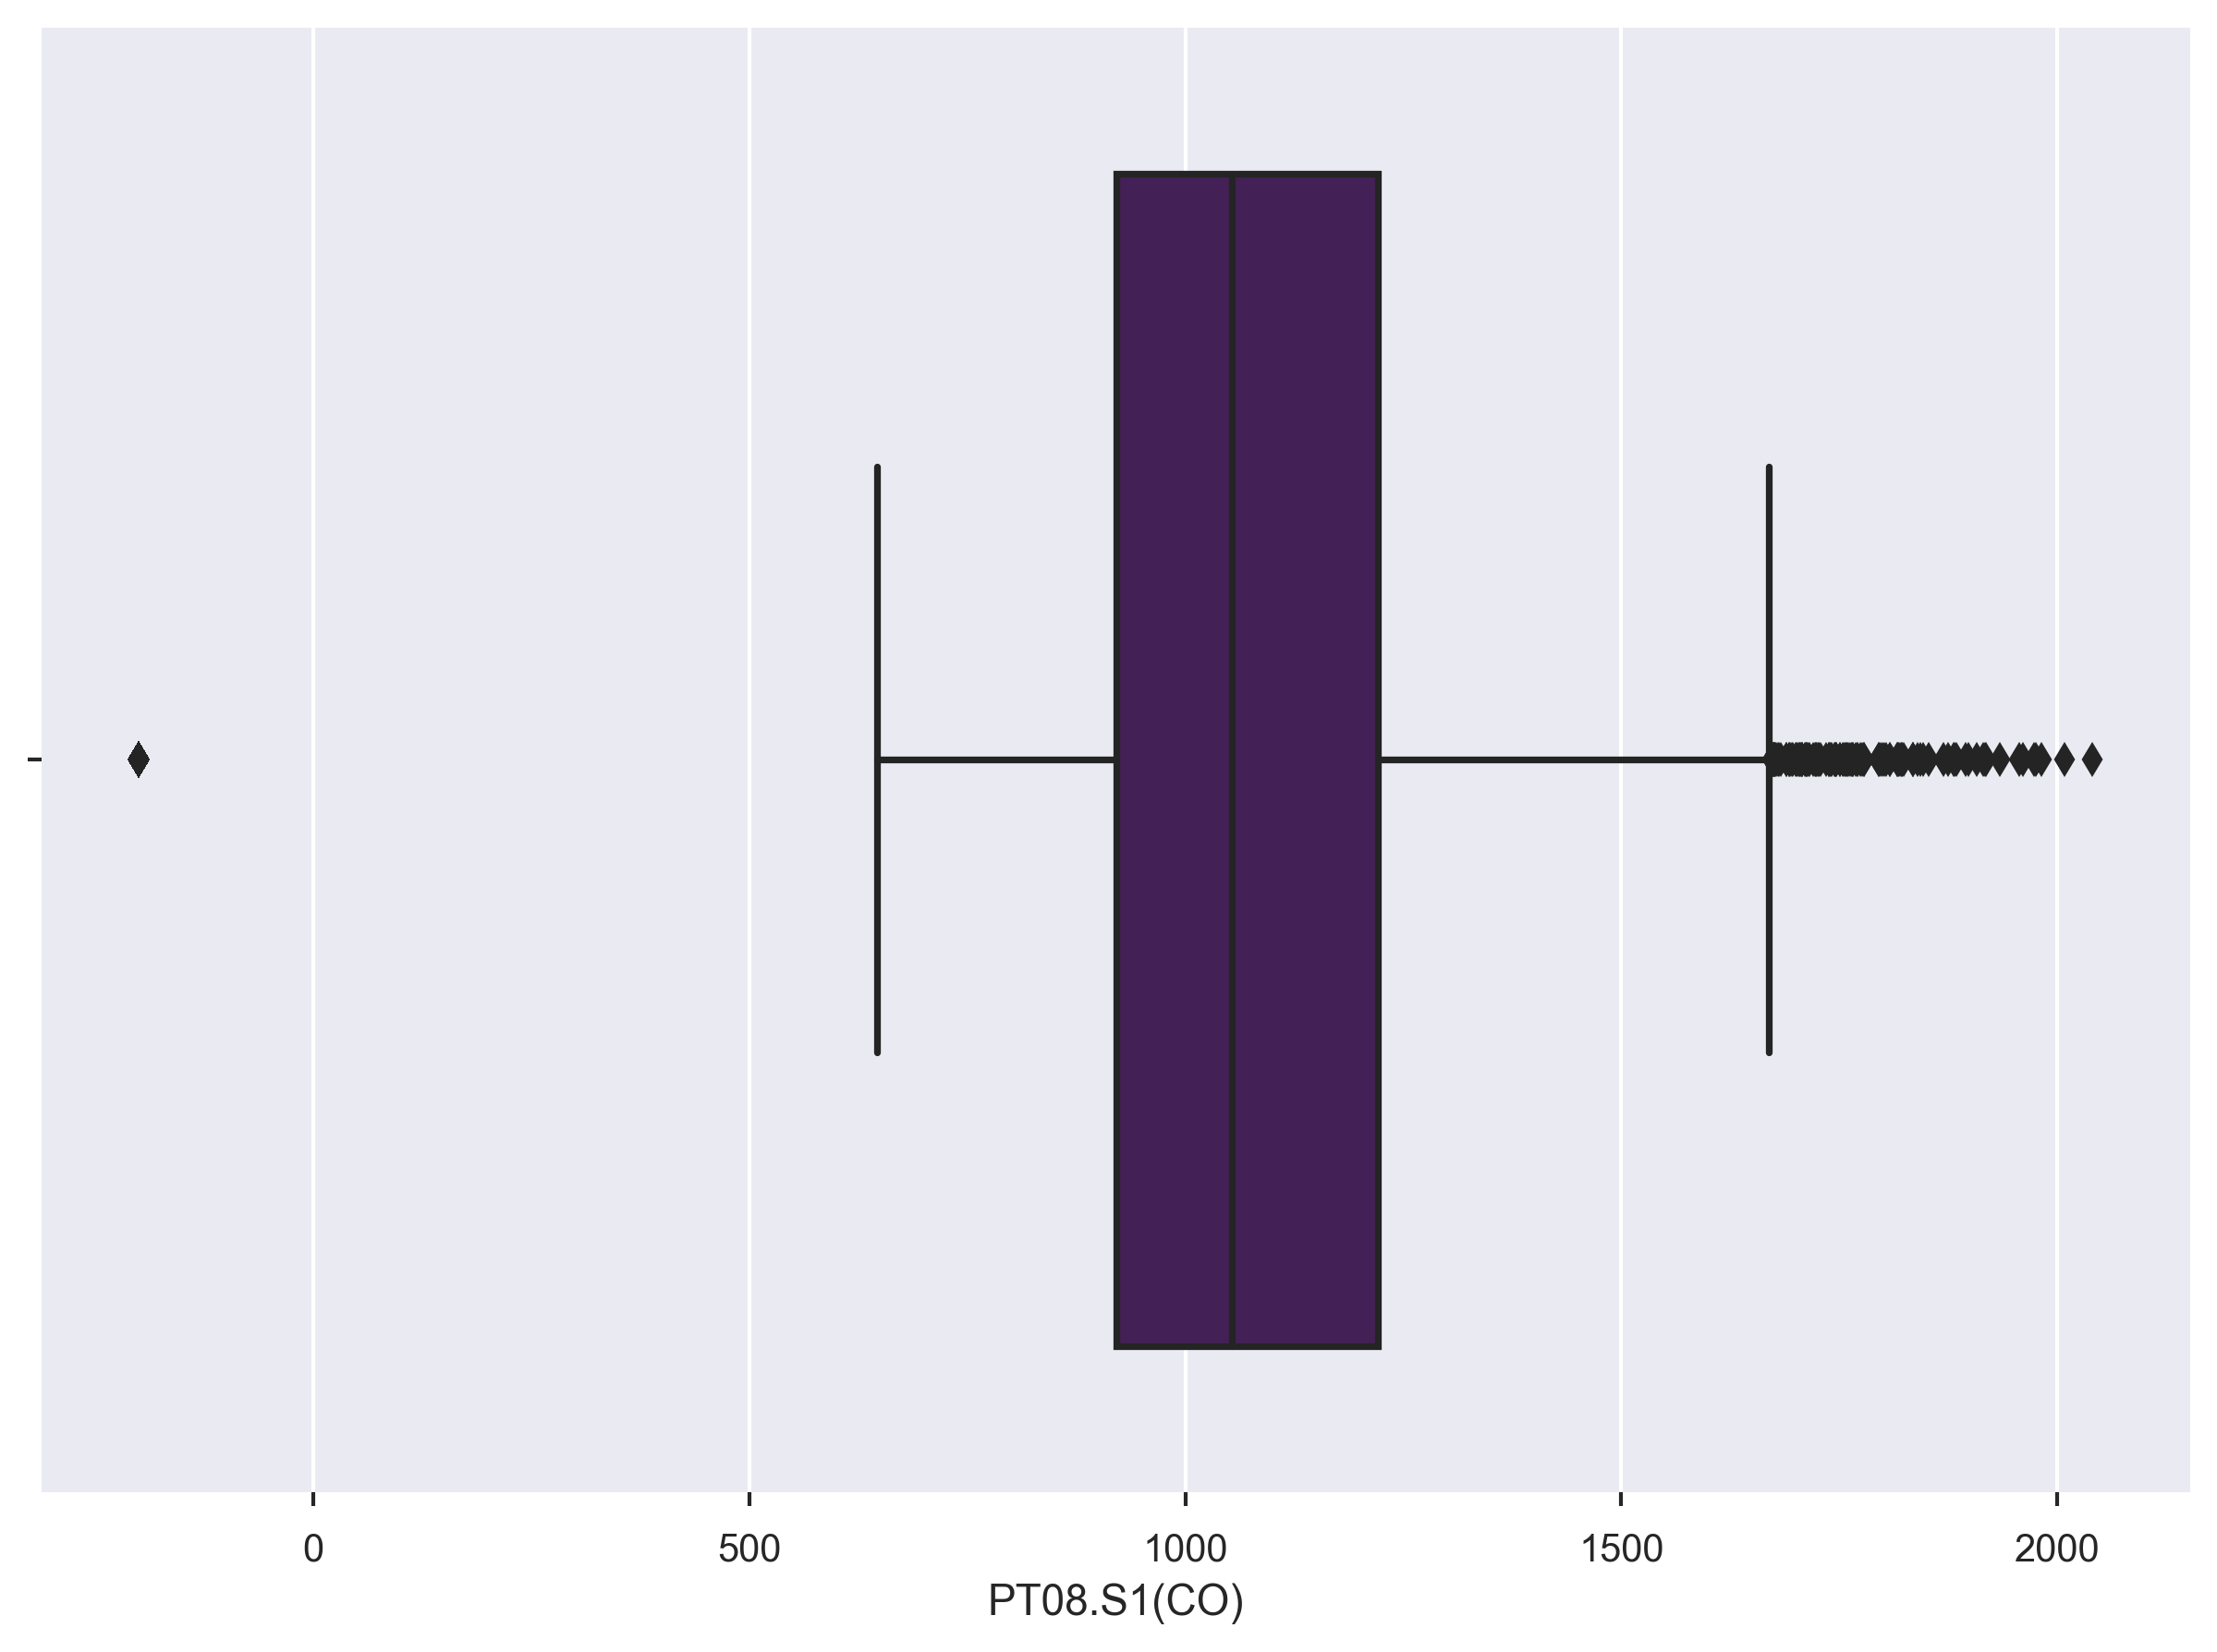

In [39]:
plt.figure(figsize=(10, 7))
sns.boxplot(air_quality_df['PT08.S1(CO)'], color='#46185f')
plt.show()

In [40]:
NUMERIC_FEATURES = [
    'C6H6(GT)',
    'PT08.S2(NMHC)',
    'NOx(GT)',
    'PT08.S3(NOx)',
    'NO2(GT)',
    'PT08.S4(NO2)',
    'PT08.S5(O3)',
    'T',
    'RH',
    'AH',
]

In [41]:
colors = [
    '#f67280',
    '#c06c84',
    '#6c5b7b',
    '#35477d'
] * 5

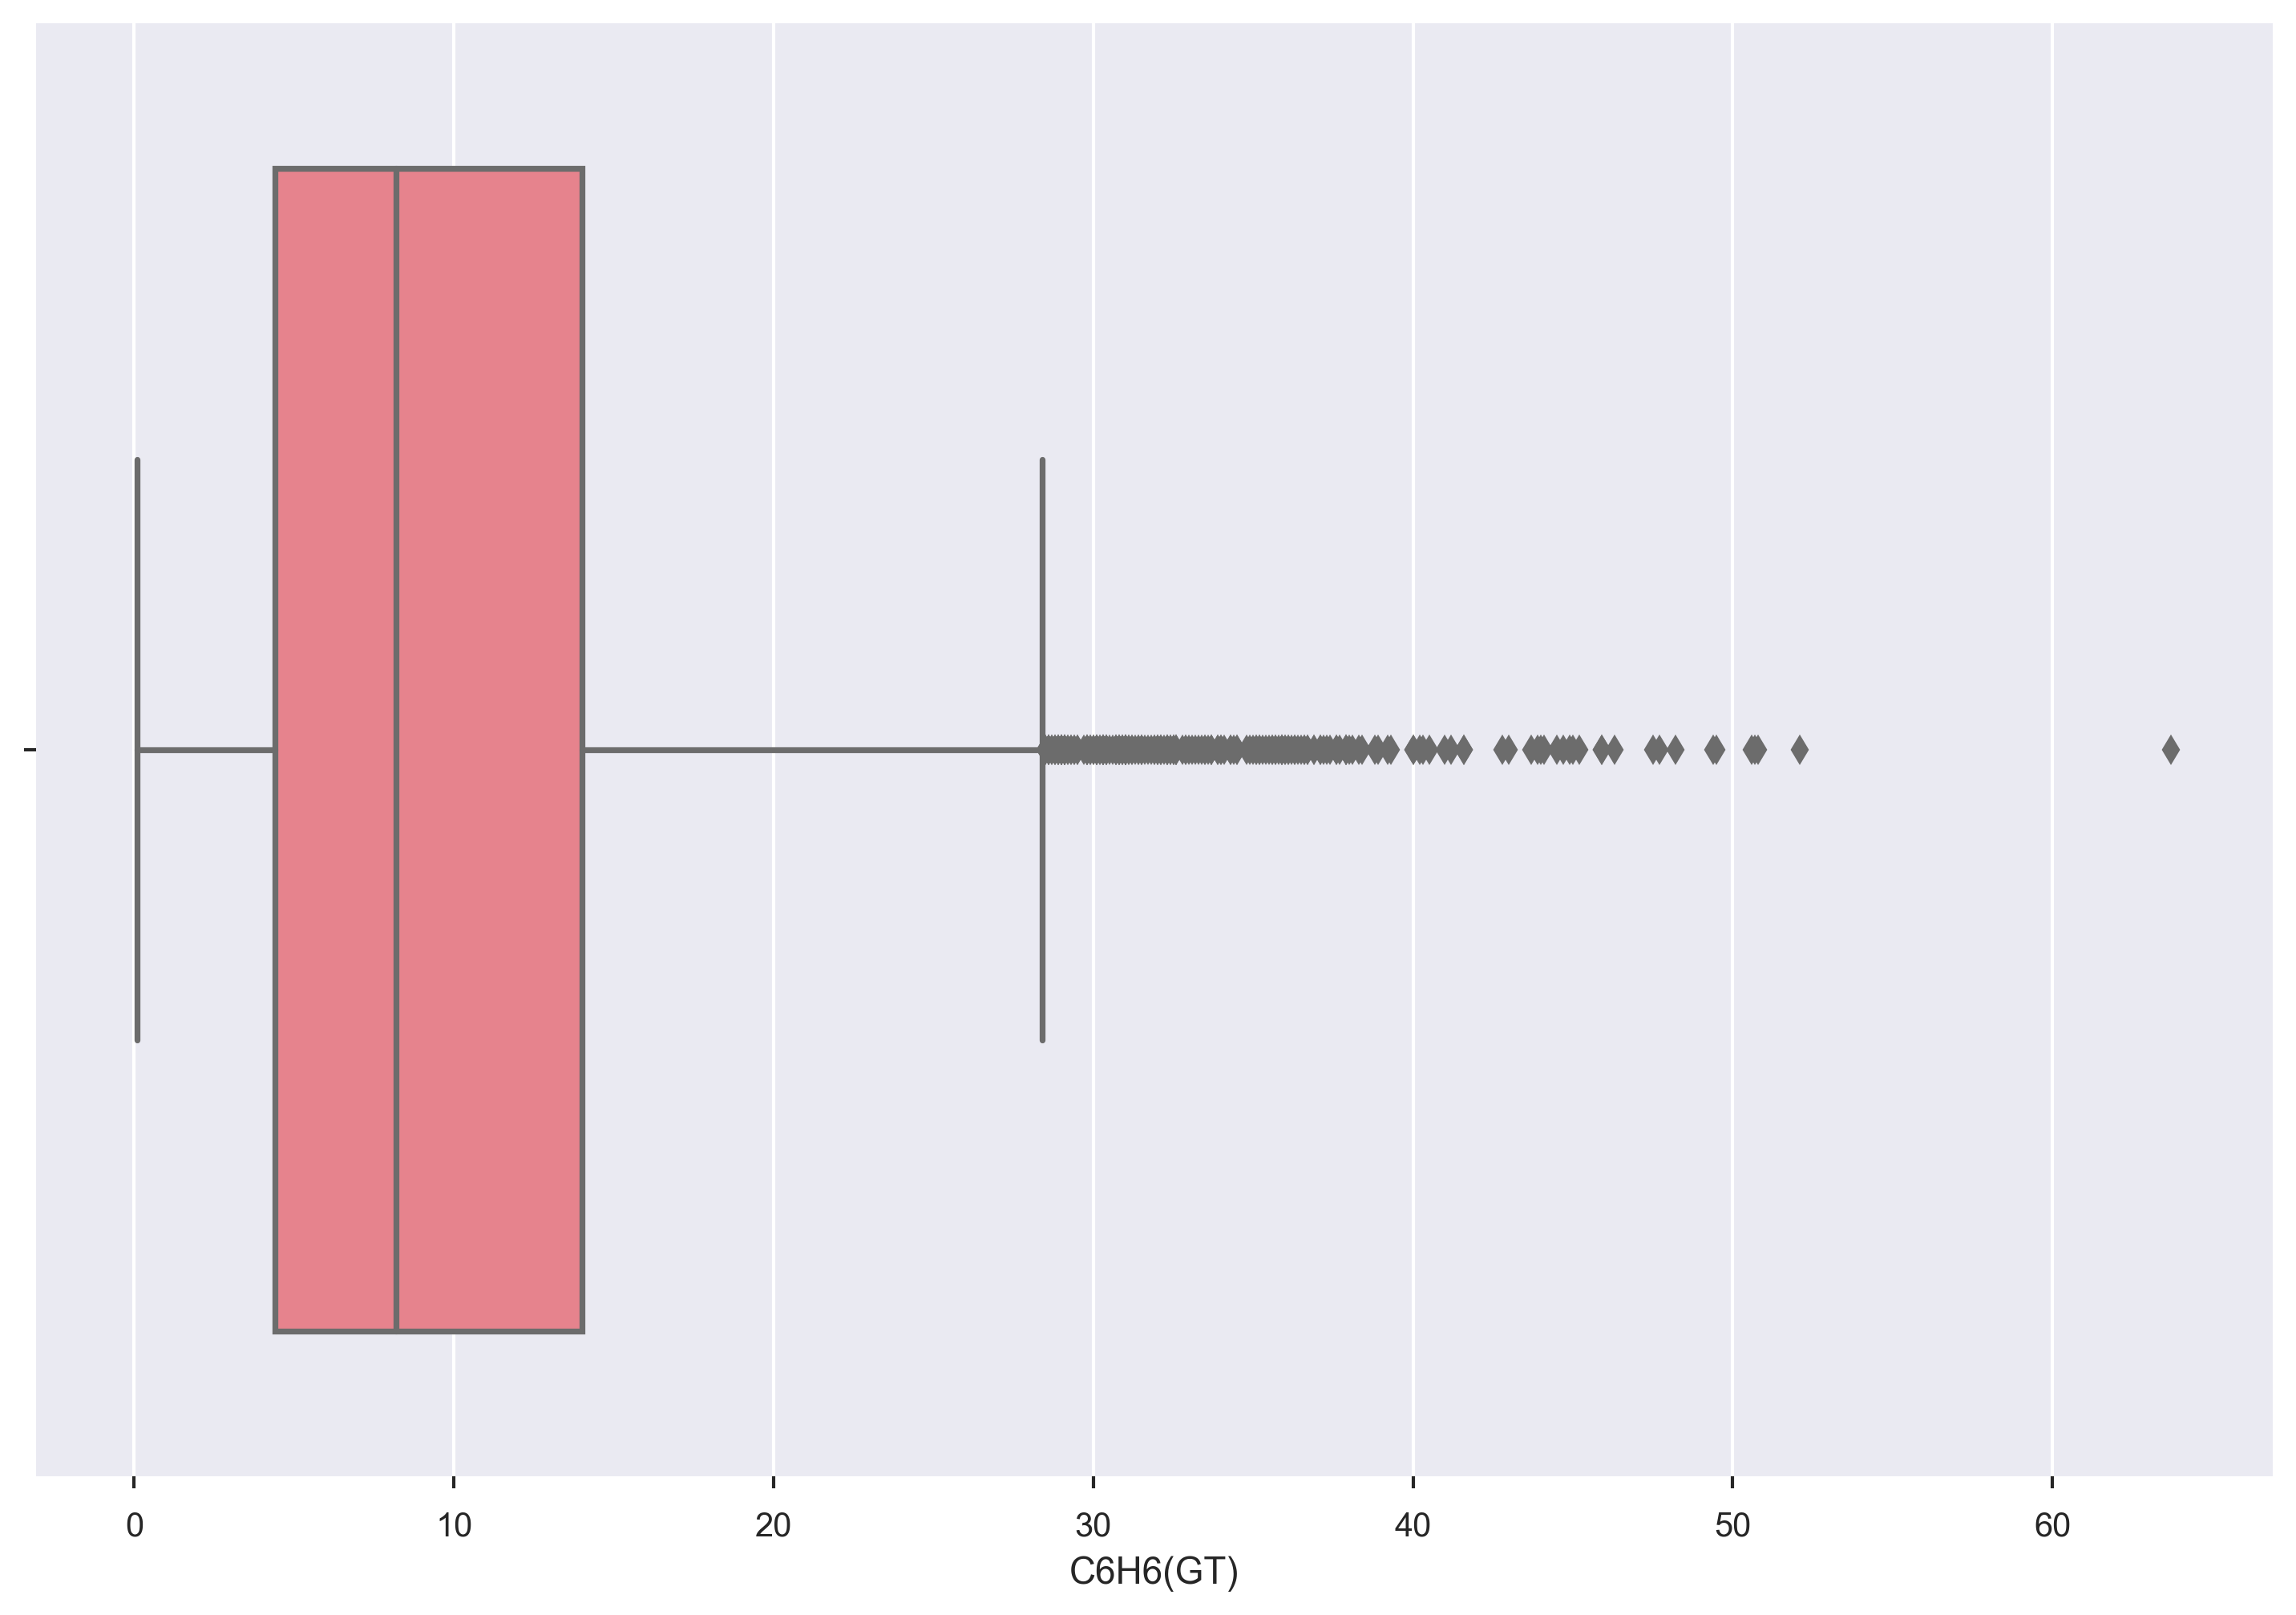

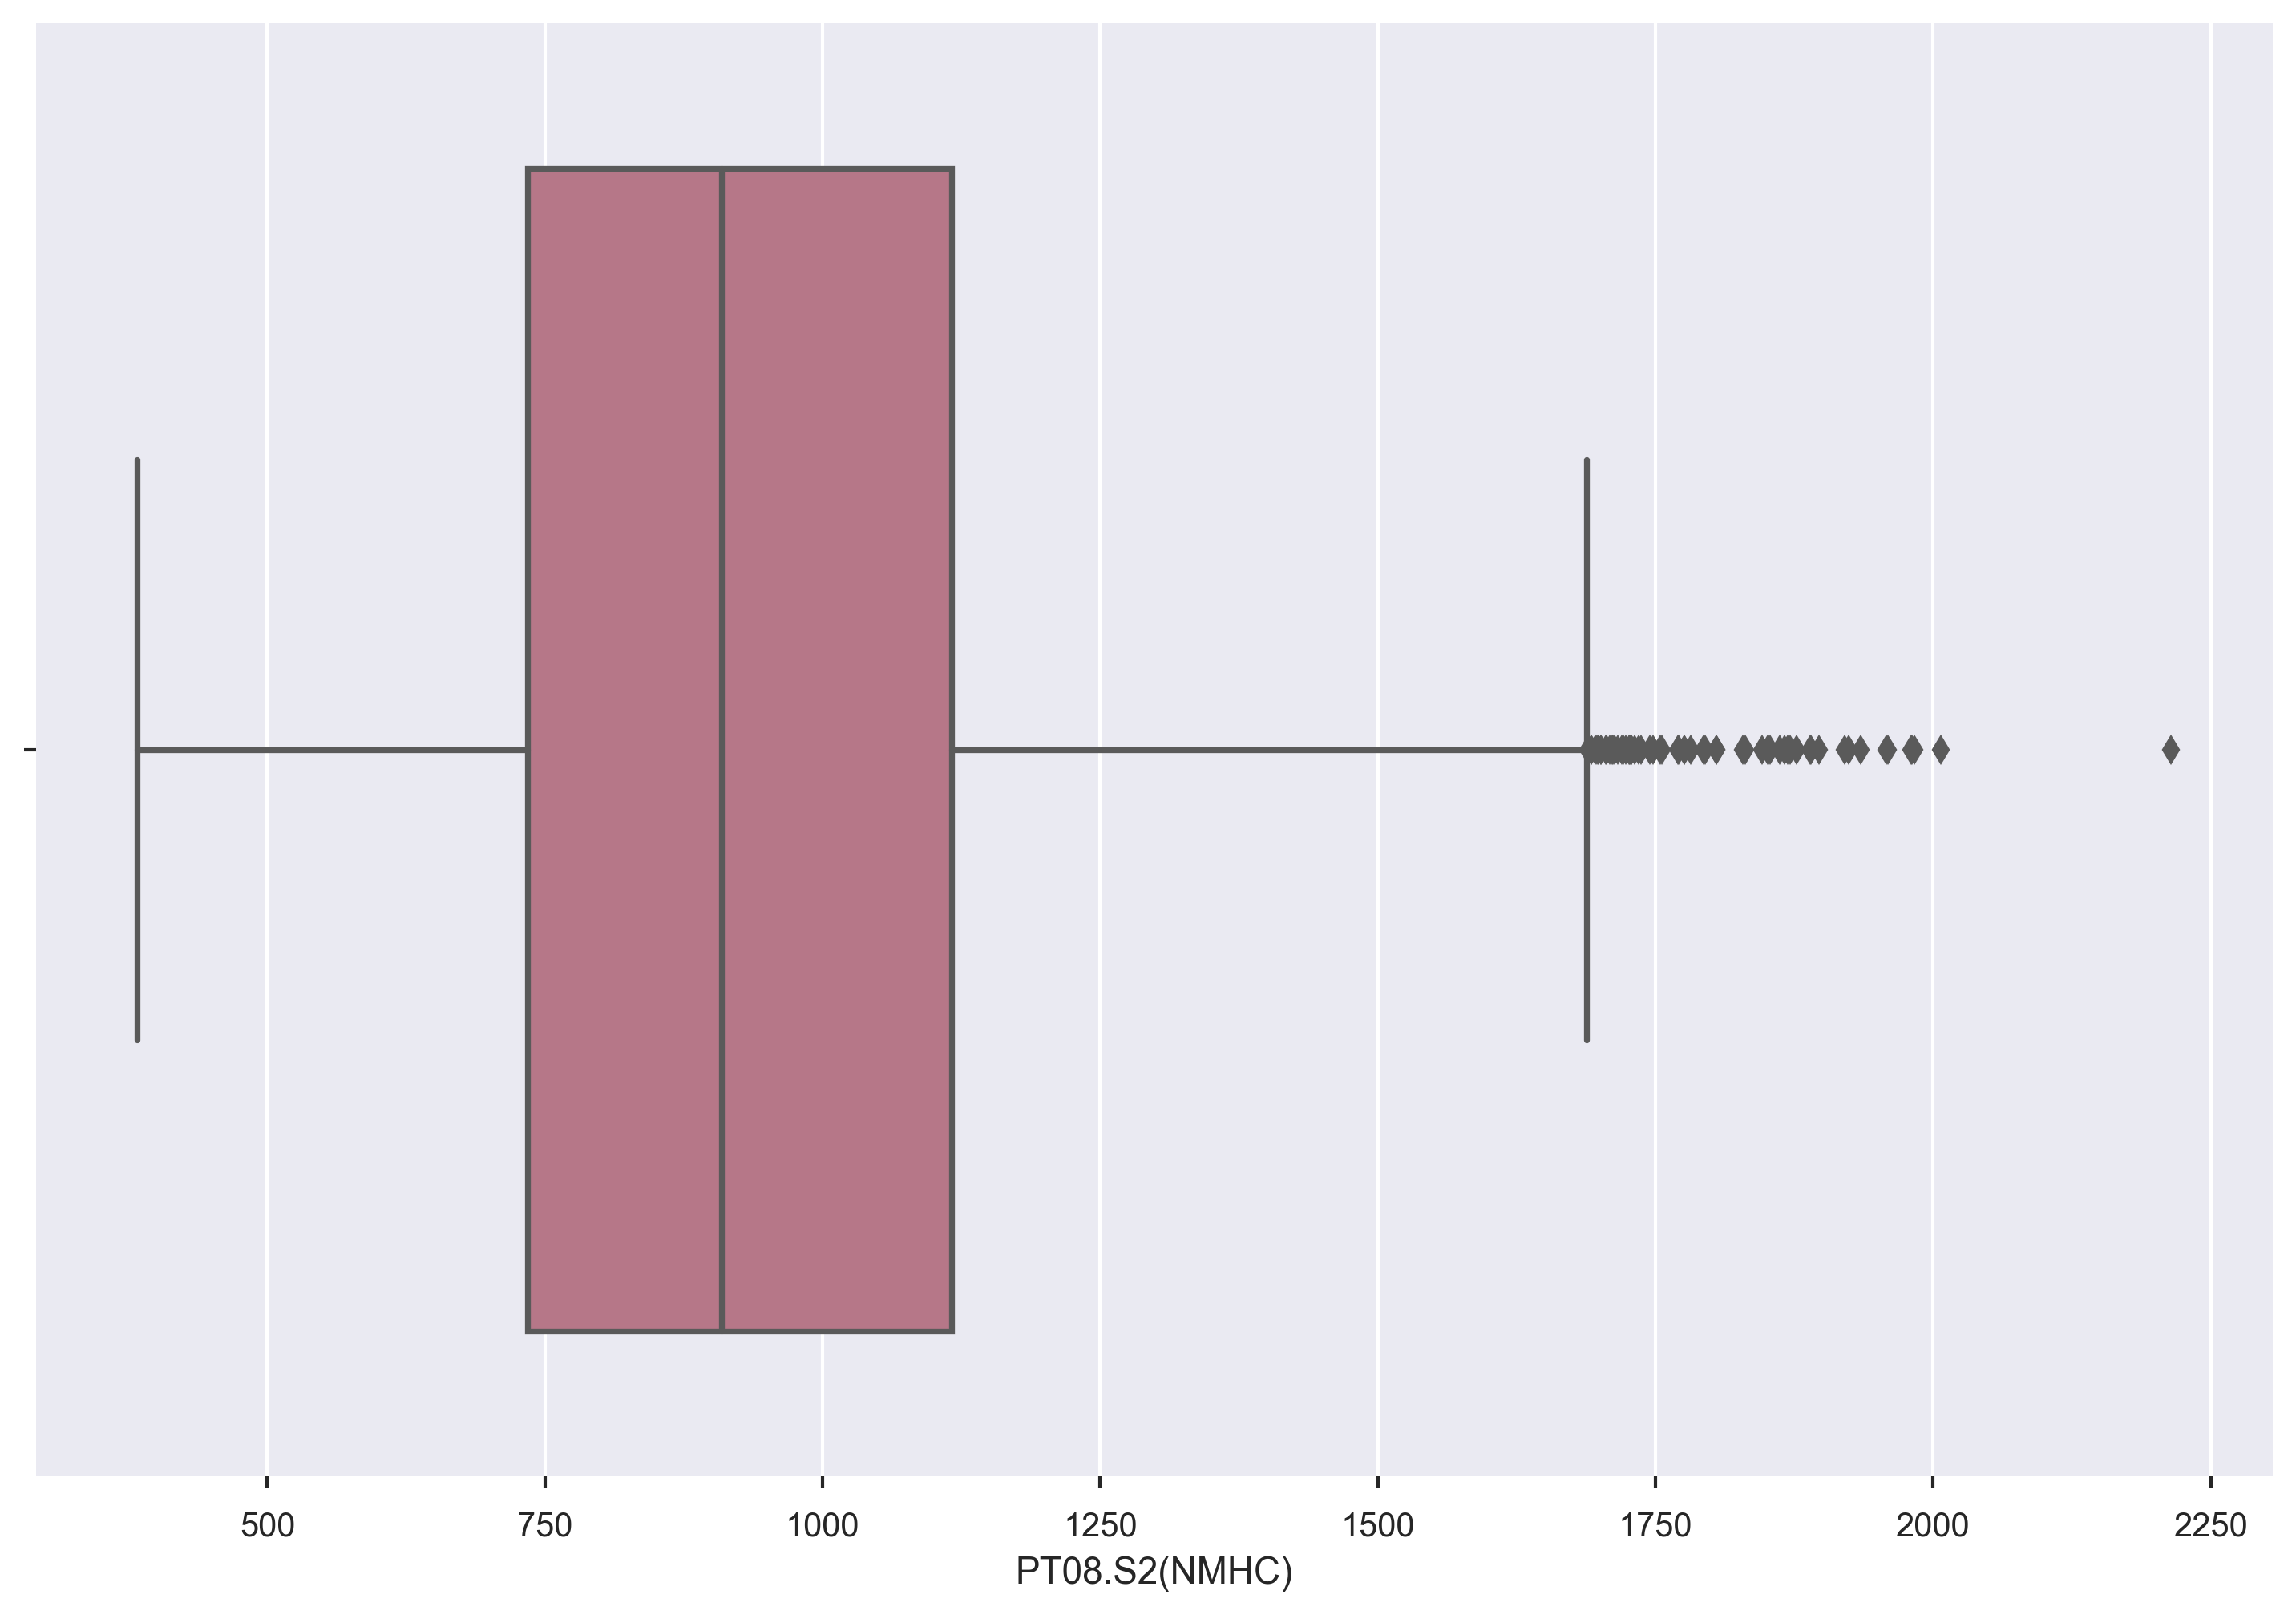

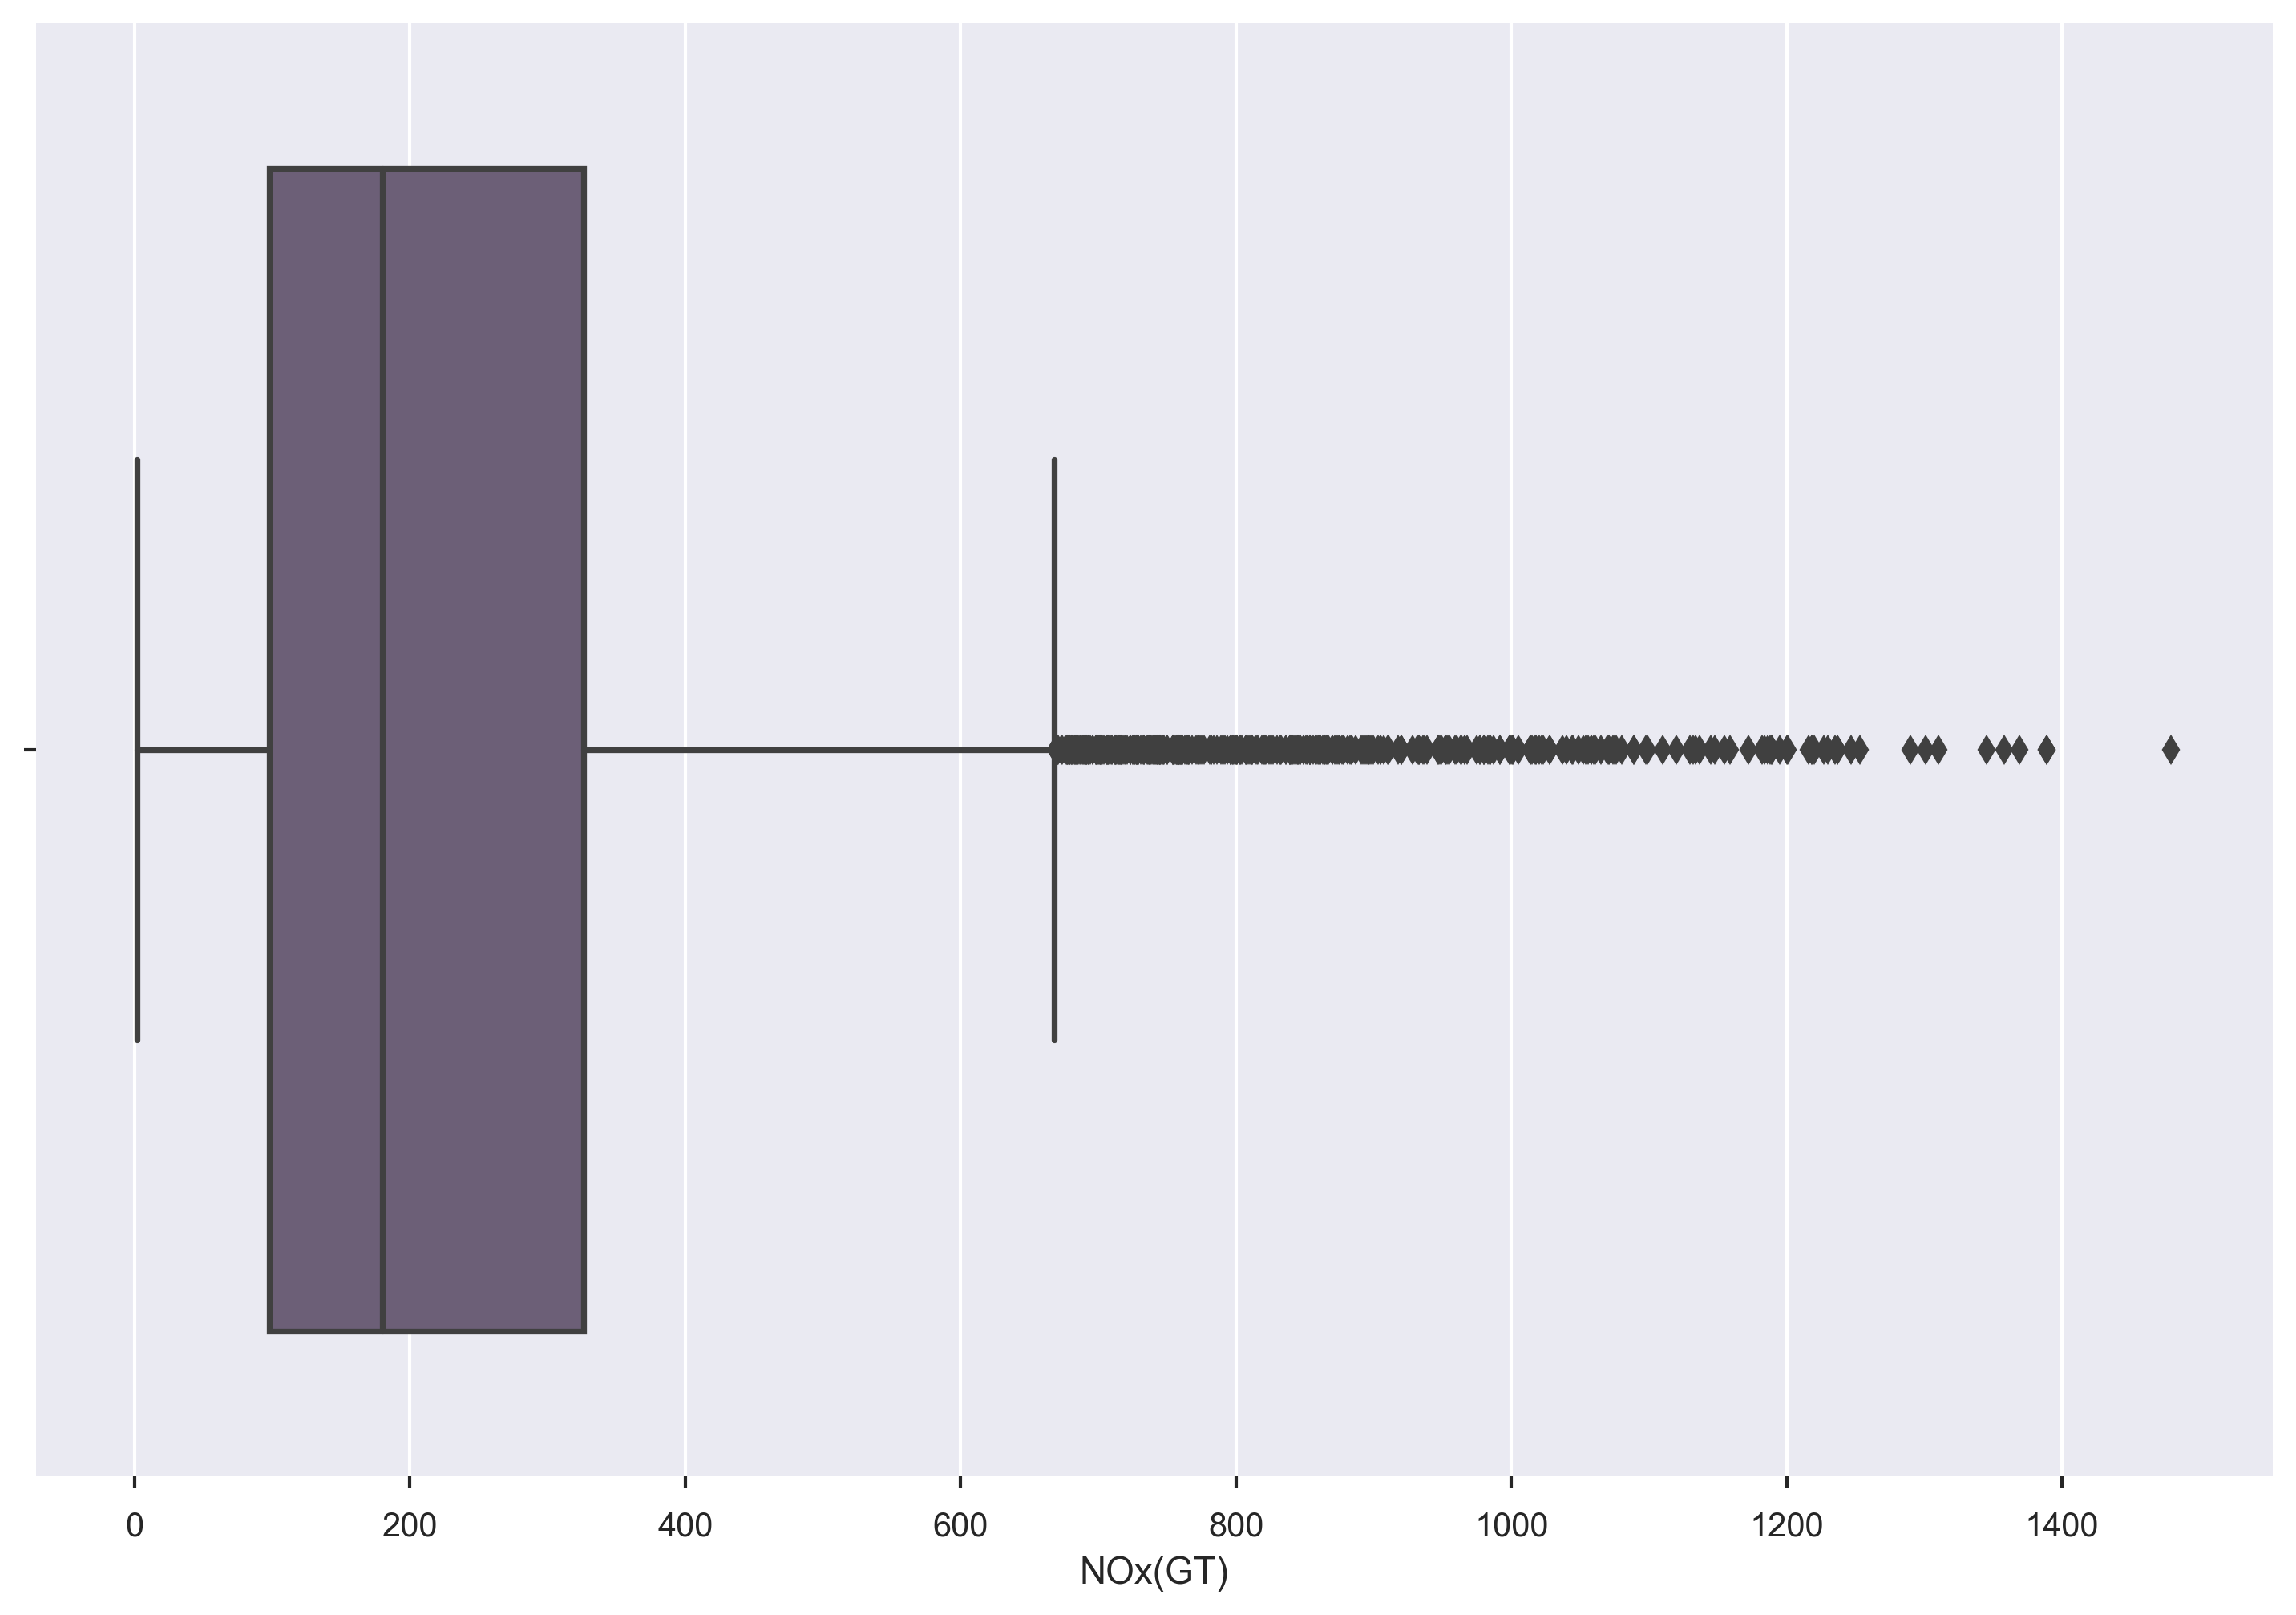

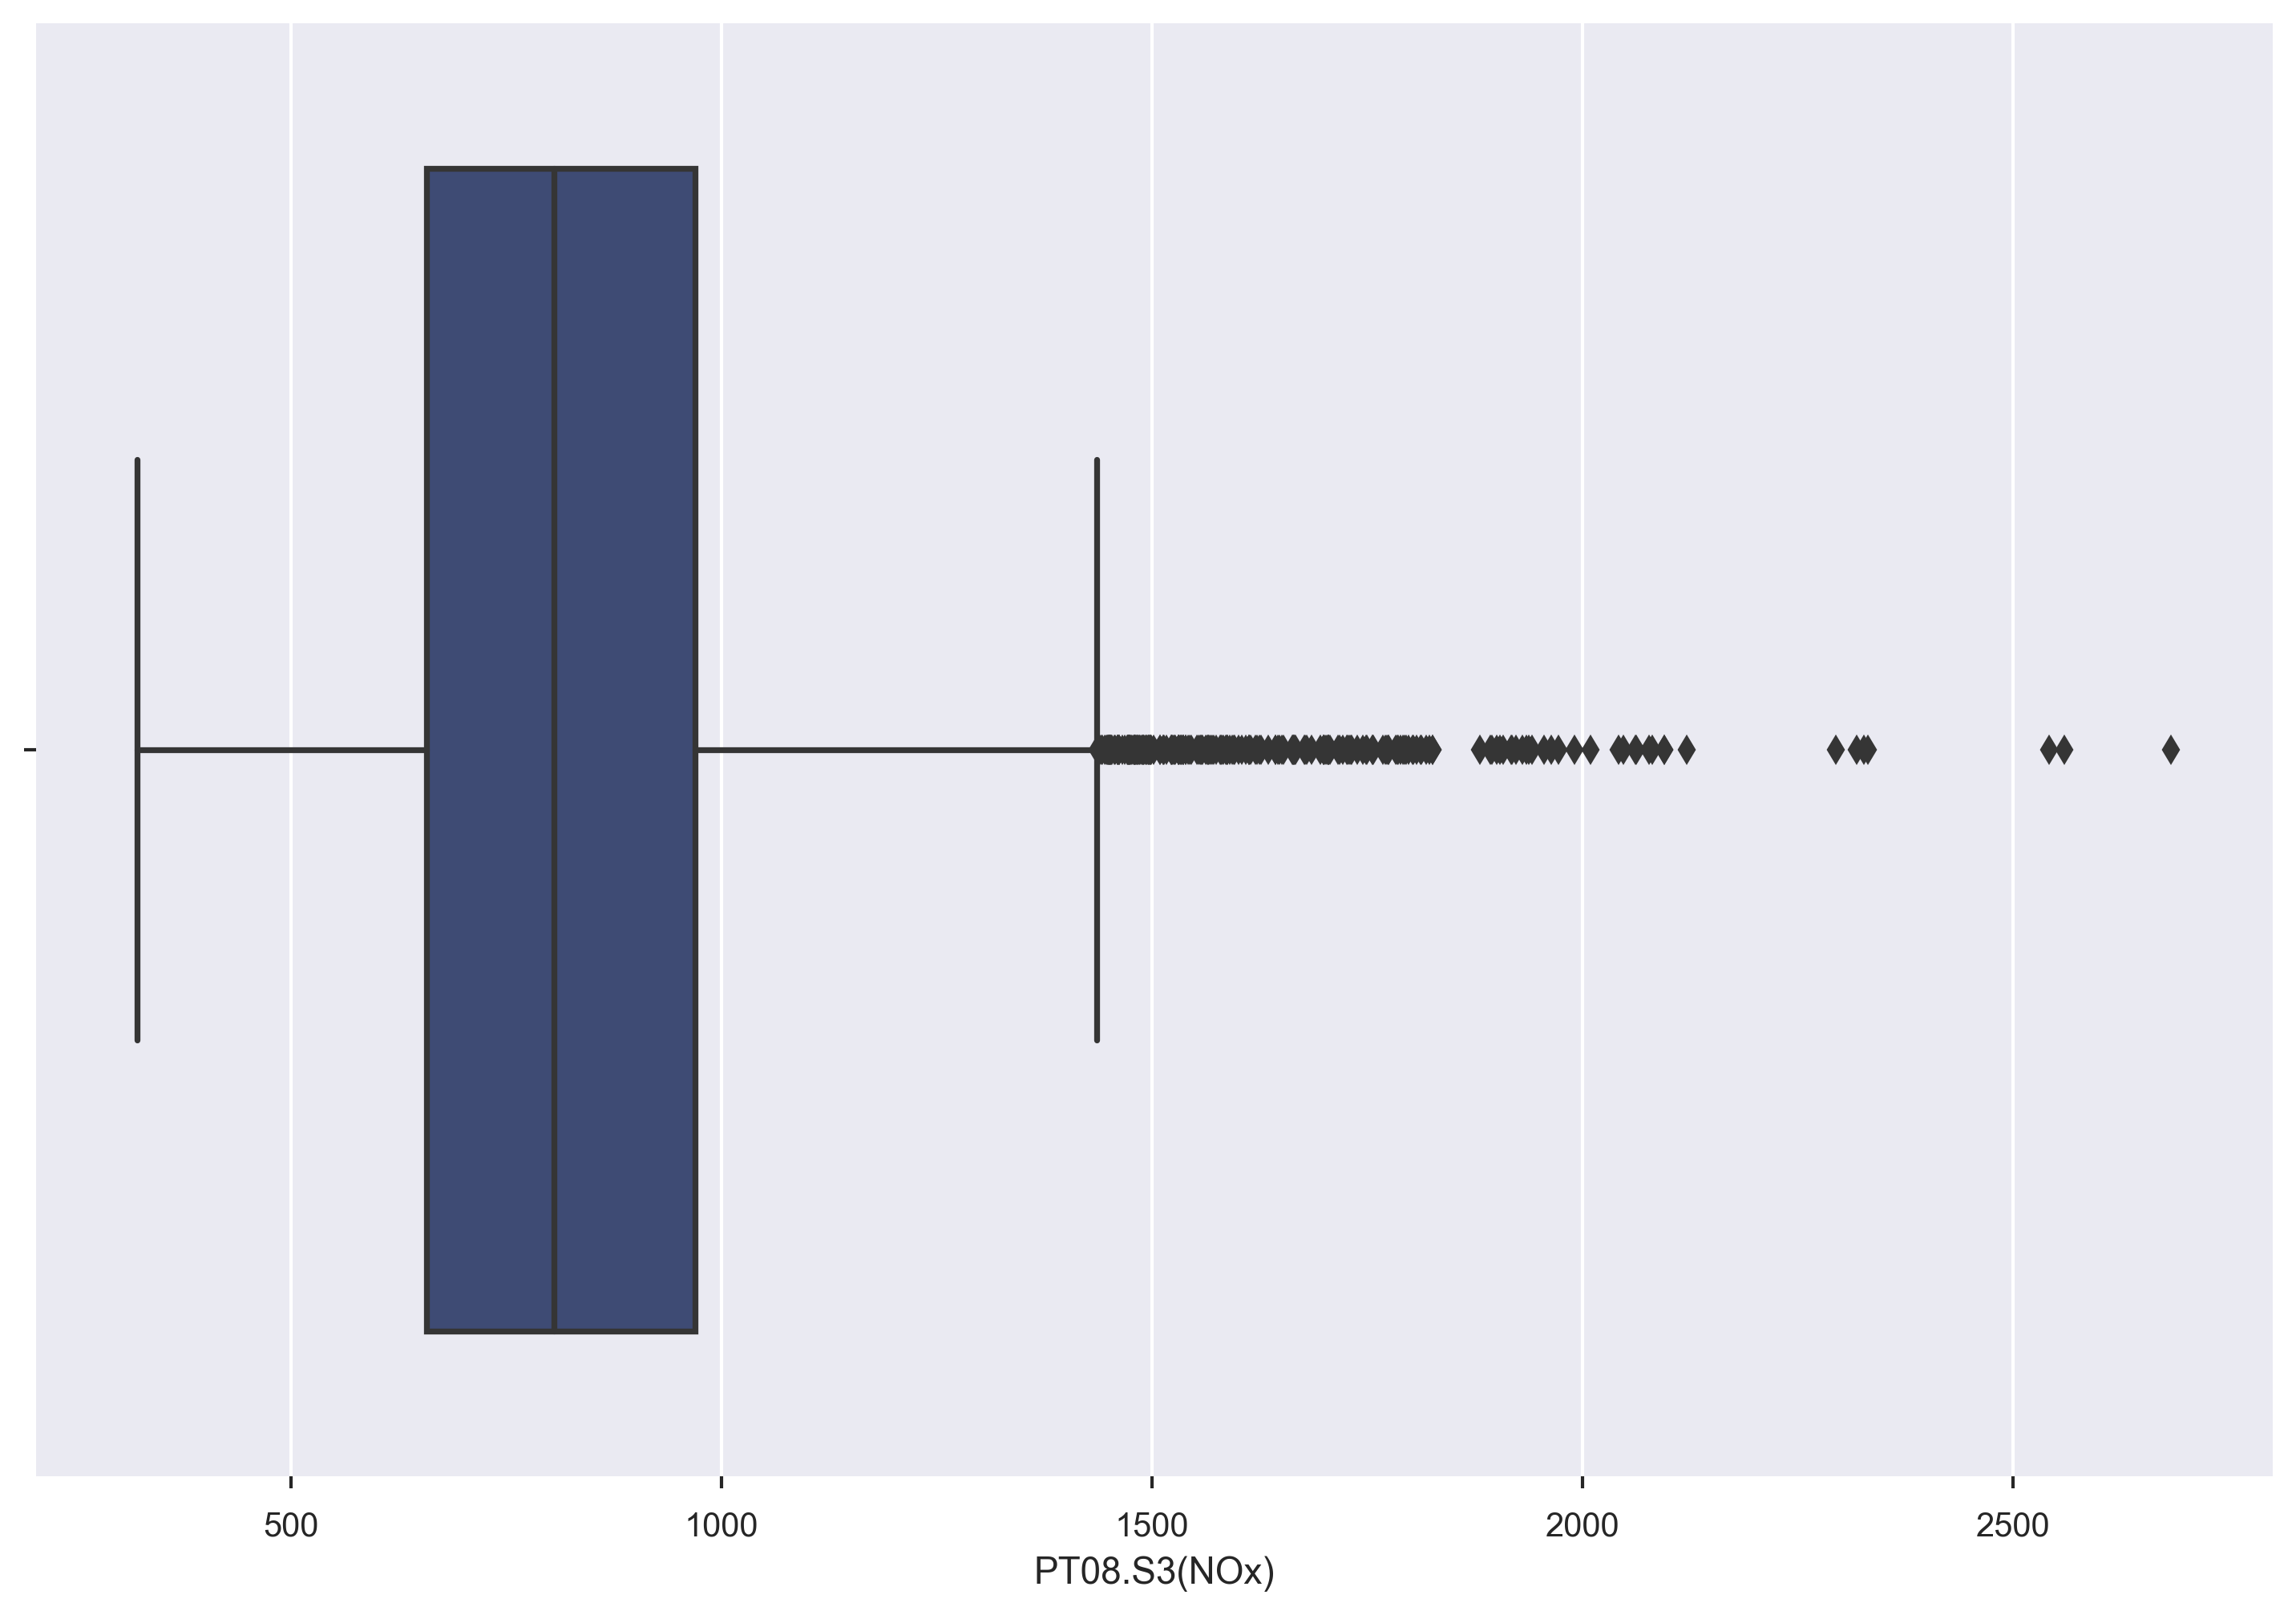

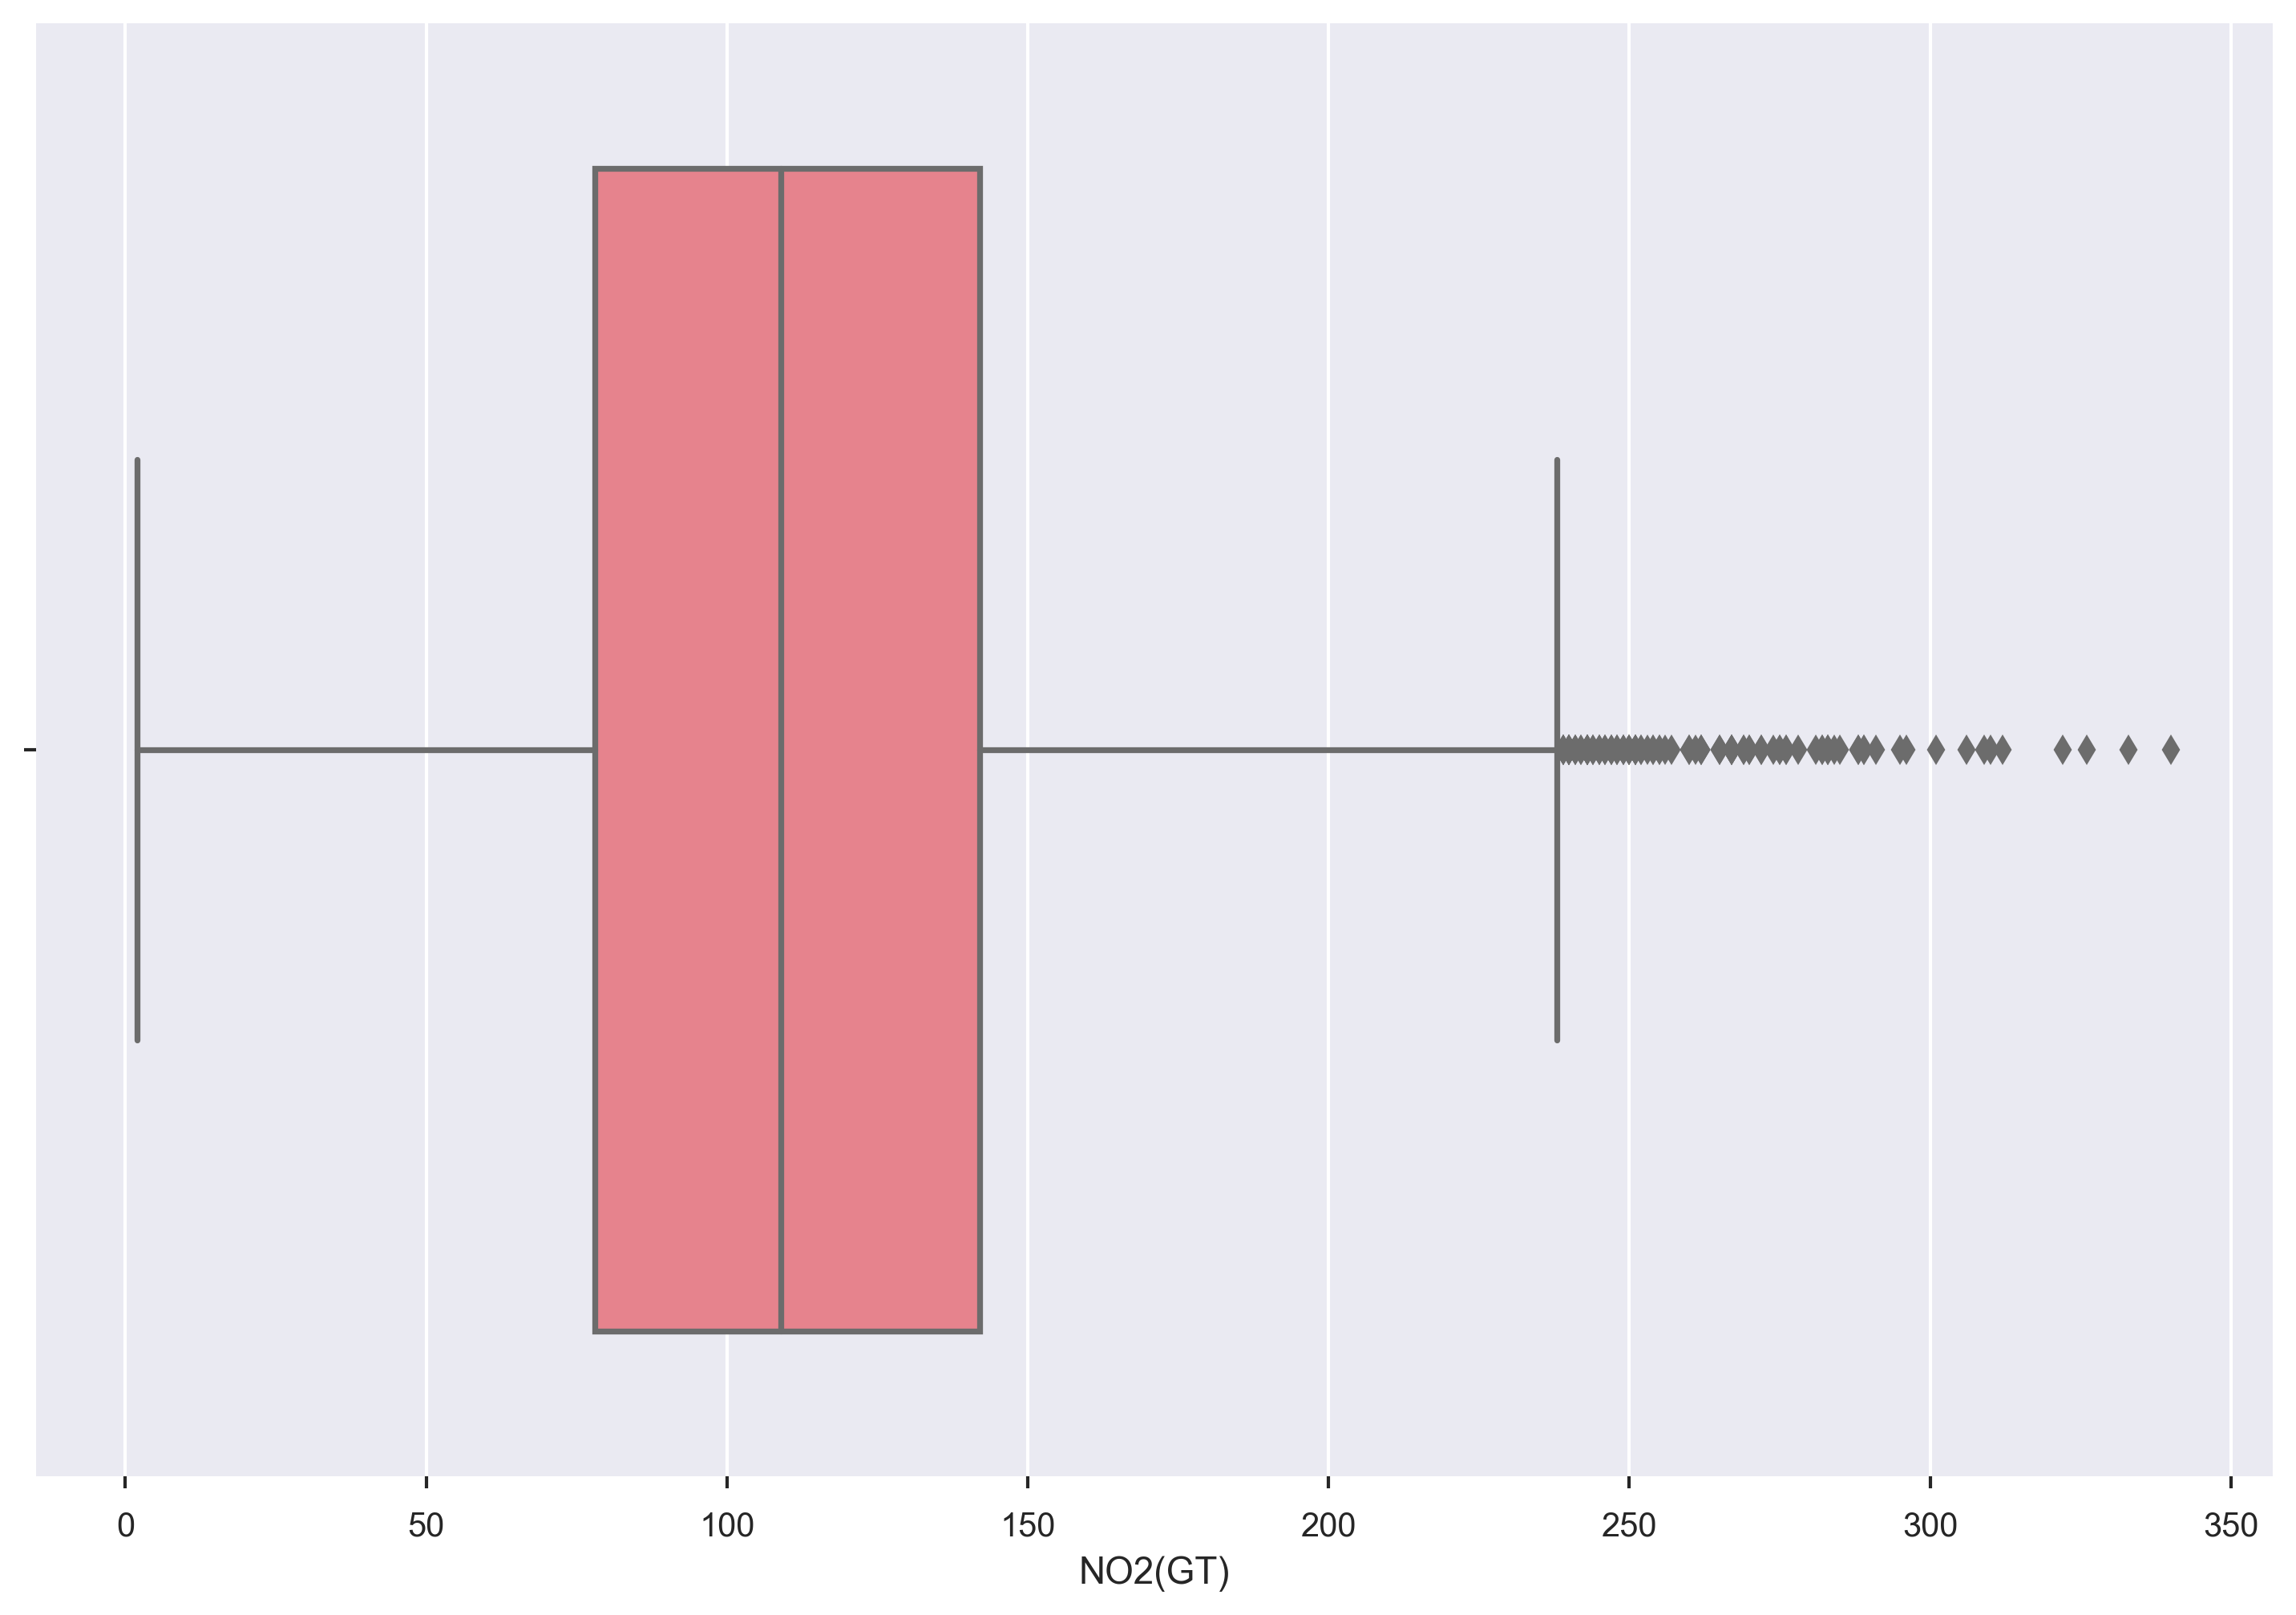

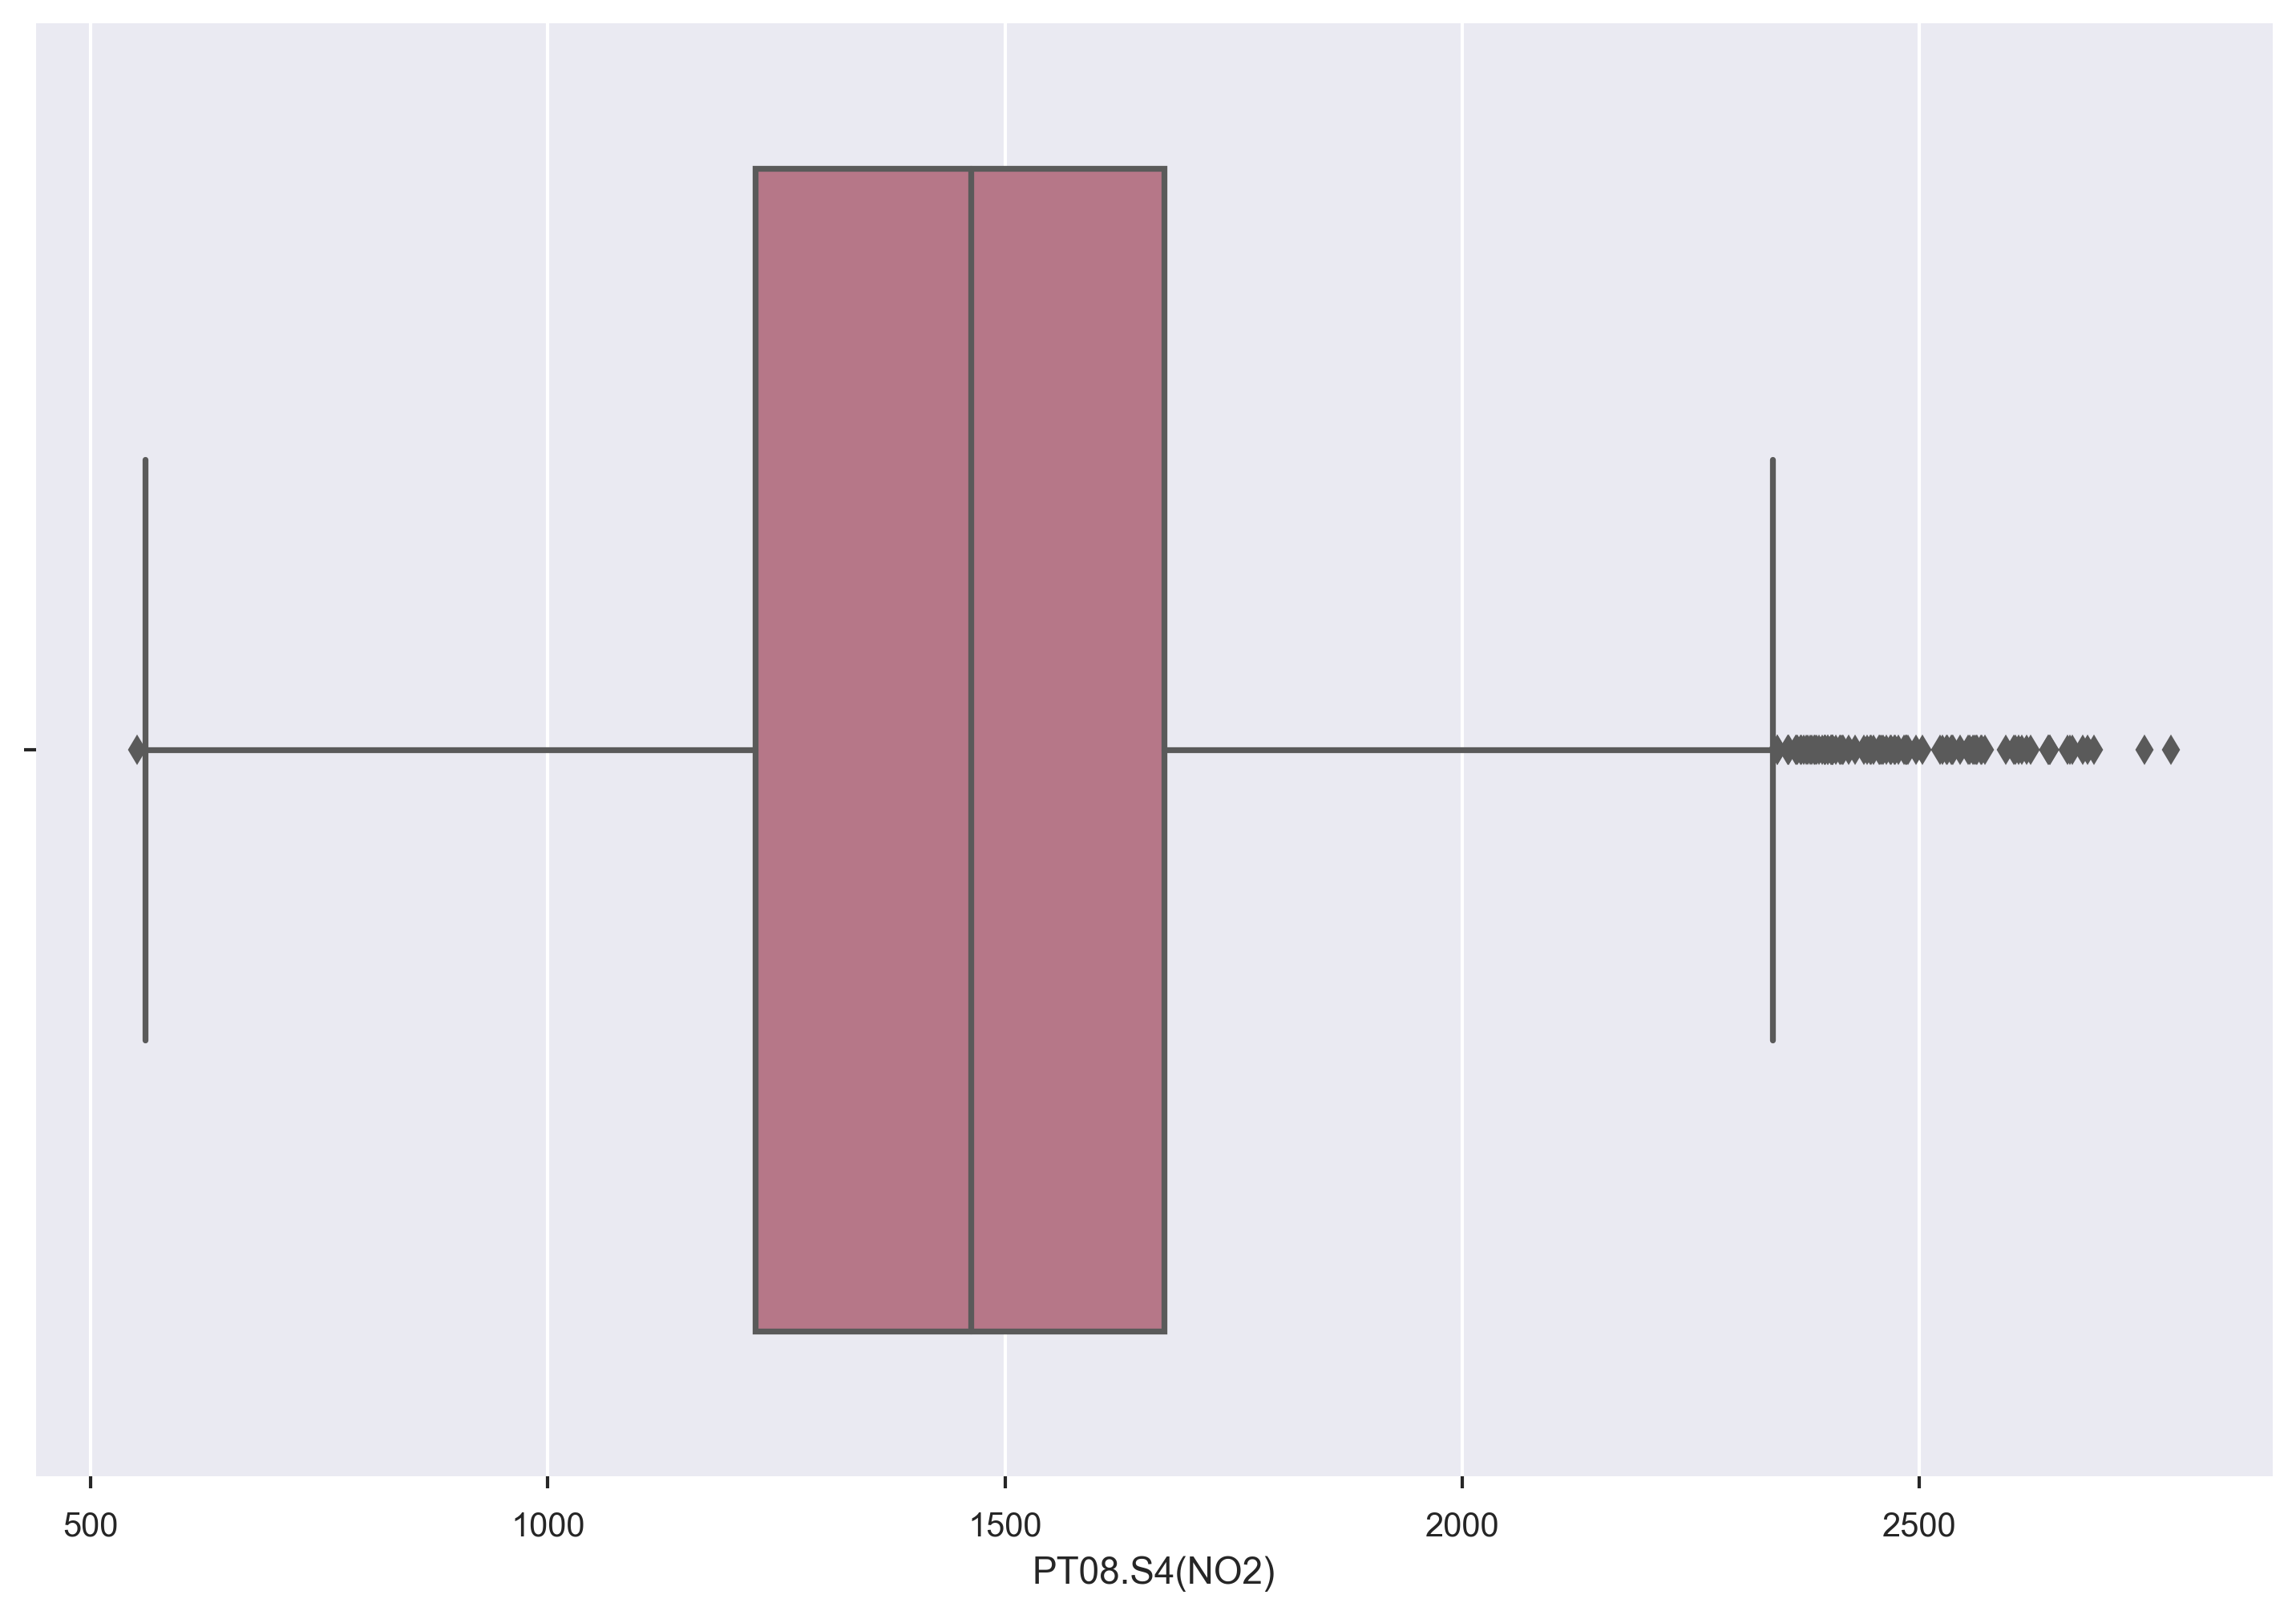

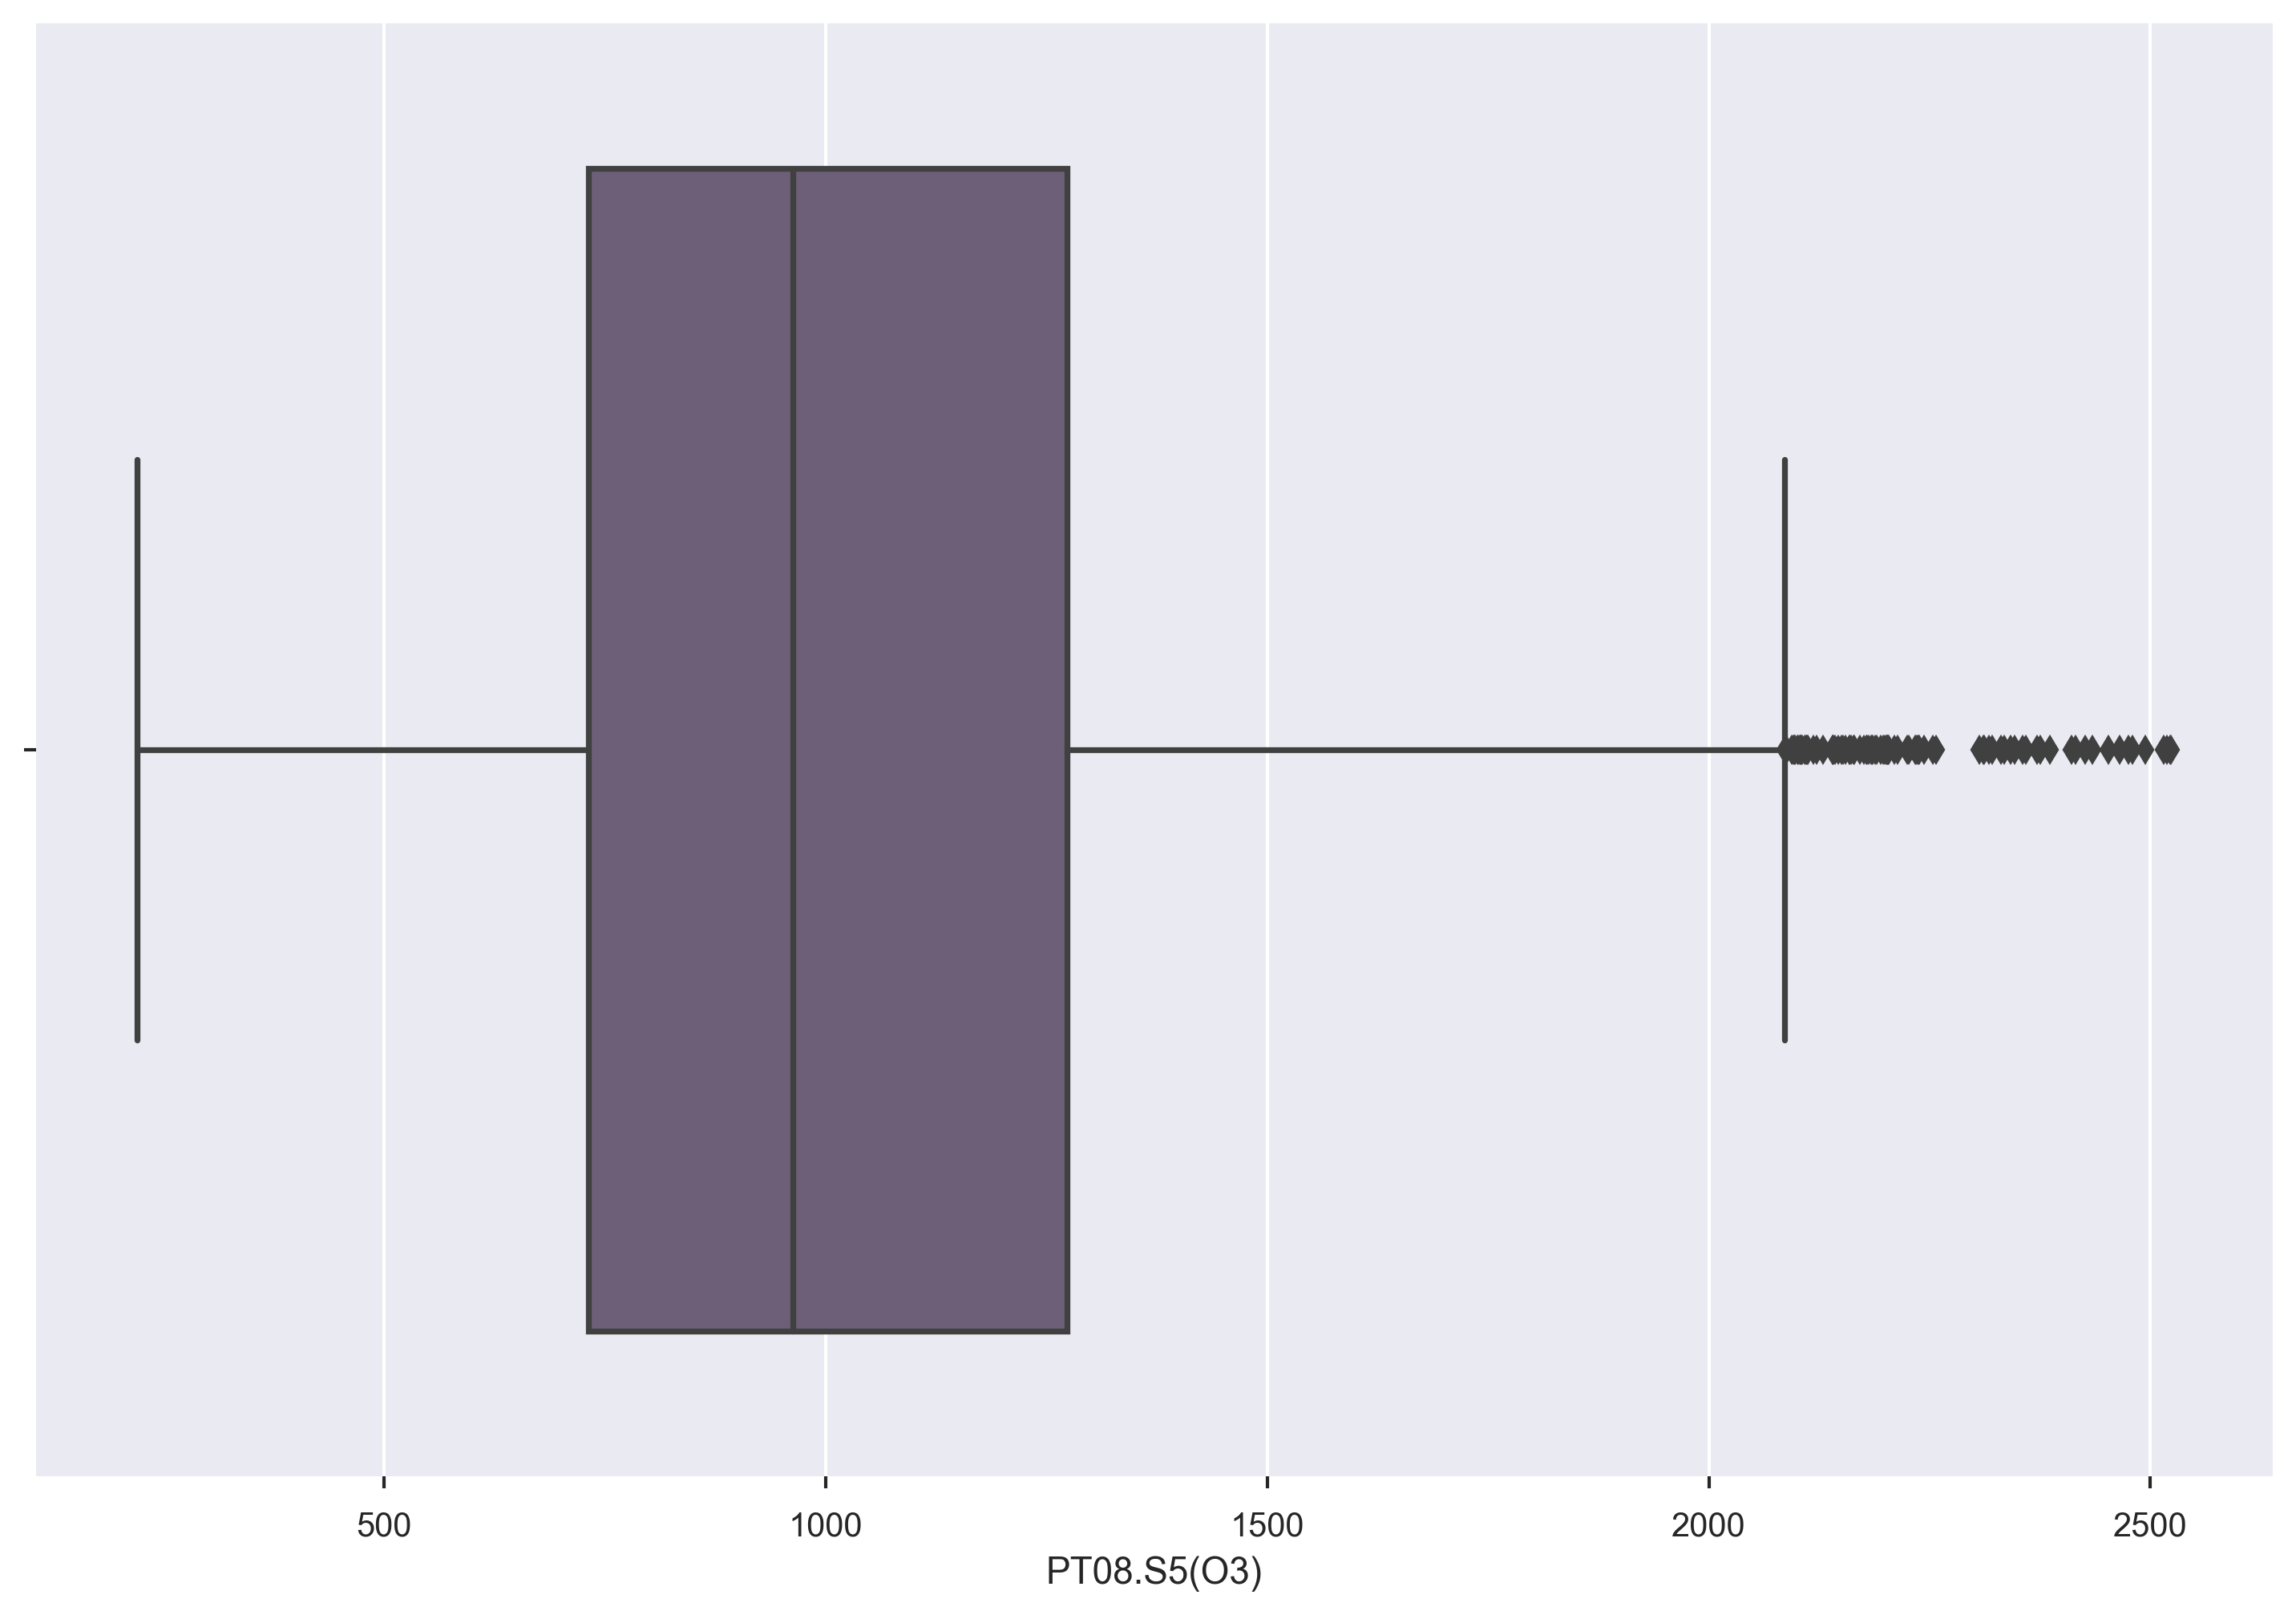

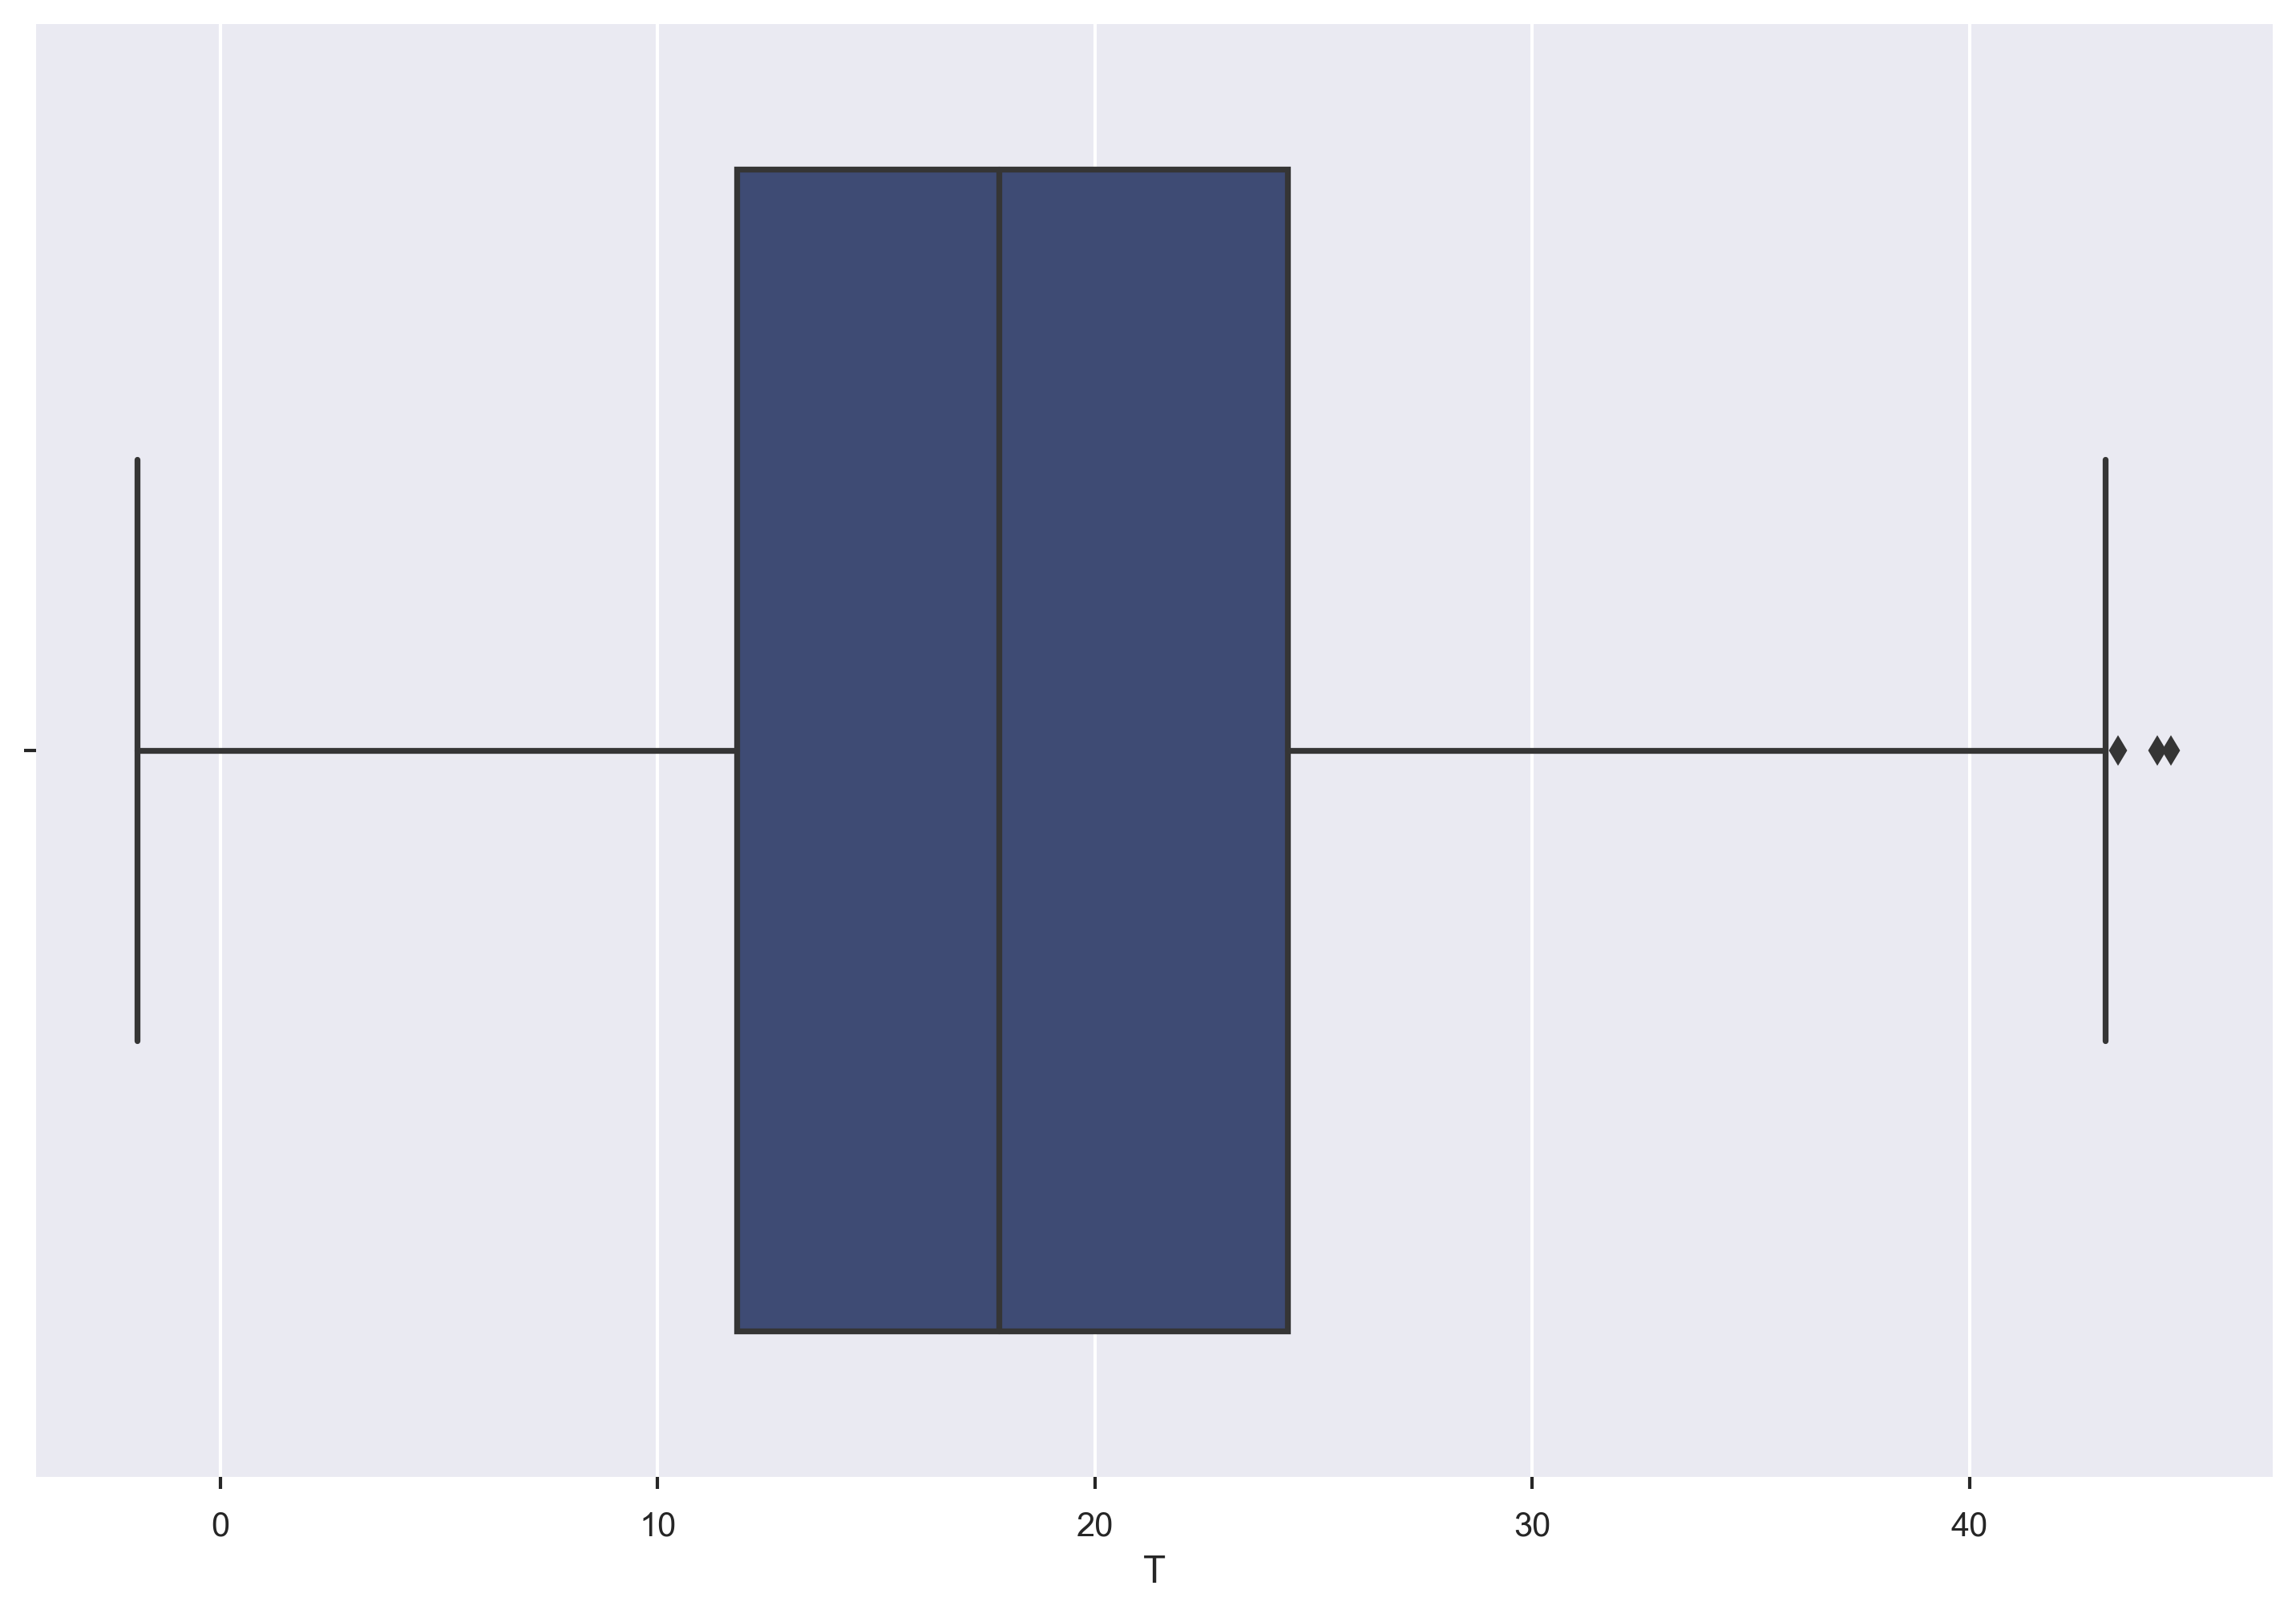

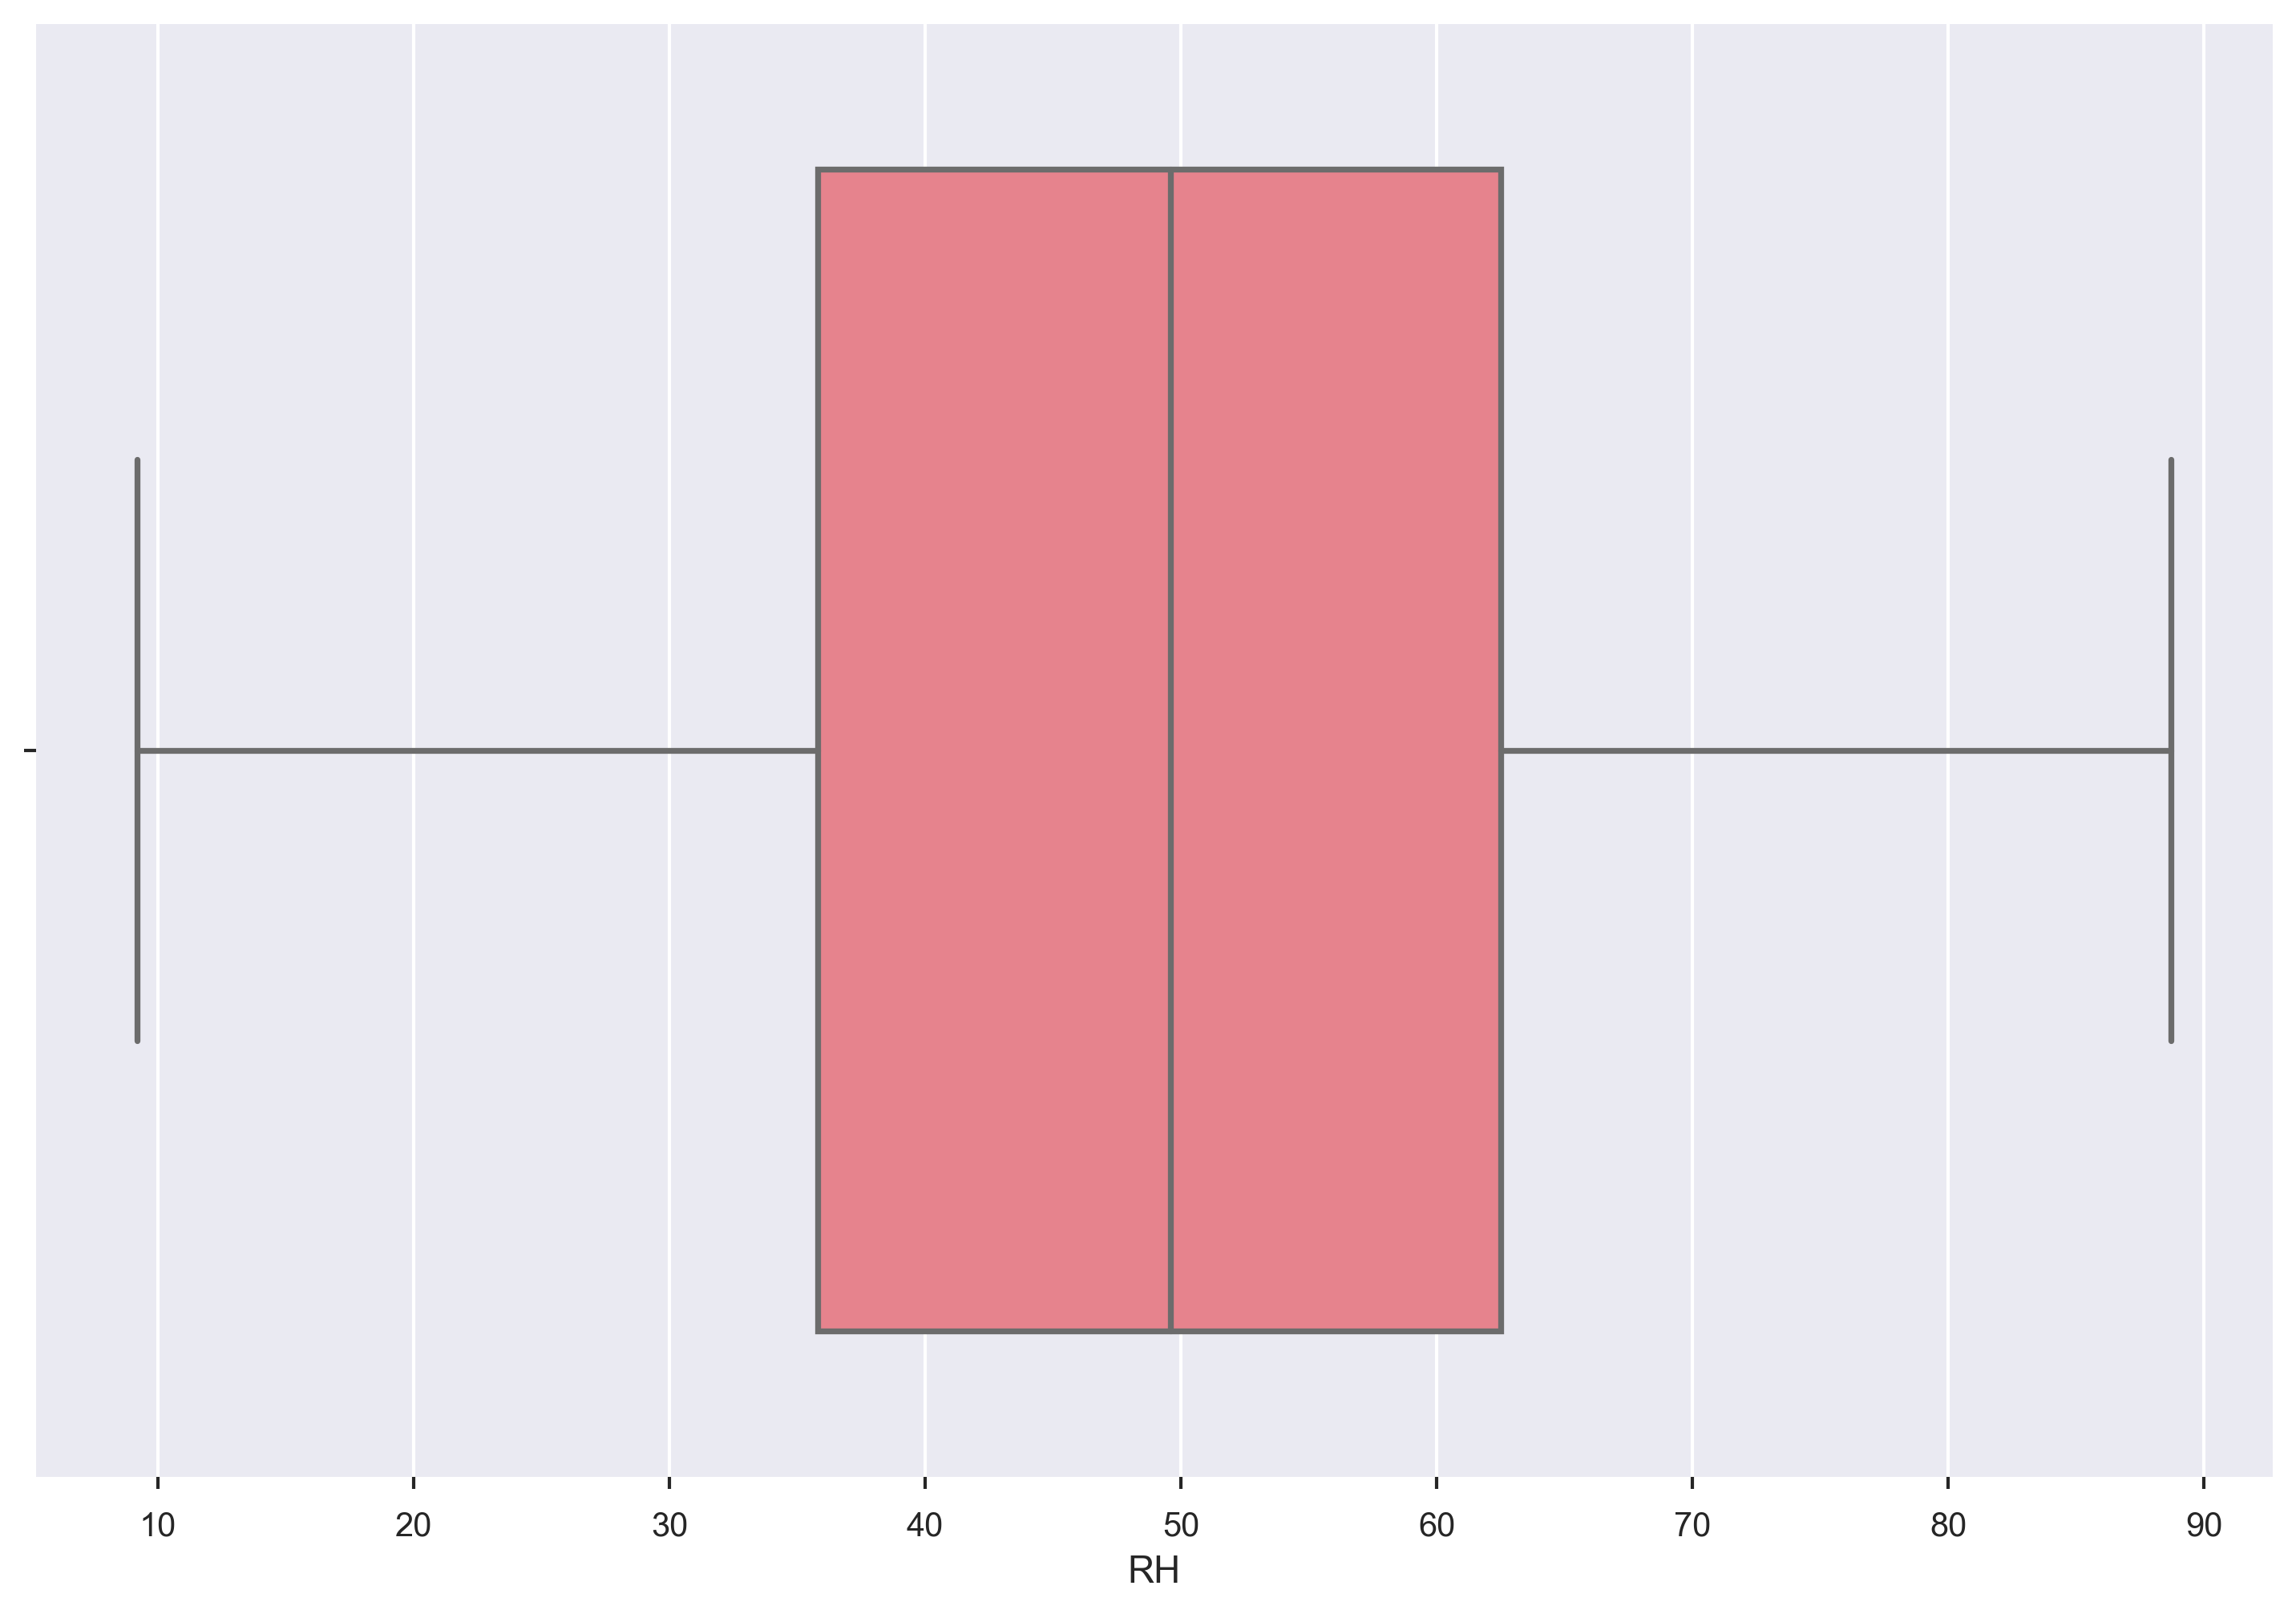

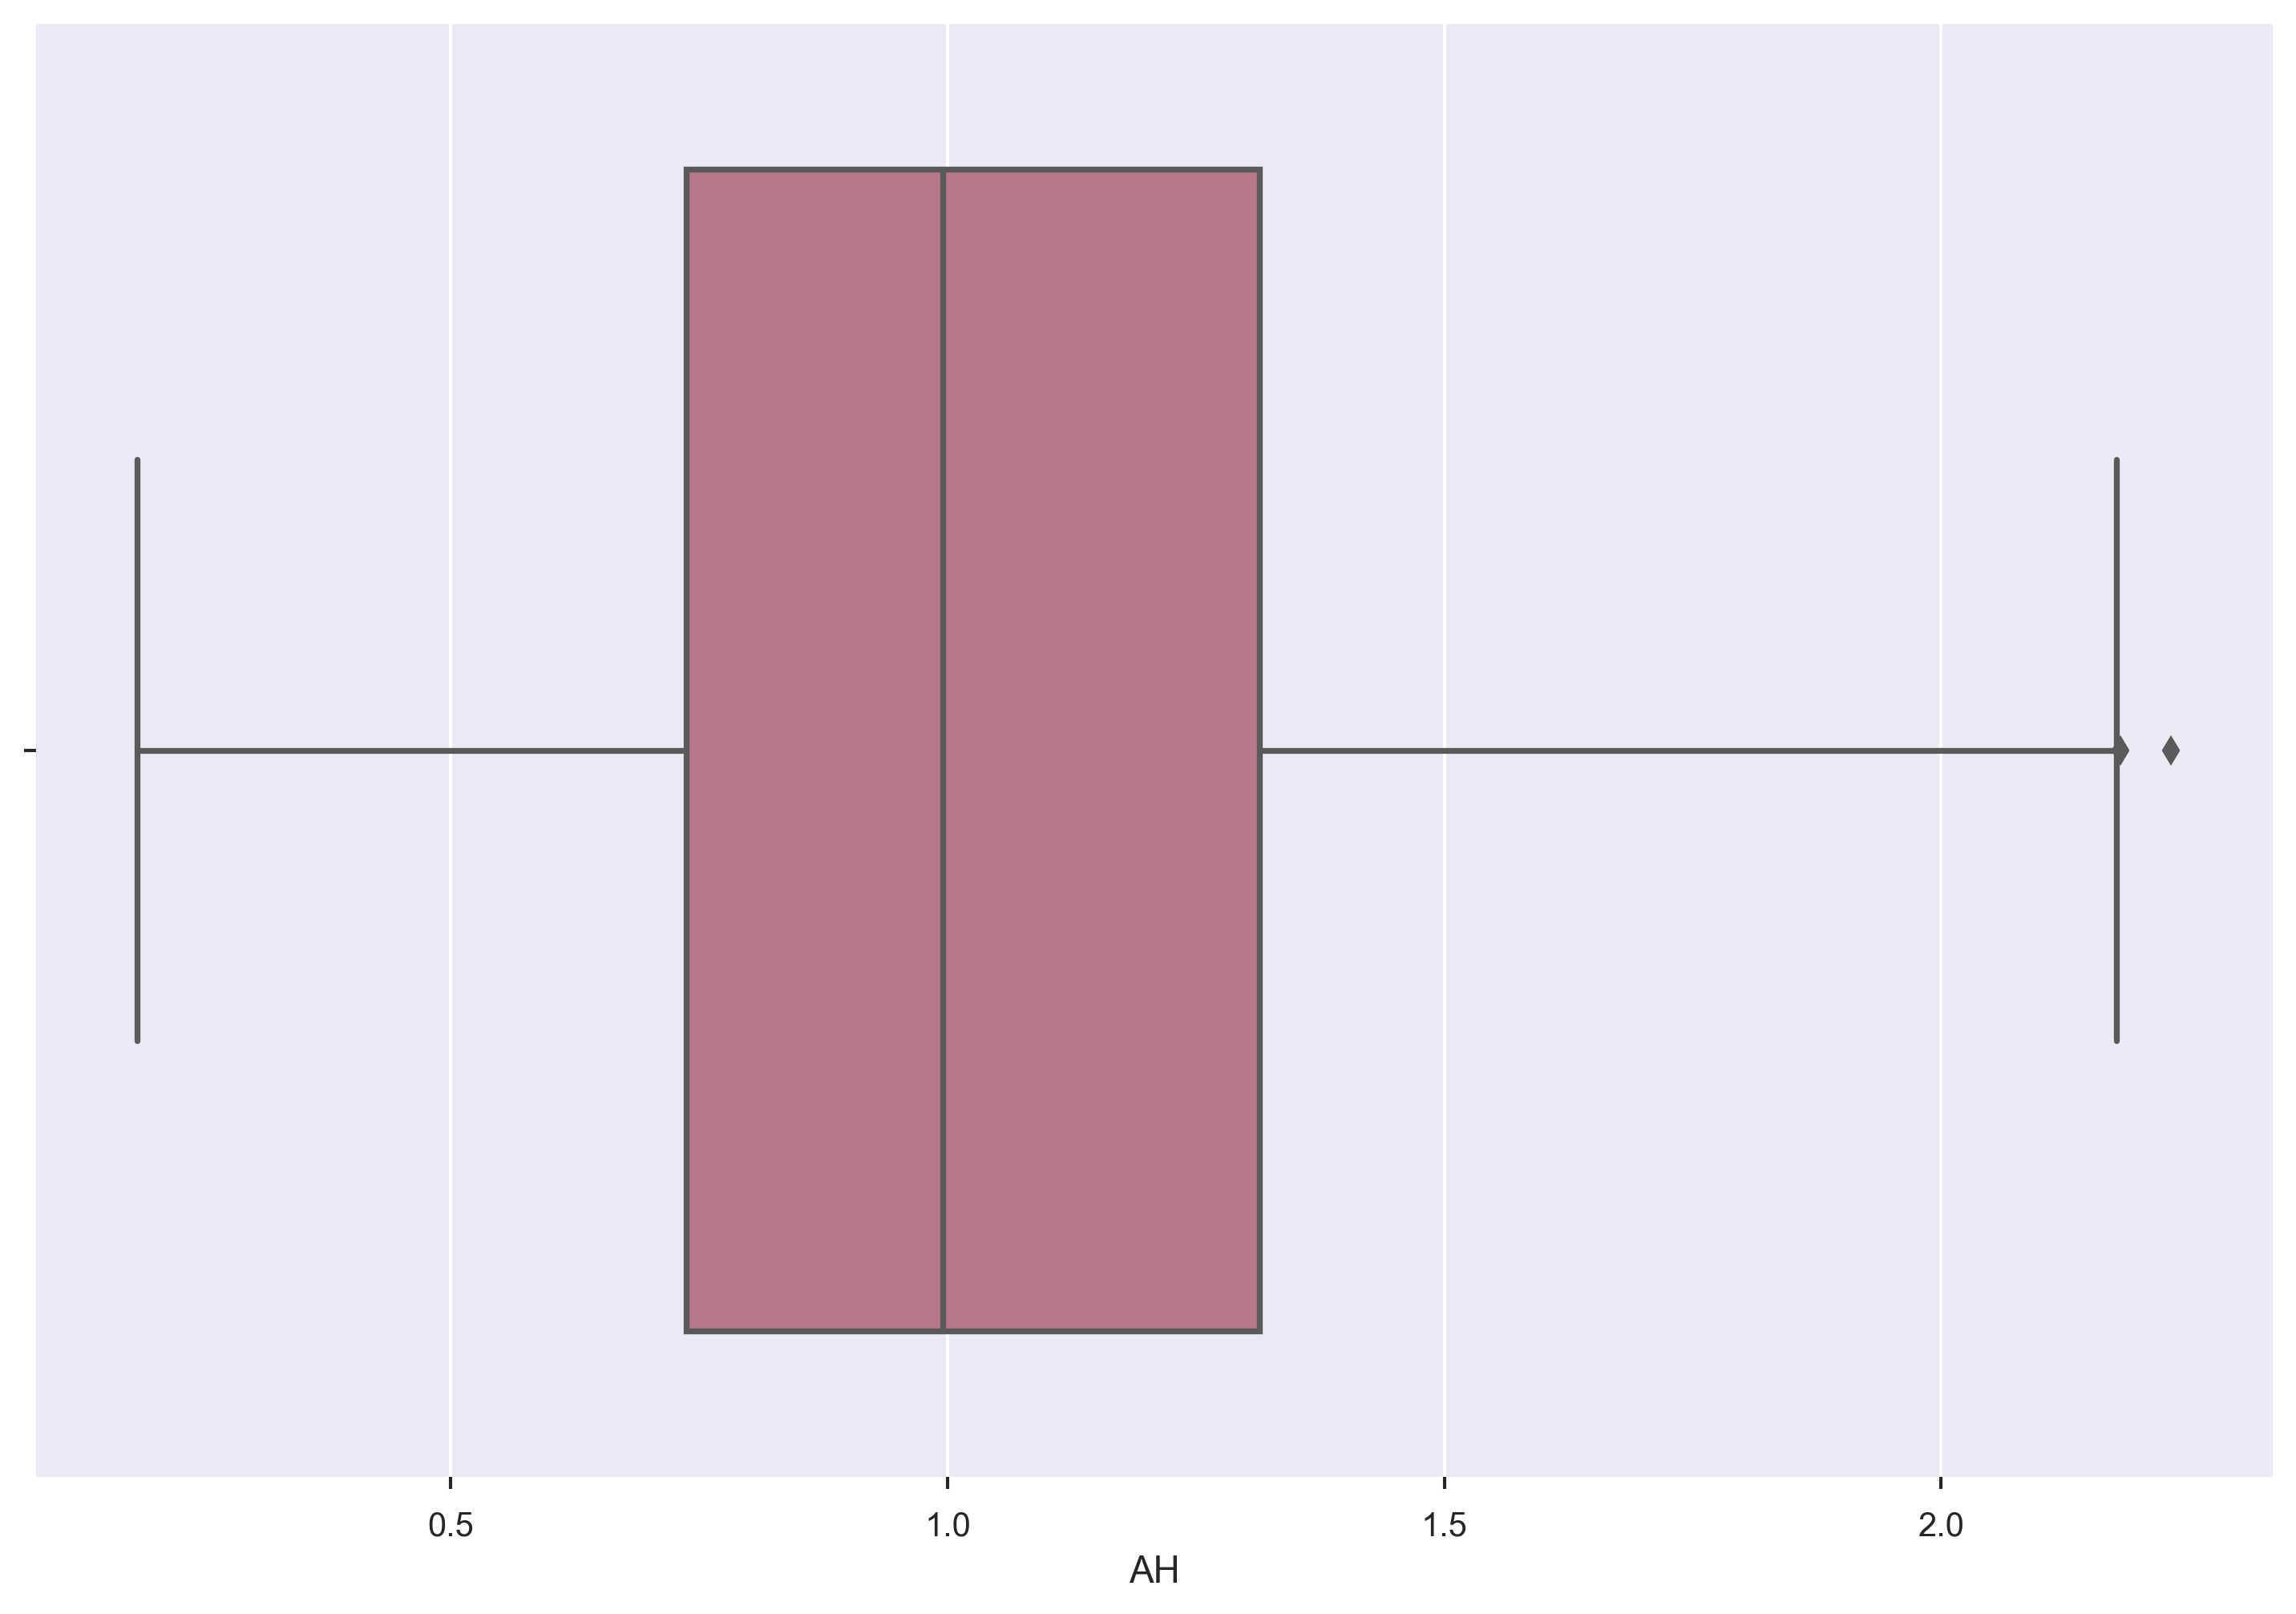

In [43]:
for i, feature in enumerate(NUMERIC_FEATURES):
    plt.figure(figsize=(12, 8))
    sns.boxplot(air_quality_df[air_quality_df[feature] > -200][feature], color=colors[i])
    plt.show()

Os outliers mais expressivos aparecem para as variáveis `C6H6(GT)`, `PT08.S2(NMHC)`, `NOx(GT)` e `PT08.S3(NOx)`, em sua totalidade gases emitidos por automóveis. A princípio, podemos assumir que esses valores extremos (em todos os casos, mais altos que a maioria das medições) se devem aos **horários de pico** do trânsito na cidade. Caso percebamos prejuízo à performance dos modelos preditivos, vamos tratar deles.

Agora vamos agrupar nossos dados utilizando **análise de clusters por K-Means** para verificar se há outliers no espaço das variáveis:

In [111]:
FEATURES = [
    'C6H6(GT)', 'PT08.S2(NMHC)', # Concentrações de benzeno e outros hidrocarbonetos
    'NOx(GT)', 'PT08.S3(NOx)', # Concentrações de óxidos de nitrogênio diversos
    'NO2(GT)', 'PT08.S4(NO2)', # Concentrações de dióxido de nitrogênio
    'PT08.S5(O3)', # Concentração de ozônio
    'T', 'RH', 'AH', # Temperatura e umidade (relativa e absoluta)
    'sin_hour', 'cos_hour', # Variáveis cíclicas para a hora da medição
    'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday' # Dia da semana da medição
]

In [71]:
X = air_quality_df[CLASSIFICATION_COLS + ['PT08.S1(CO)']].values

Primeiro, vamos encontrar o número ótimo de clusters pelos métodos do "cotovelo" e das silhuetas:

In [72]:
MAX_CLUSTER_NUMBER = 20
cluster_numbers = list(range(2, MAX_CLUSTER_NUMBER + 1))
within_squared_sum_error = []
silhouettes = []

In [73]:
for k in cluster_numbers:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X)
    within_squared_sum_error.append(k_means.inertia_)
    silhouettes.append(silhouette_score(X, k_means.labels_, metric='euclidean'))

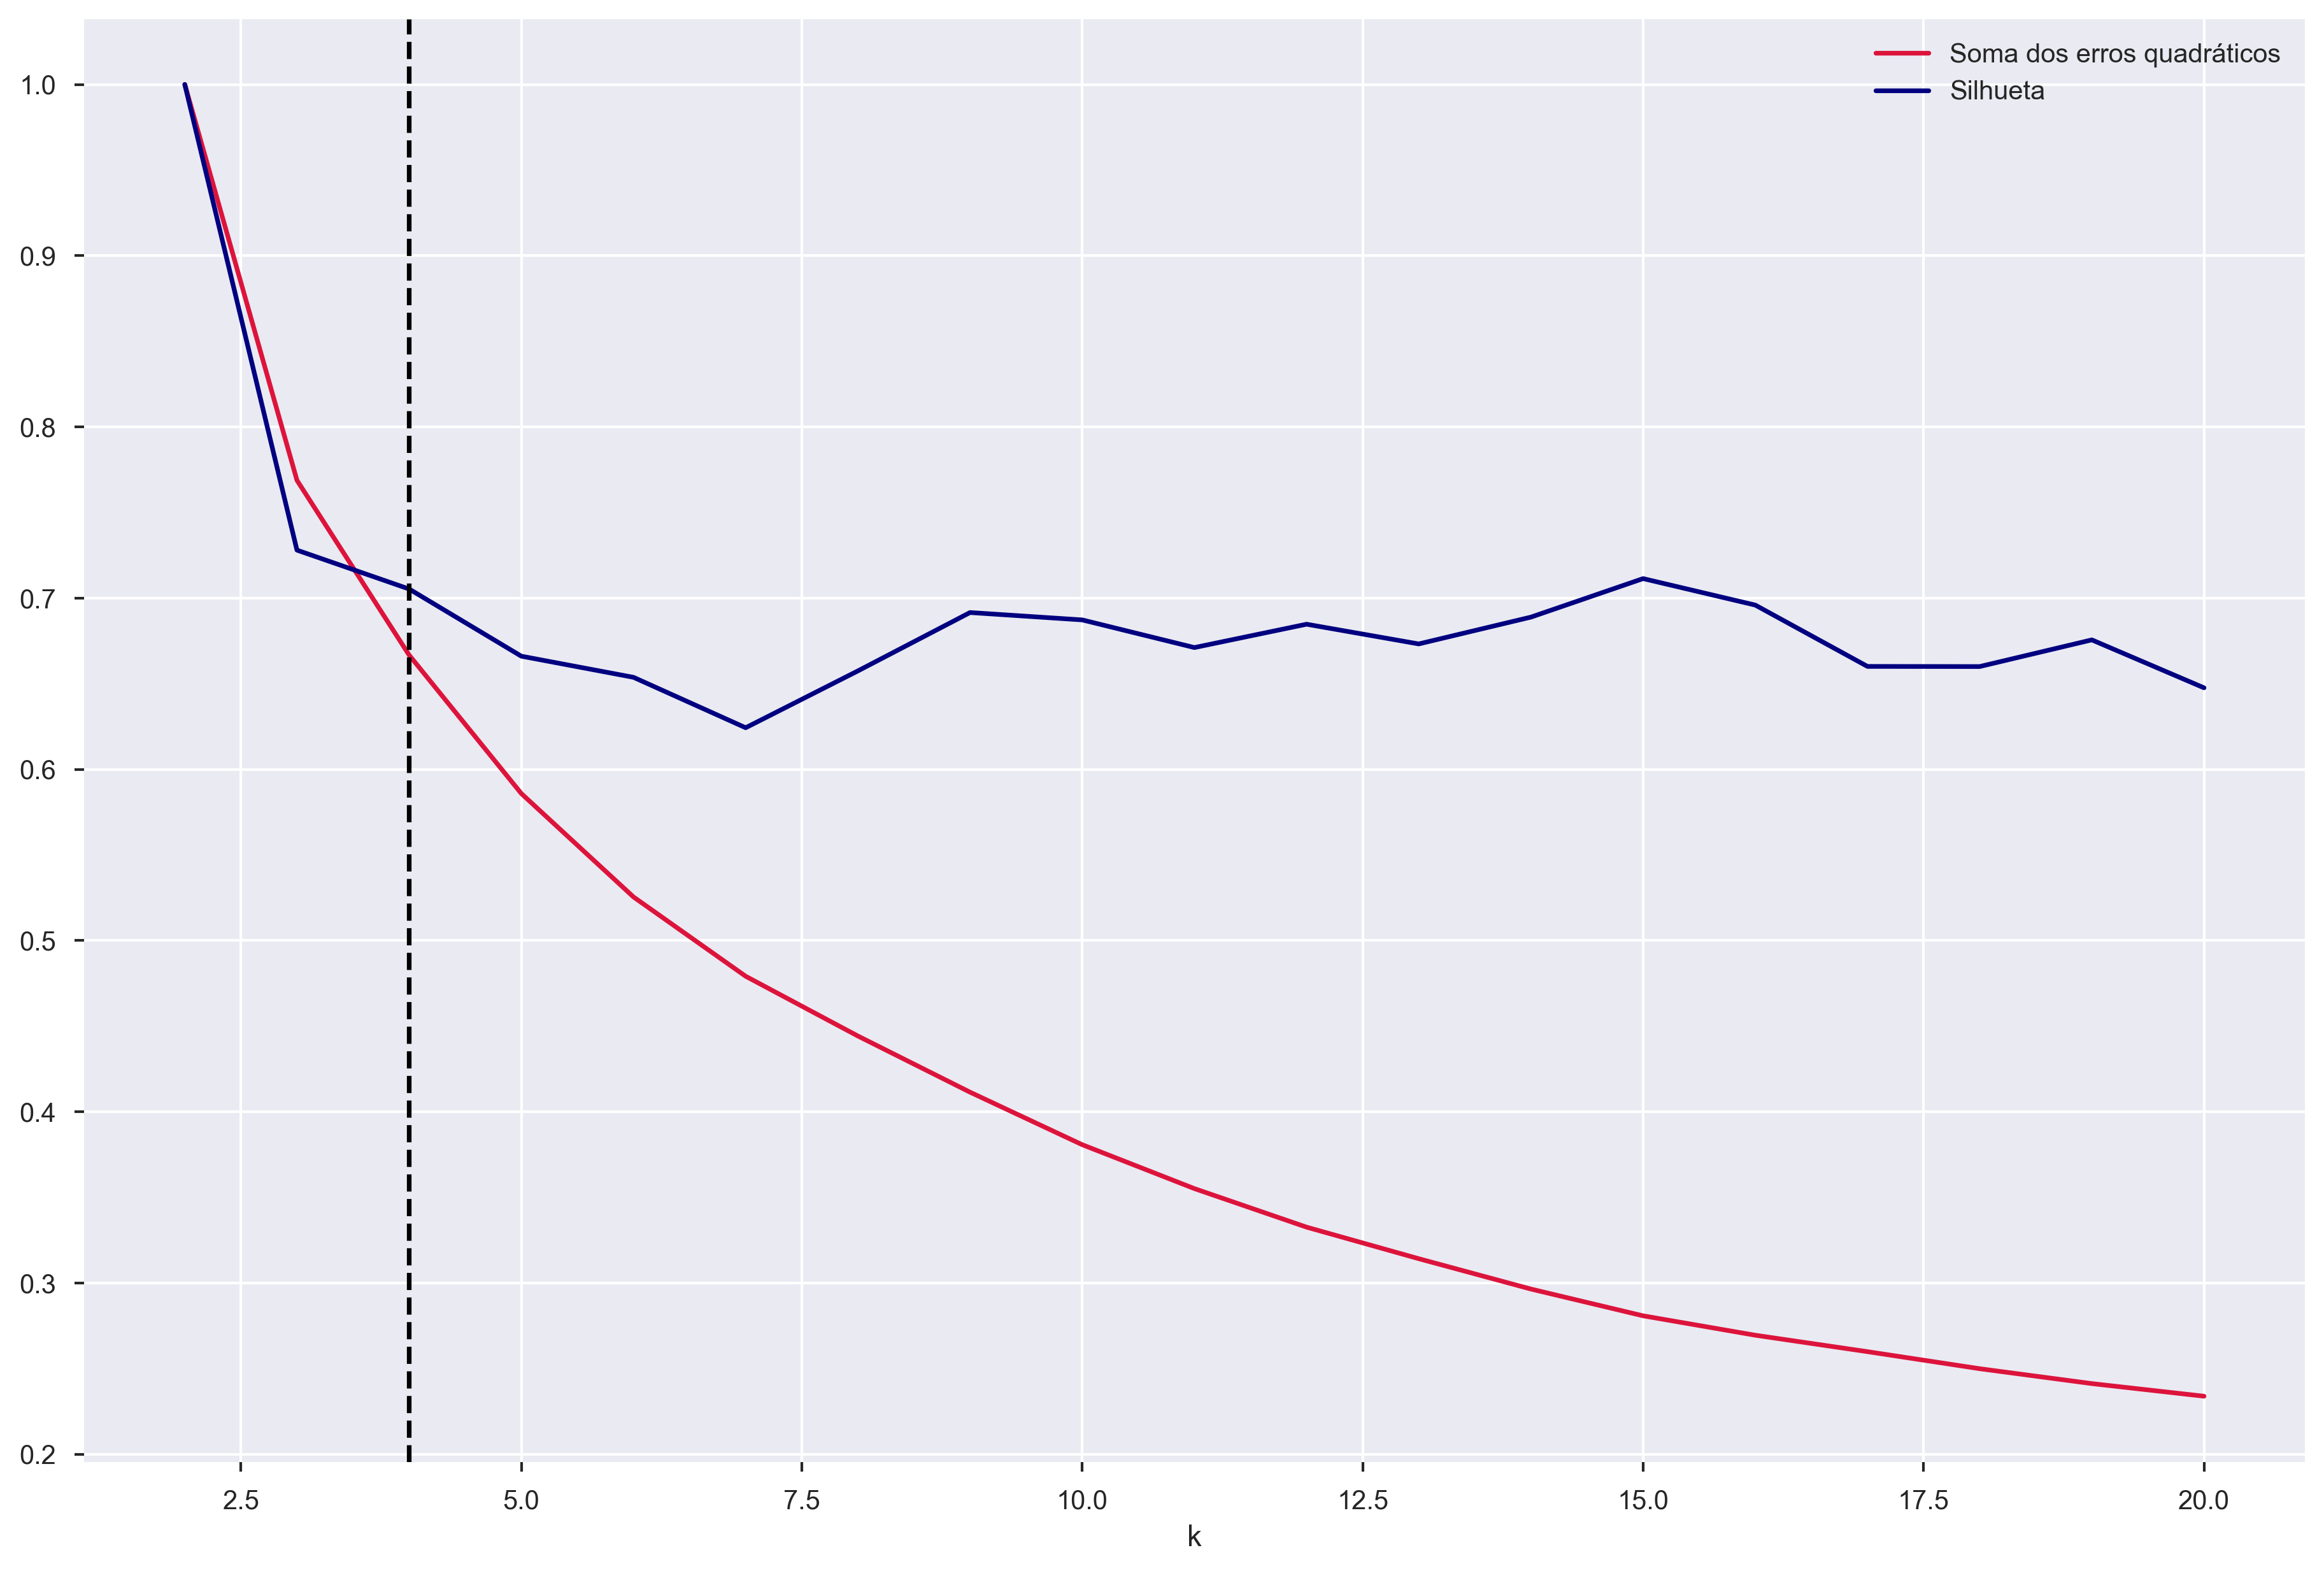

In [75]:
plt.figure(figsize=(15, 10))
sns.lineplot(cluster_numbers, within_squared_sum_error / max(within_squared_sum_error), color='crimson')
sns.lineplot(cluster_numbers, silhouettes / max(silhouettes), color='navy')
plt.axvline(x=4, color='k', linestyle='--')
plt.xlabel('k')
plt.legend(['Soma dos erros quadráticos', 'Silhueta'])
plt.grid(True)
plt.show()

Temos um pico da silhueta e um "cotovelo" na soma de erros quadráticos em `k=4`, portanto esse é o nosso número ótimo de clusters.

In [76]:
k_means = KMeans(n_clusters=4, random_state=42).fit(X)

In [77]:
y_k_means = k_means.predict(X)

In [78]:
air_quality_df['k_means_cluster'] = y_k_means

In [79]:
X = air_quality_df[FEATURES + ['PT08.S1(CO)']].values

Vamos reduzir as variáveis a 2 dimensões utilizando análise de componente principal (PCA) para poder verificar visualmente a separação entre os clusters.

In [80]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [81]:
clusters = air_quality_df['k_means_cluster'].values

In [82]:
CLUSTER_COLOR_DICT = {
    0: 'red',
    1: 'blue',
    2: 'yellow',
    3: 'green',
}

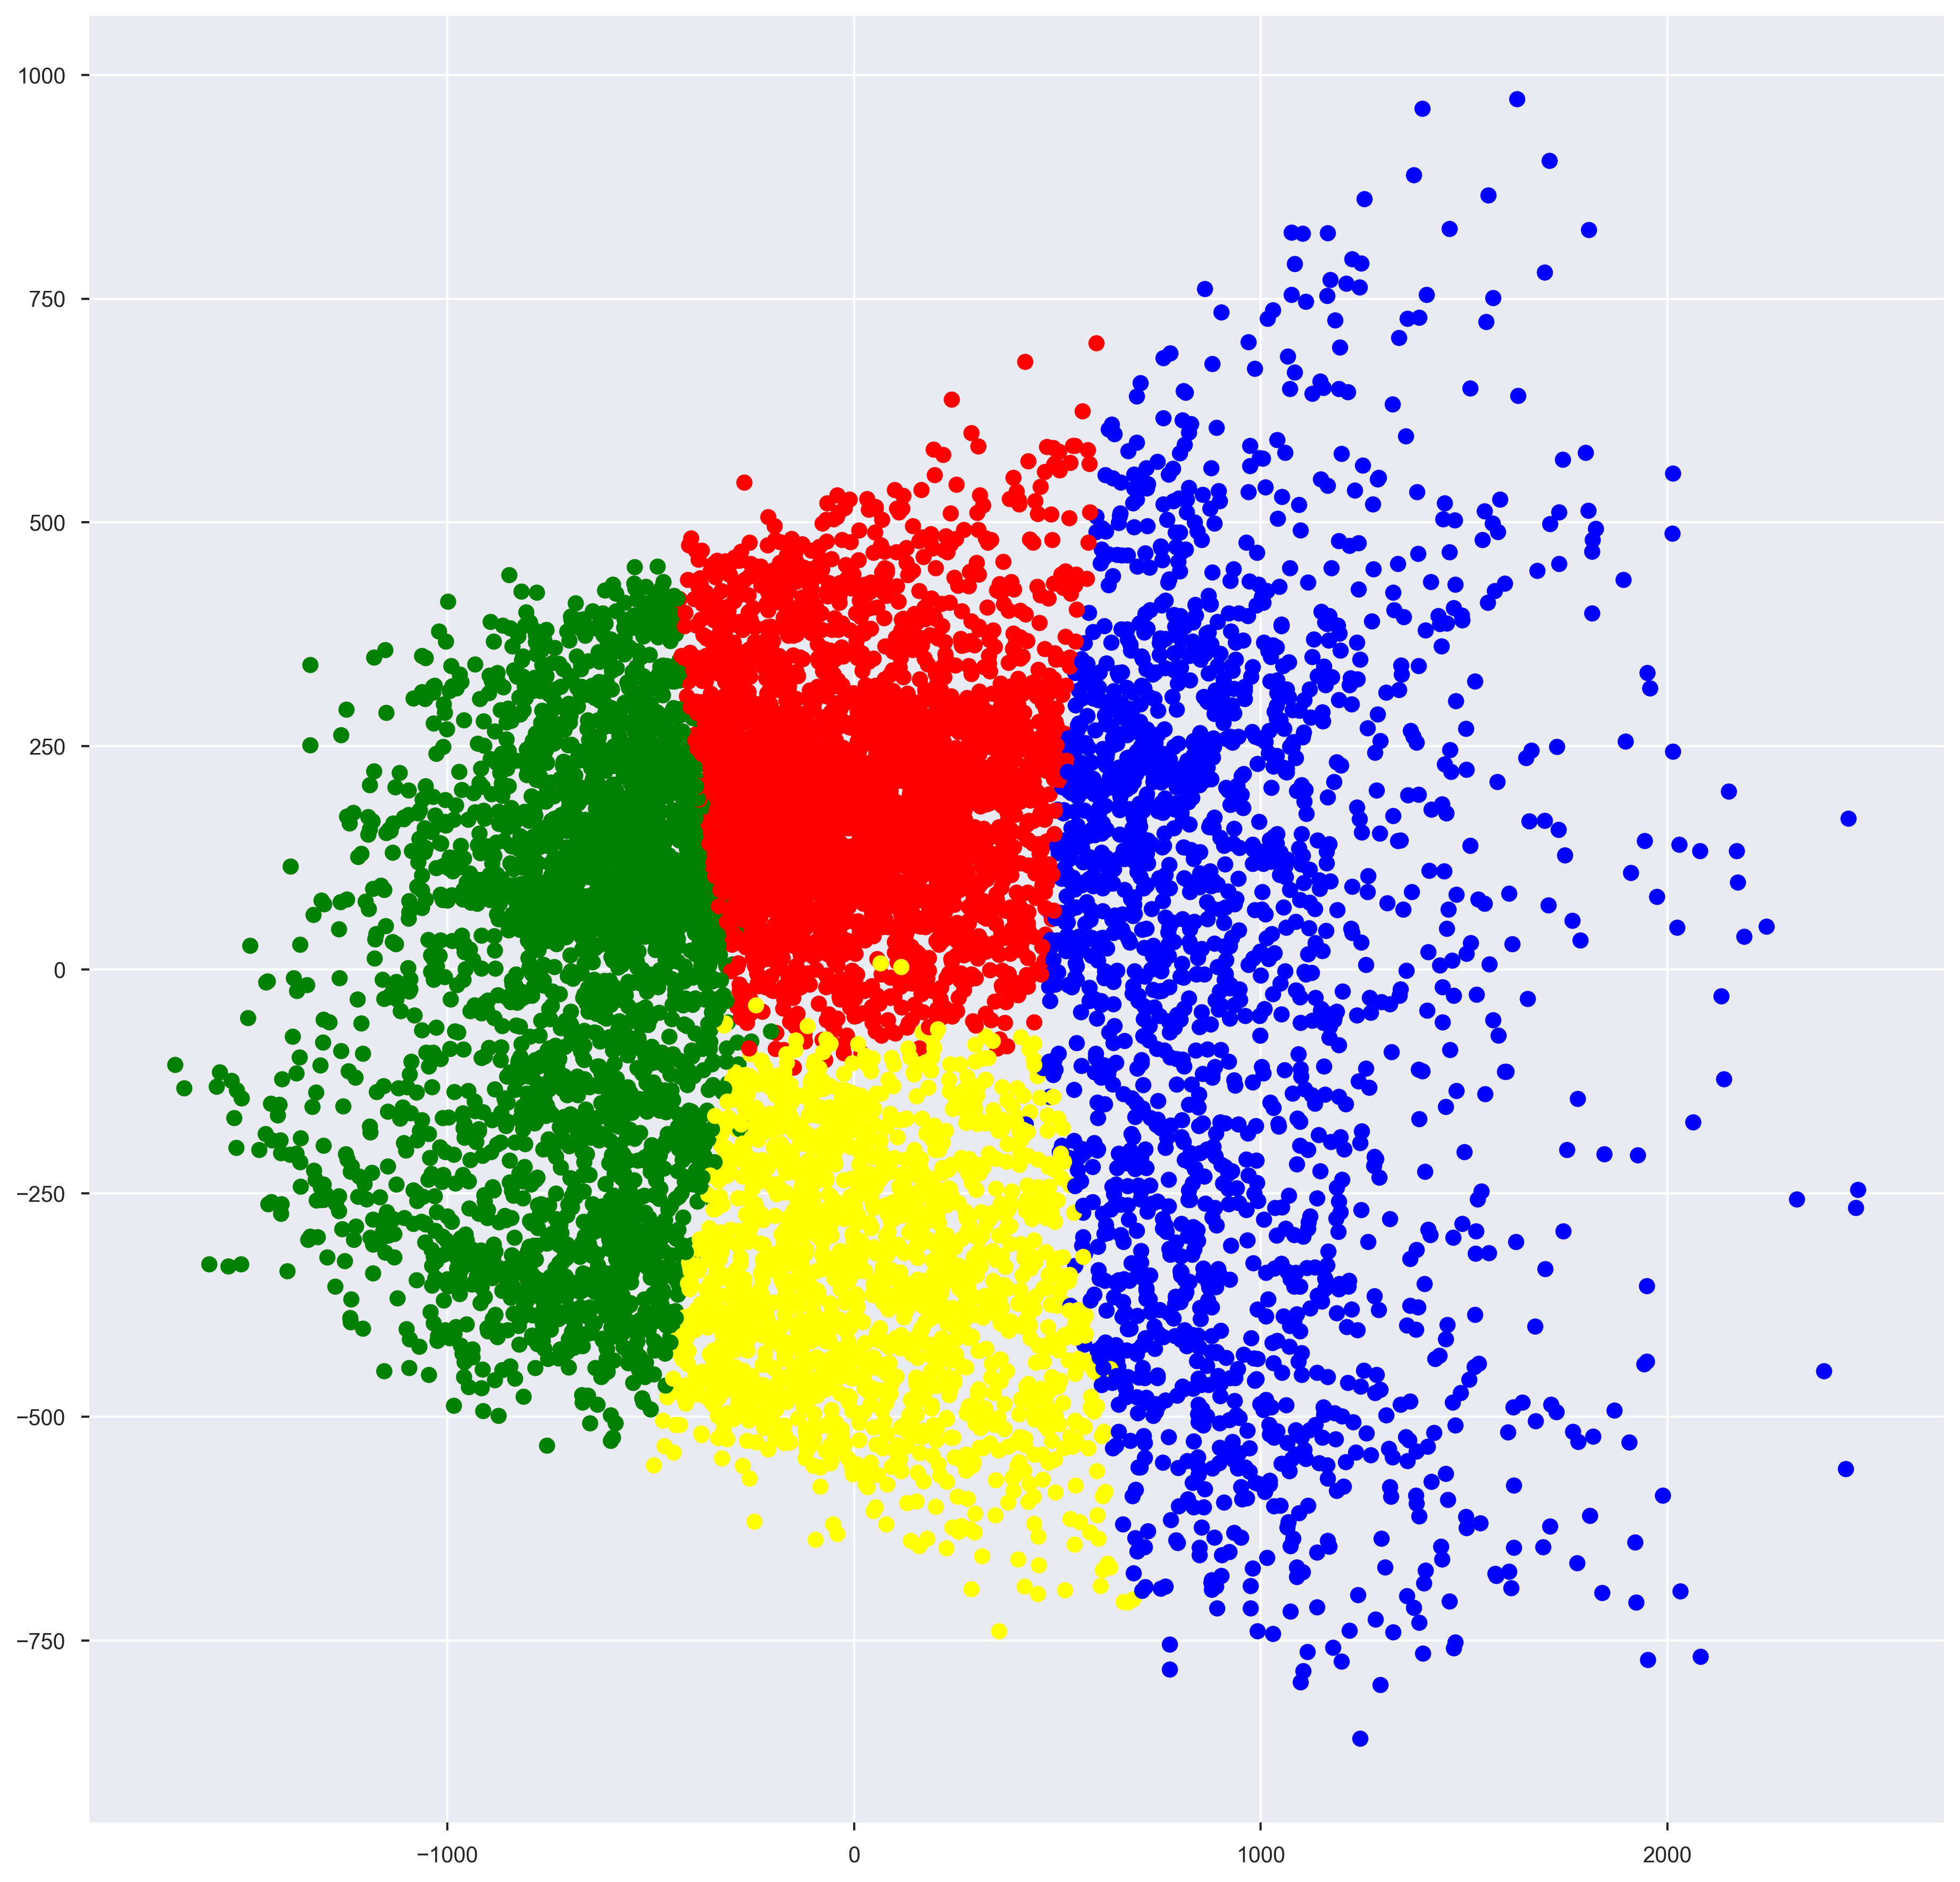

In [83]:
fig = plt.figure(figsize=(15, 15))

for cluster, (x1, x2) in zip(clusters, X_pca):
    plt.scatter(x1, x2, c=CLUSTER_COLOR_DICT[cluster])
plt.grid(True)
plt.show()

In [68]:
air_quality_df.shape

(9357, 26)

Do gráfico, vemos que cada cluster é relativamente coeso (i.e. sem outliers "intra-cluster") entre si, portanto não vamos nos preocupar com prejuízos aos modelos preditivos a princípio.

### Curvas de concentração de CO, temperatura e umidade relativa

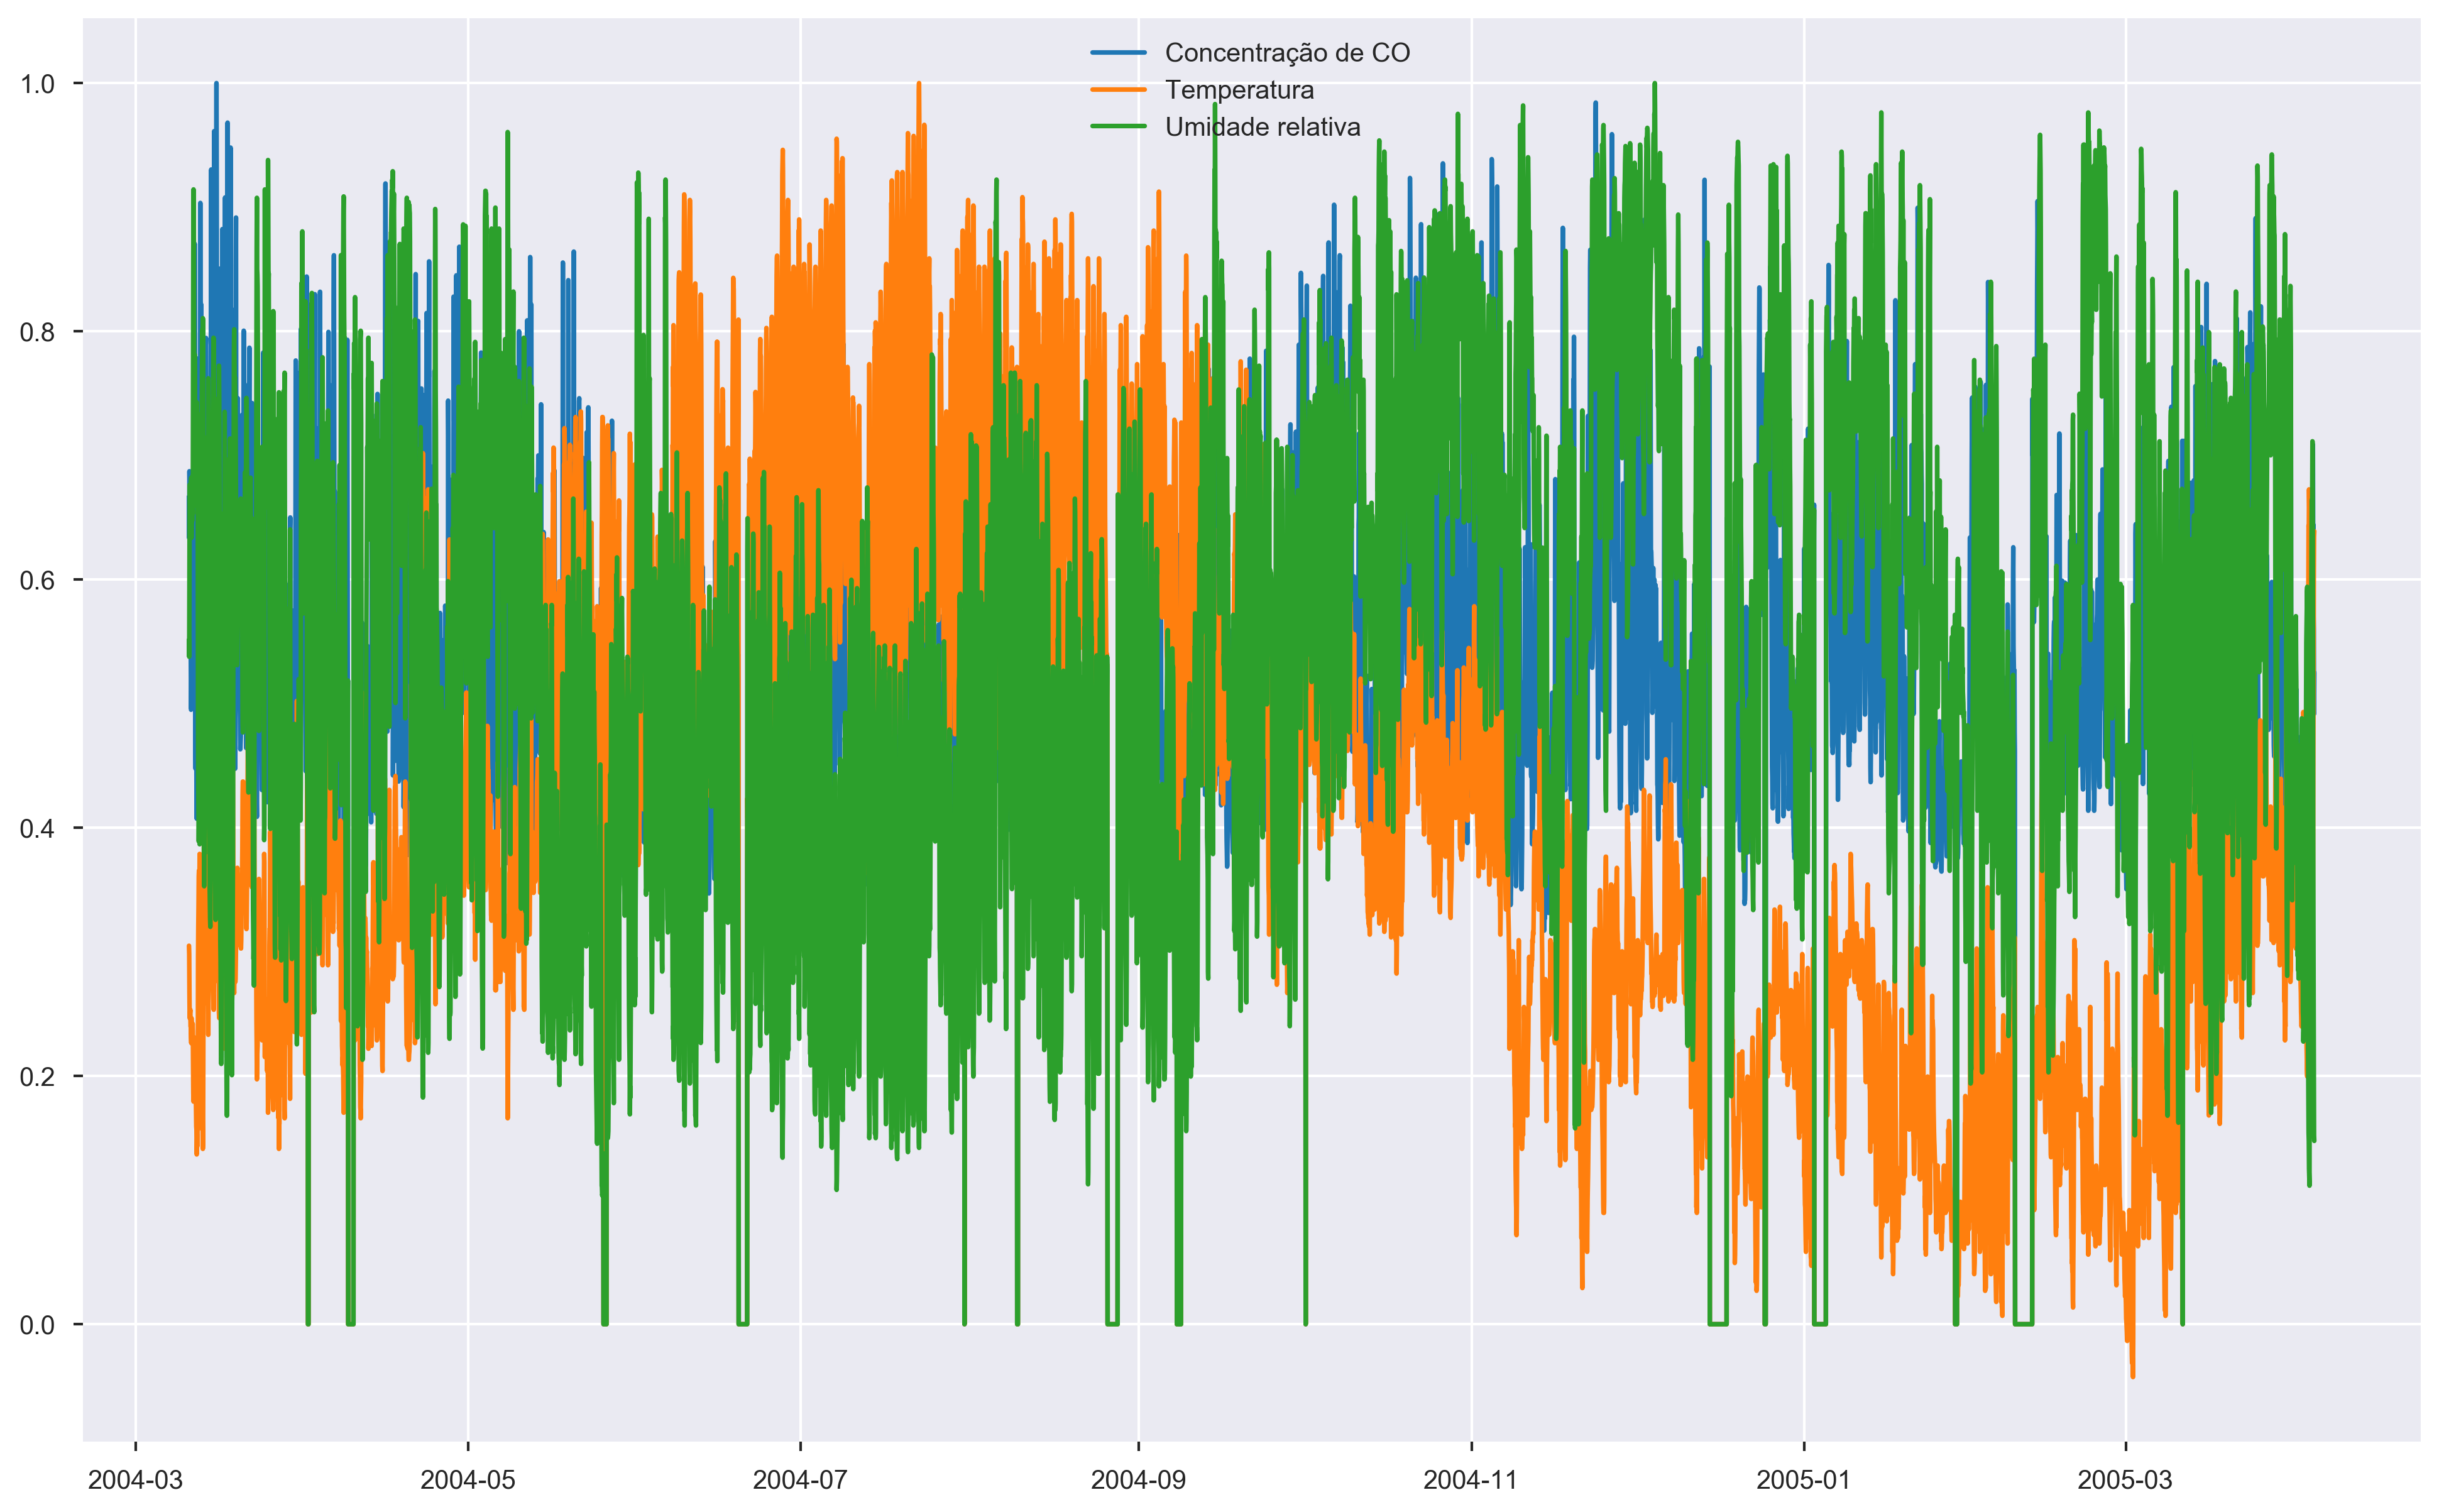

In [33]:
plt.figure(figsize=(16, 10))
plt.plot(air_quality_df.index, air_quality_df['PT08.S1(CO)'].replace({-200: 0}) / air_quality_df['PT08.S1(CO)'].max())
plt.plot(air_quality_df.index, air_quality_df['T'].replace({-200: 0}) / air_quality_df['T'].max())
plt.plot(air_quality_df.index, air_quality_df['RH'].replace({-200: 0}) / air_quality_df['RH'].max())
plt.legend(['Concentração de CO', 'Temperatura', 'Umidade relativa'])
plt.grid(True)
plt.show()

### Mapa de correlações

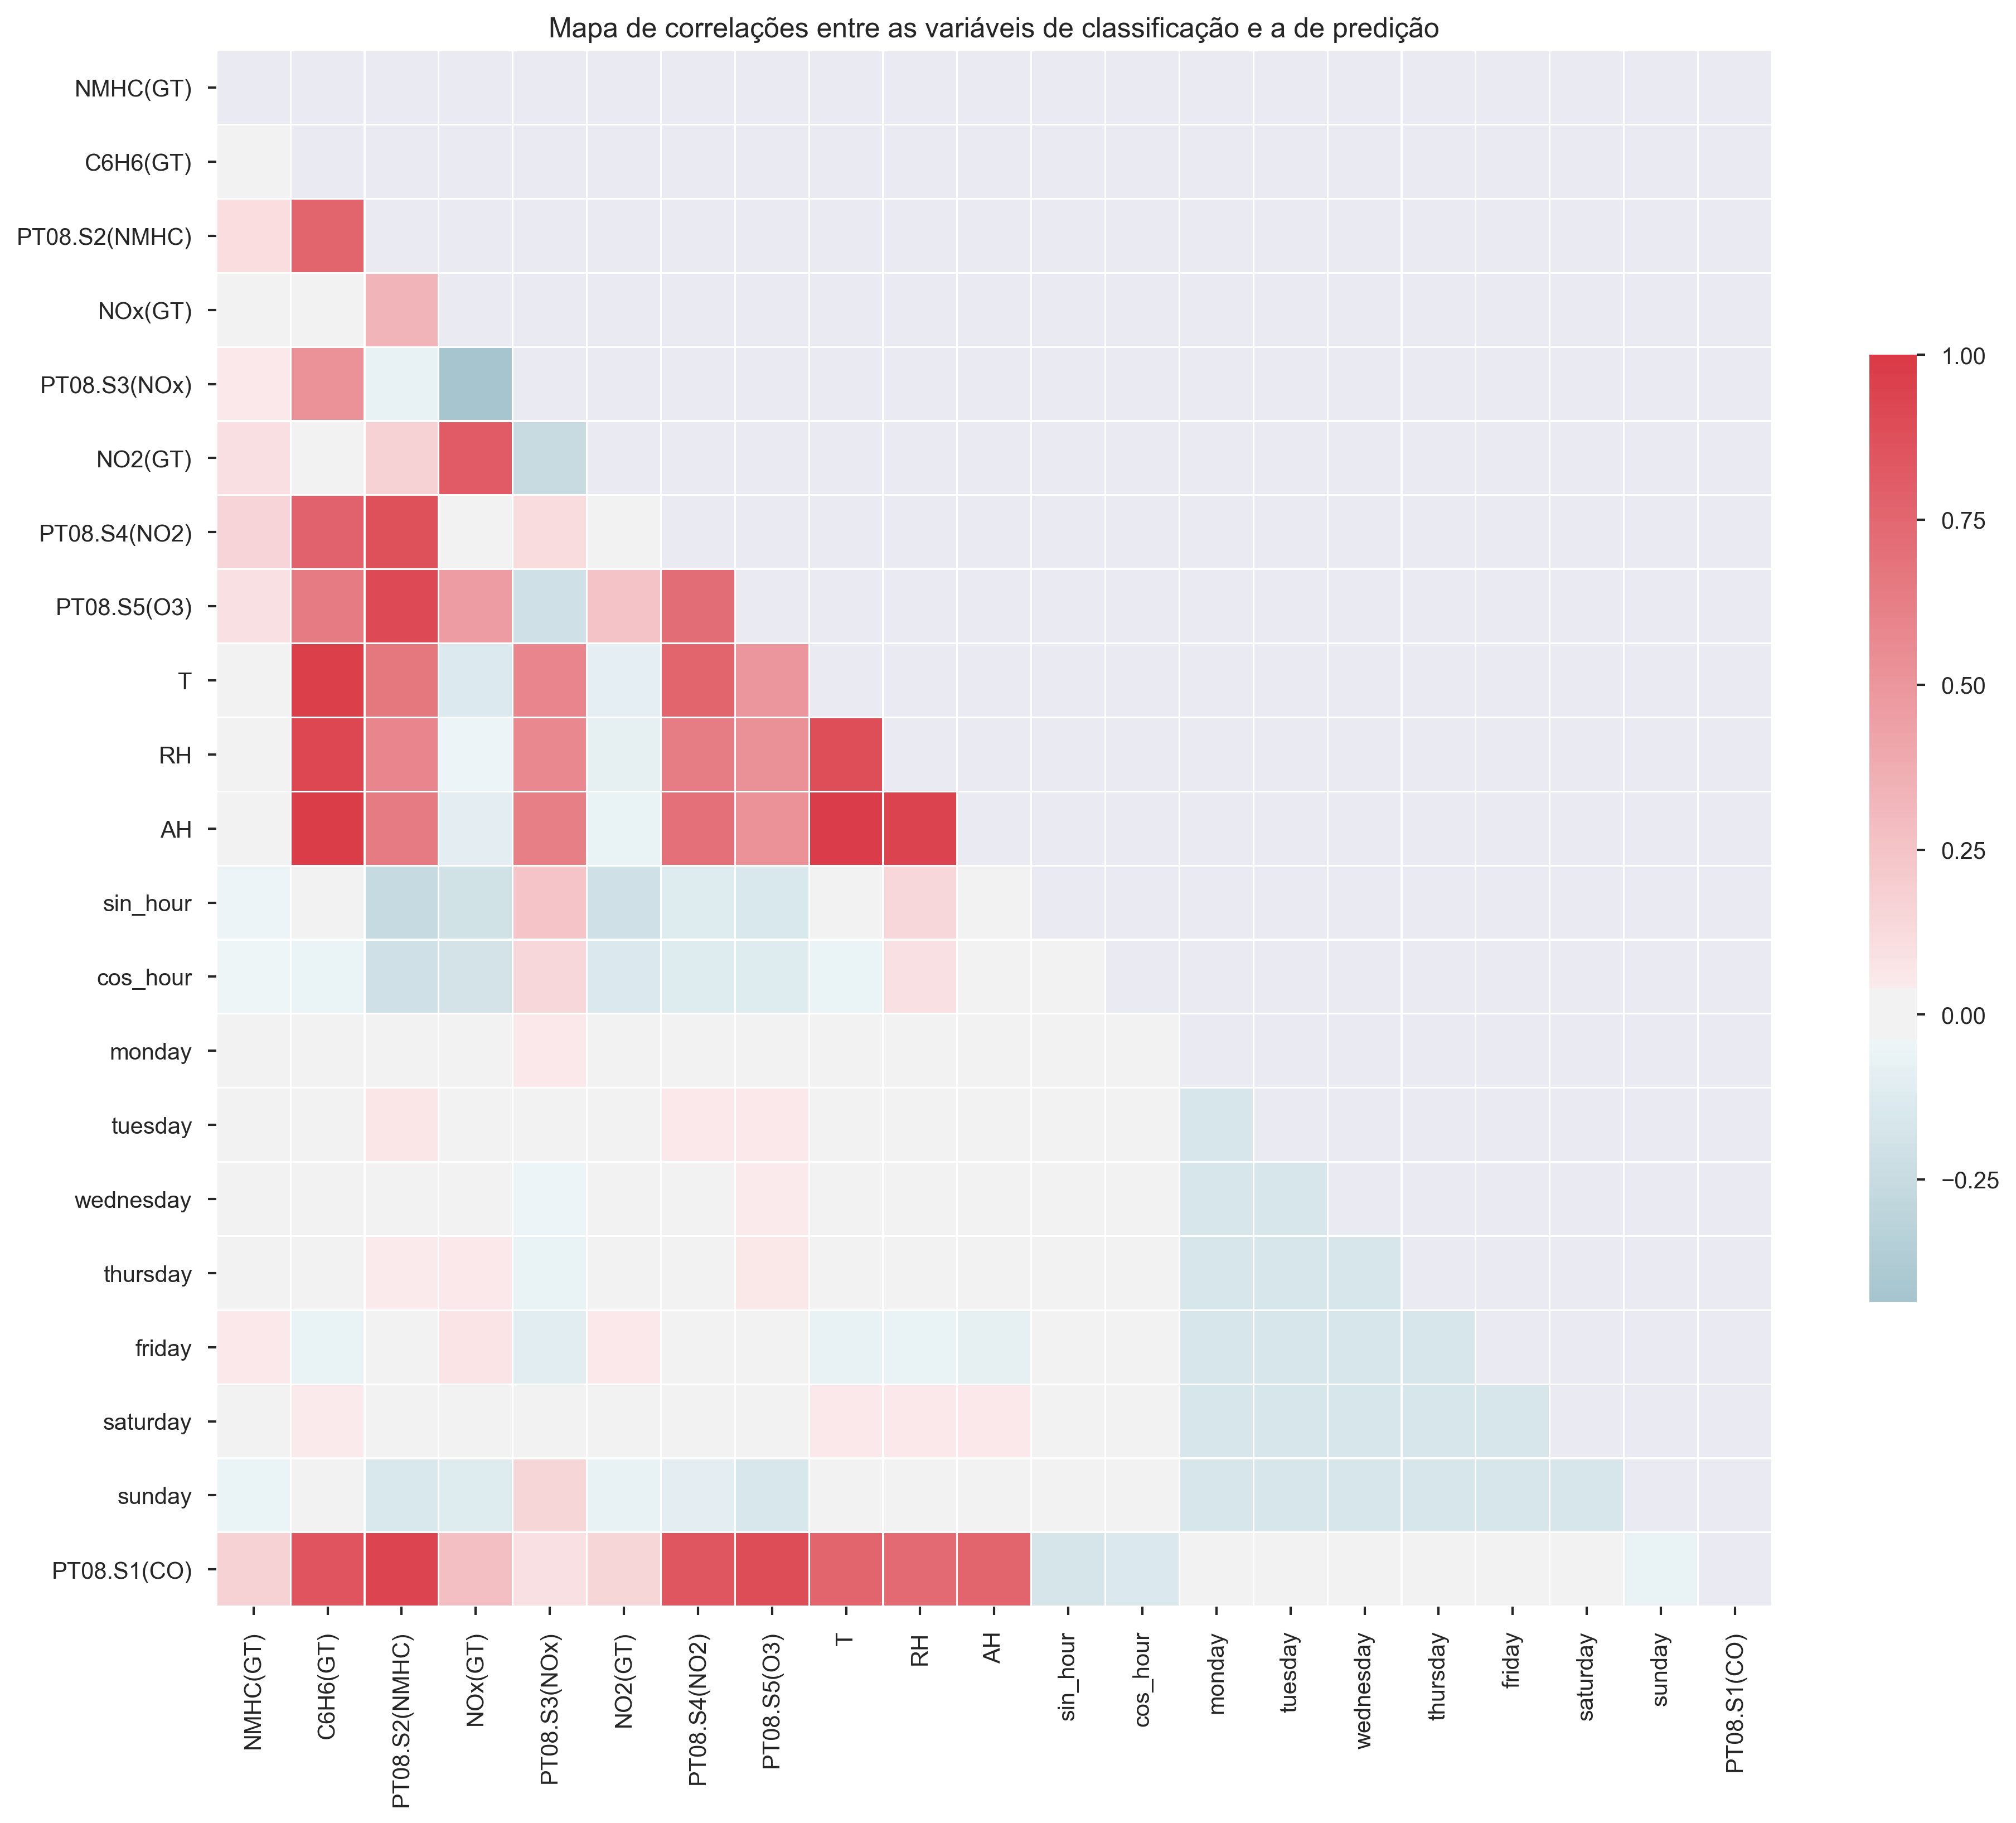

In [35]:
corr = air_quality_df[FEATURES + ['PT08.S1(CO)']].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 15))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Mapa de correlações entre as variáveis de classificação e a de predição')
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [36]:
corr['PT08.S1(CO)'].sort_values(ascending=False)

PT08.S1(CO)      1.000000
PT08.S2(NMHC)    0.933102
PT08.S5(O3)      0.892434
C6H6(GT)         0.852687
PT08.S4(NO2)     0.845149
AH               0.764903
T                0.754844
RH               0.745375
NOx(GT)          0.277993
NMHC(GT)         0.170007
NO2(GT)          0.154030
PT08.S3(NOx)     0.087019
saturday         0.031807
tuesday          0.029210
thursday         0.026679
wednesday        0.003409
friday          -0.008704
monday          -0.012011
sunday          -0.070187
cos_hour        -0.142968
sin_hour        -0.174421
Name: PT08.S1(CO), dtype: float64

Como podemos ver, as 4 variáveis mais correlacionadas com a variável de predição (`PT08.S1(CO)`, concentração de gás carbônico) são, em ordem:
1. `PT08.S2(NMHC)` (concentração de hidrocarbonetos, eliminados por automóveis da mesma maneira que o CO);
2. `PT08.S5(O3)` (concentração de ozônio, poluente secundário formado a partir de outros gases emitidos por automóveis);
3. `C6H6(GT)` (concentração de benzeno, hidrocarbonieto eliminado por automóveis);
4. `PT08.S4(NO2)` (concentração de dióxido de nitrogênio, poluente secundário originado de outros gases emitidos por automóveis).

As altas correlações são coerentes com a ideia de que gases poluentes (tanto primários, como o CO, quanto secundários) são eliminados e formados juntos, pelo processo de combustão dos motores de automóveis movidos a combustíveis fósseis.

## Modelos preditivos

Os algoritmos que testaremos são:
- Regressão linear;
- Random forest;
- XGBoost.

Para cada modelo, vamos avaliar:
1. A raiz do erro quadrático médio (RMSE);
2. Coeficiente de determinação ($R^{2}$);
3. Gráfico dos resíduos (residual plots);

### Separação de conjuntos para validação cruzada

Ao separar os conjuntos para validação cruzada, vamos tomar o cuidado de que medições de um mesmo dia não apareçam em mais de um conjunto de validação. Com isso vamos evitar que algum viés das medições de um mesmo dia mascare a performance dos modelos.

In [84]:
def get_n_folds_no_day_repetition(df, n_folds=5):
    '''
    Split table in n folds so that the a records' day 
    doesn't appear in more than a fold
    
    Inputs:
    - df: the dataframe from which we get the elements for the folds
    - n_folds: the number of folds
    
    Output:
    - folds: list of folds with no day repetition between them. Each fold contains
    one dataframe index list
    '''
    unique_days = df['Date'].unique().tolist()
    shuffle(unique_days)
    number_of_days = len(unique_days)
    fold_size = math.ceil(number_of_days / n_folds)
    folds = [df[df['Date'].isin(unique_days[i:(i + fold_size)])].index for i in range(0, number_of_days, fold_size)]
    
    return folds

### Regressão linear

In [86]:
air_quality_df_lr = air_quality_df.copy()

In [87]:
air_quality_df_lr.replace({-200: None}, inplace=True)

Como o modelo de regressão linear não lida com valores faltantes, vamos preenchê-los com as médias das respectivas colunas.

In [96]:
air_quality_df_lr['NO2(GT)'] = air_quality_df_lr['NO2(GT)'].fillna(air_quality_df_lr['NO2(GT)'].mean())

In [97]:
air_quality_df_lr['NOx(GT)'] = air_quality_df_lr['NOx(GT)'].fillna(air_quality_df_lr['NOx(GT)'].mean())

In [92]:
scaler = StandardScaler()
air_quality_df_lr[FEATURES] = scaler.fit_transform(air_quality_df_lr[FEATURES])

In [93]:
N_FOLDS = 8

In [142]:
folds = get_n_folds_no_day_repetition(air_quality_df, n_folds=N_FOLDS)
y_test_all = []
y_pred_all = []

for i in range(N_FOLDS):
    train_indexes = [index for k, indexes in enumerate(folds) if k != i for index in indexes]
    test_indexes = folds[i]
    
    X_train = air_quality_df_lr[FEATURES].loc[train_indexes].values
    y_train = air_quality_df_lr['PT08.S1(CO)'].loc[train_indexes].values
    
    X_test = air_quality_df_lr[FEATURES].loc[test_indexes].values
    y_test = air_quality_df_lr['PT08.S1(CO)'].loc[test_indexes].values
    
#     print(X_train.shape, X_test.shape)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    y_test_all.extend(y_test)
    y_pred_all.extend(y_pred)
    
print('*** RESULTADOS ***')
print('RMSE:', math.sqrt(mean_squared_error(y_test_all, y_pred_all)))
print('R^2:', r2_score(y_test_all, y_pred_all))

*** RESULTADOS ***
RMSE: 70.04886489511985
R^2: 0.8958616396699409


In [101]:
X = air_quality_df_lr[FEATURES].values
y = air_quality_df_lr['PT08.S1(CO)'].values

In [102]:
final_model = LinearRegression()
final_model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [103]:
final_model.intercept_

1099.8331664998332

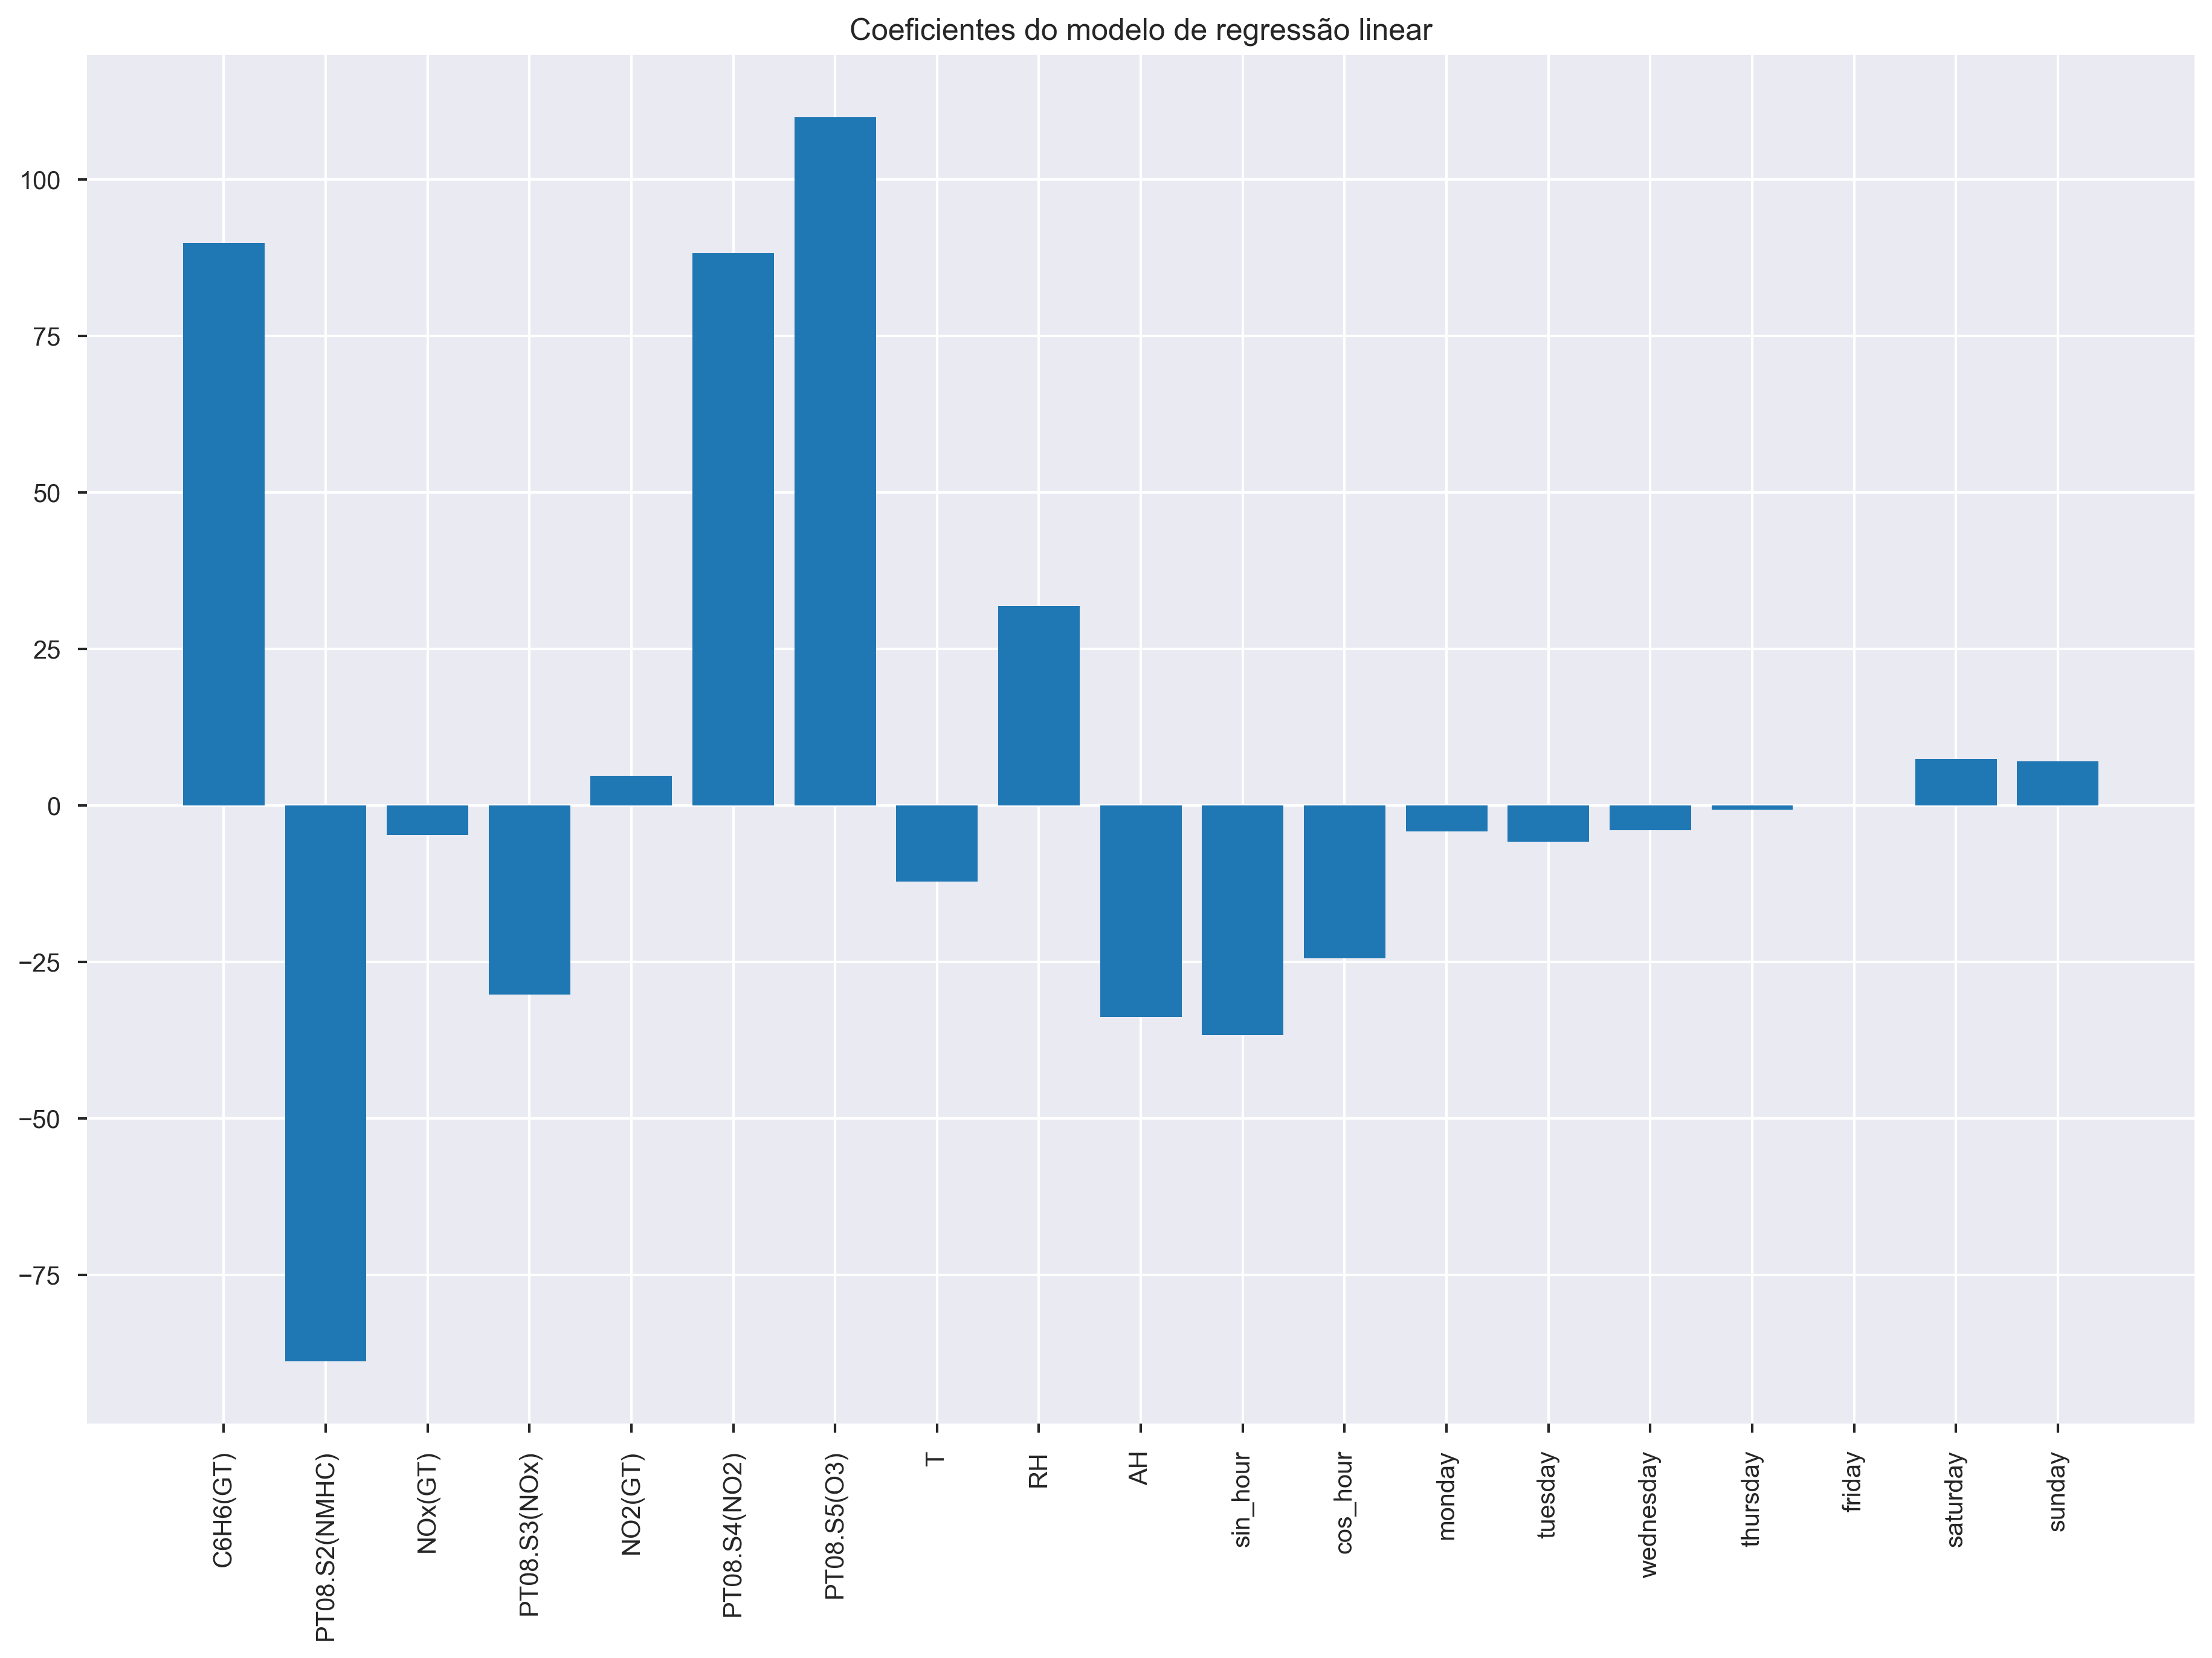

In [105]:
plt.figure(figsize=(15, 10))
plt.title('Coeficientes do modelo de regressão linear')
plt.bar(FEATURES, final_model.coef_)
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

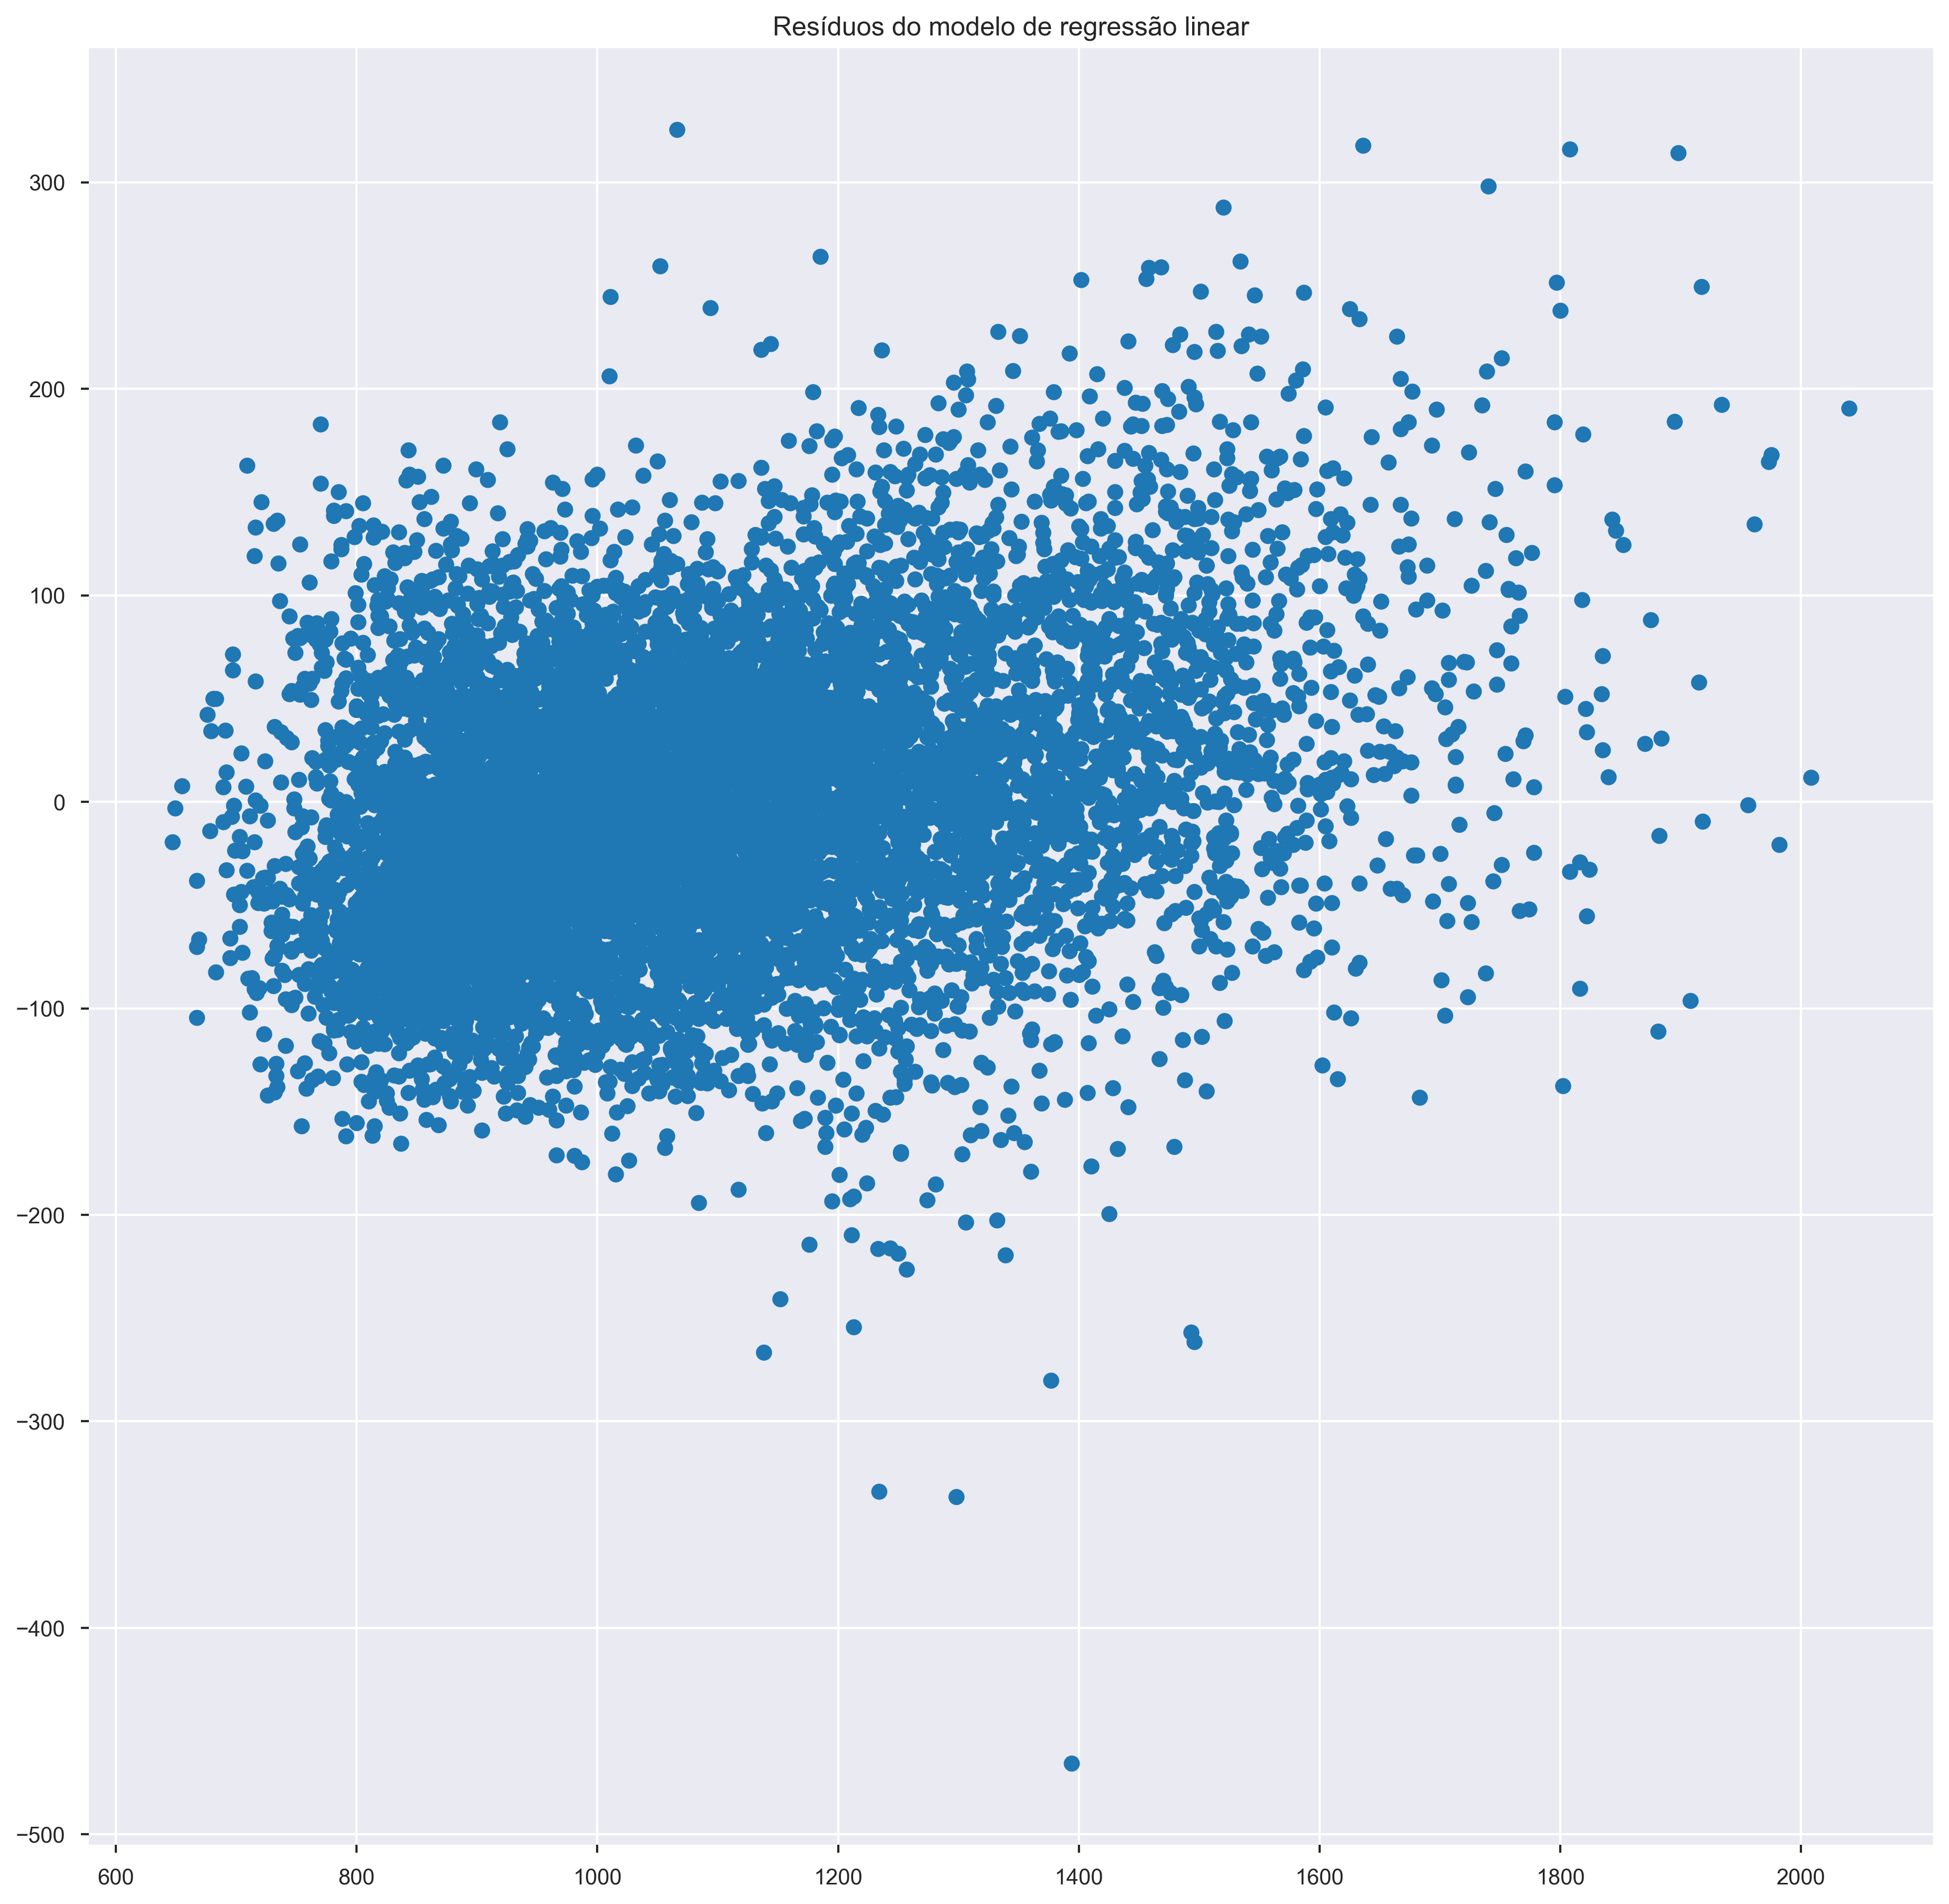

In [106]:
plt.figure(figsize=(15, 15))
plt.title('Resíduos do modelo de regressão linear')
plt.scatter(y_test_all, np.asarray(y_test_all) - np.asarray(y_pred_all))
plt.grid(True)
plt.show()

Notamos que a distribuição dos resíduos é aleatória e tende a ser gaussiana, portanto o modelo não está simples demais.

### Random forest

Vamos realizar uma *random search* (busca aleatória) para definir o conjunto ótimo de hiperparâmetros para nosso modelo.

In [249]:
NUM_SEARCH_ITERATIONS = 100

In [109]:
air_quality_df_tree = air_quality_df.copy()

In [252]:
n_estimators = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500]
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50]
min_samples_leaf = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9, 10]

In [253]:
random_search_cols = [
    'n_estimators', 'max_depth', 'min_samples_leaf', 'min_samples_split', 
    'rmse', 'r2_score',
]

rf_random_search = pd.DataFrame(columns=random_search_cols)

In [254]:
hyperparams_options = list(product(n_estimators, max_depth, min_samples_leaf, min_samples_split))

In [255]:
shuffle(hyperparams_options)

In [256]:
for ne, md, msl, mss in tqdm_notebook(hyperparams_options[:NUM_SEARCH_ITERATIONS], desc='Params'):

    folds = get_n_folds_no_day_repetition(air_quality_df, n_folds=N_FOLDS)
    y_test_all = []
    y_pred_all = []

    for i in range(N_FOLDS):
        train_indexes = [index for k, indexes in enumerate(folds) if k != i for index in indexes]
        test_indexes = folds[i]

        X_train = air_quality_df_tree[FEATURES].loc[train_indexes].values
        y_train = air_quality_df_tree['PT08.S1(CO)'].loc[train_indexes].values

        X_test = air_quality_df_tree[FEATURES].loc[test_indexes].values
        y_test = air_quality_df_tree['PT08.S1(CO)'].loc[test_indexes].values

        model = RandomForestRegressor(
            n_estimators=ne,
            max_depth=md,
            min_samples_leaf=msl,
            min_samples_split=mss,
            random_state=42
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        y_test_all.extend(y_test)
        y_pred_all.extend(y_pred)
    
    rmse = math.sqrt(mean_squared_error(y_test_all, y_pred_all))
    r2 = r2_score(y_test_all, y_pred_all)
        
    data = [
        ne, md, msl, mss,
        rmse, r2
    ]
    
    rf_random_search = rf_random_search.append(
        pd.Series(index=random_search_cols, data=data), 
        ignore_index=True
    )

HBox(children=(IntProgress(value=0, description='Params'), HTML(value='')))

In [257]:
rf_random_search[rf_random_search['rmse'] == rf_random_search['rmse'].min()]

n_estimators  max_depth  min_samples_leaf  min_samples_split       rmse  \
90         300.0       50.0               2.0                7.0  55.684365   

    r2_score  
90  0.934193

In [258]:
rf_random_search[rf_random_search['r2_score'] == rf_random_search['r2_score'].max()]

n_estimators  max_depth  min_samples_leaf  min_samples_split       rmse  \
90         300.0       50.0               2.0                7.0  55.684365   

    r2_score  
90  0.934193

O mesmo conjunto de hiperparâmetros nos trouxe menor RMSE e máximo $R^2$, portanto vamos usá-lo para configurar nosso modelo definitivo.

In [107]:
N_ESTIMATORS = 300
MAX_DEPTH = 50
MIN_SAMPLES_LEAF = 2
MIN_SAMPLES_SPLIT = 7

Vamos treinar um modelo com todo o conjunto de dados para analisarmos **a importância de cada variável**:

In [112]:
X = air_quality_df_tree[FEATURES].values
y = air_quality_df_tree['PT08.S1(CO)'].values

In [113]:
model = RandomForestRegressor(
    n_estimators=N_ESTIMATORS,
    max_depth=MAX_DEPTH,
    min_samples_leaf=MIN_SAMPLES_LEAF,
    min_samples_split=MIN_SAMPLES_SPLIT,
    random_state=42
)

In [114]:
model.fit(X_train, y_train)
feature_importances = model.feature_importances_

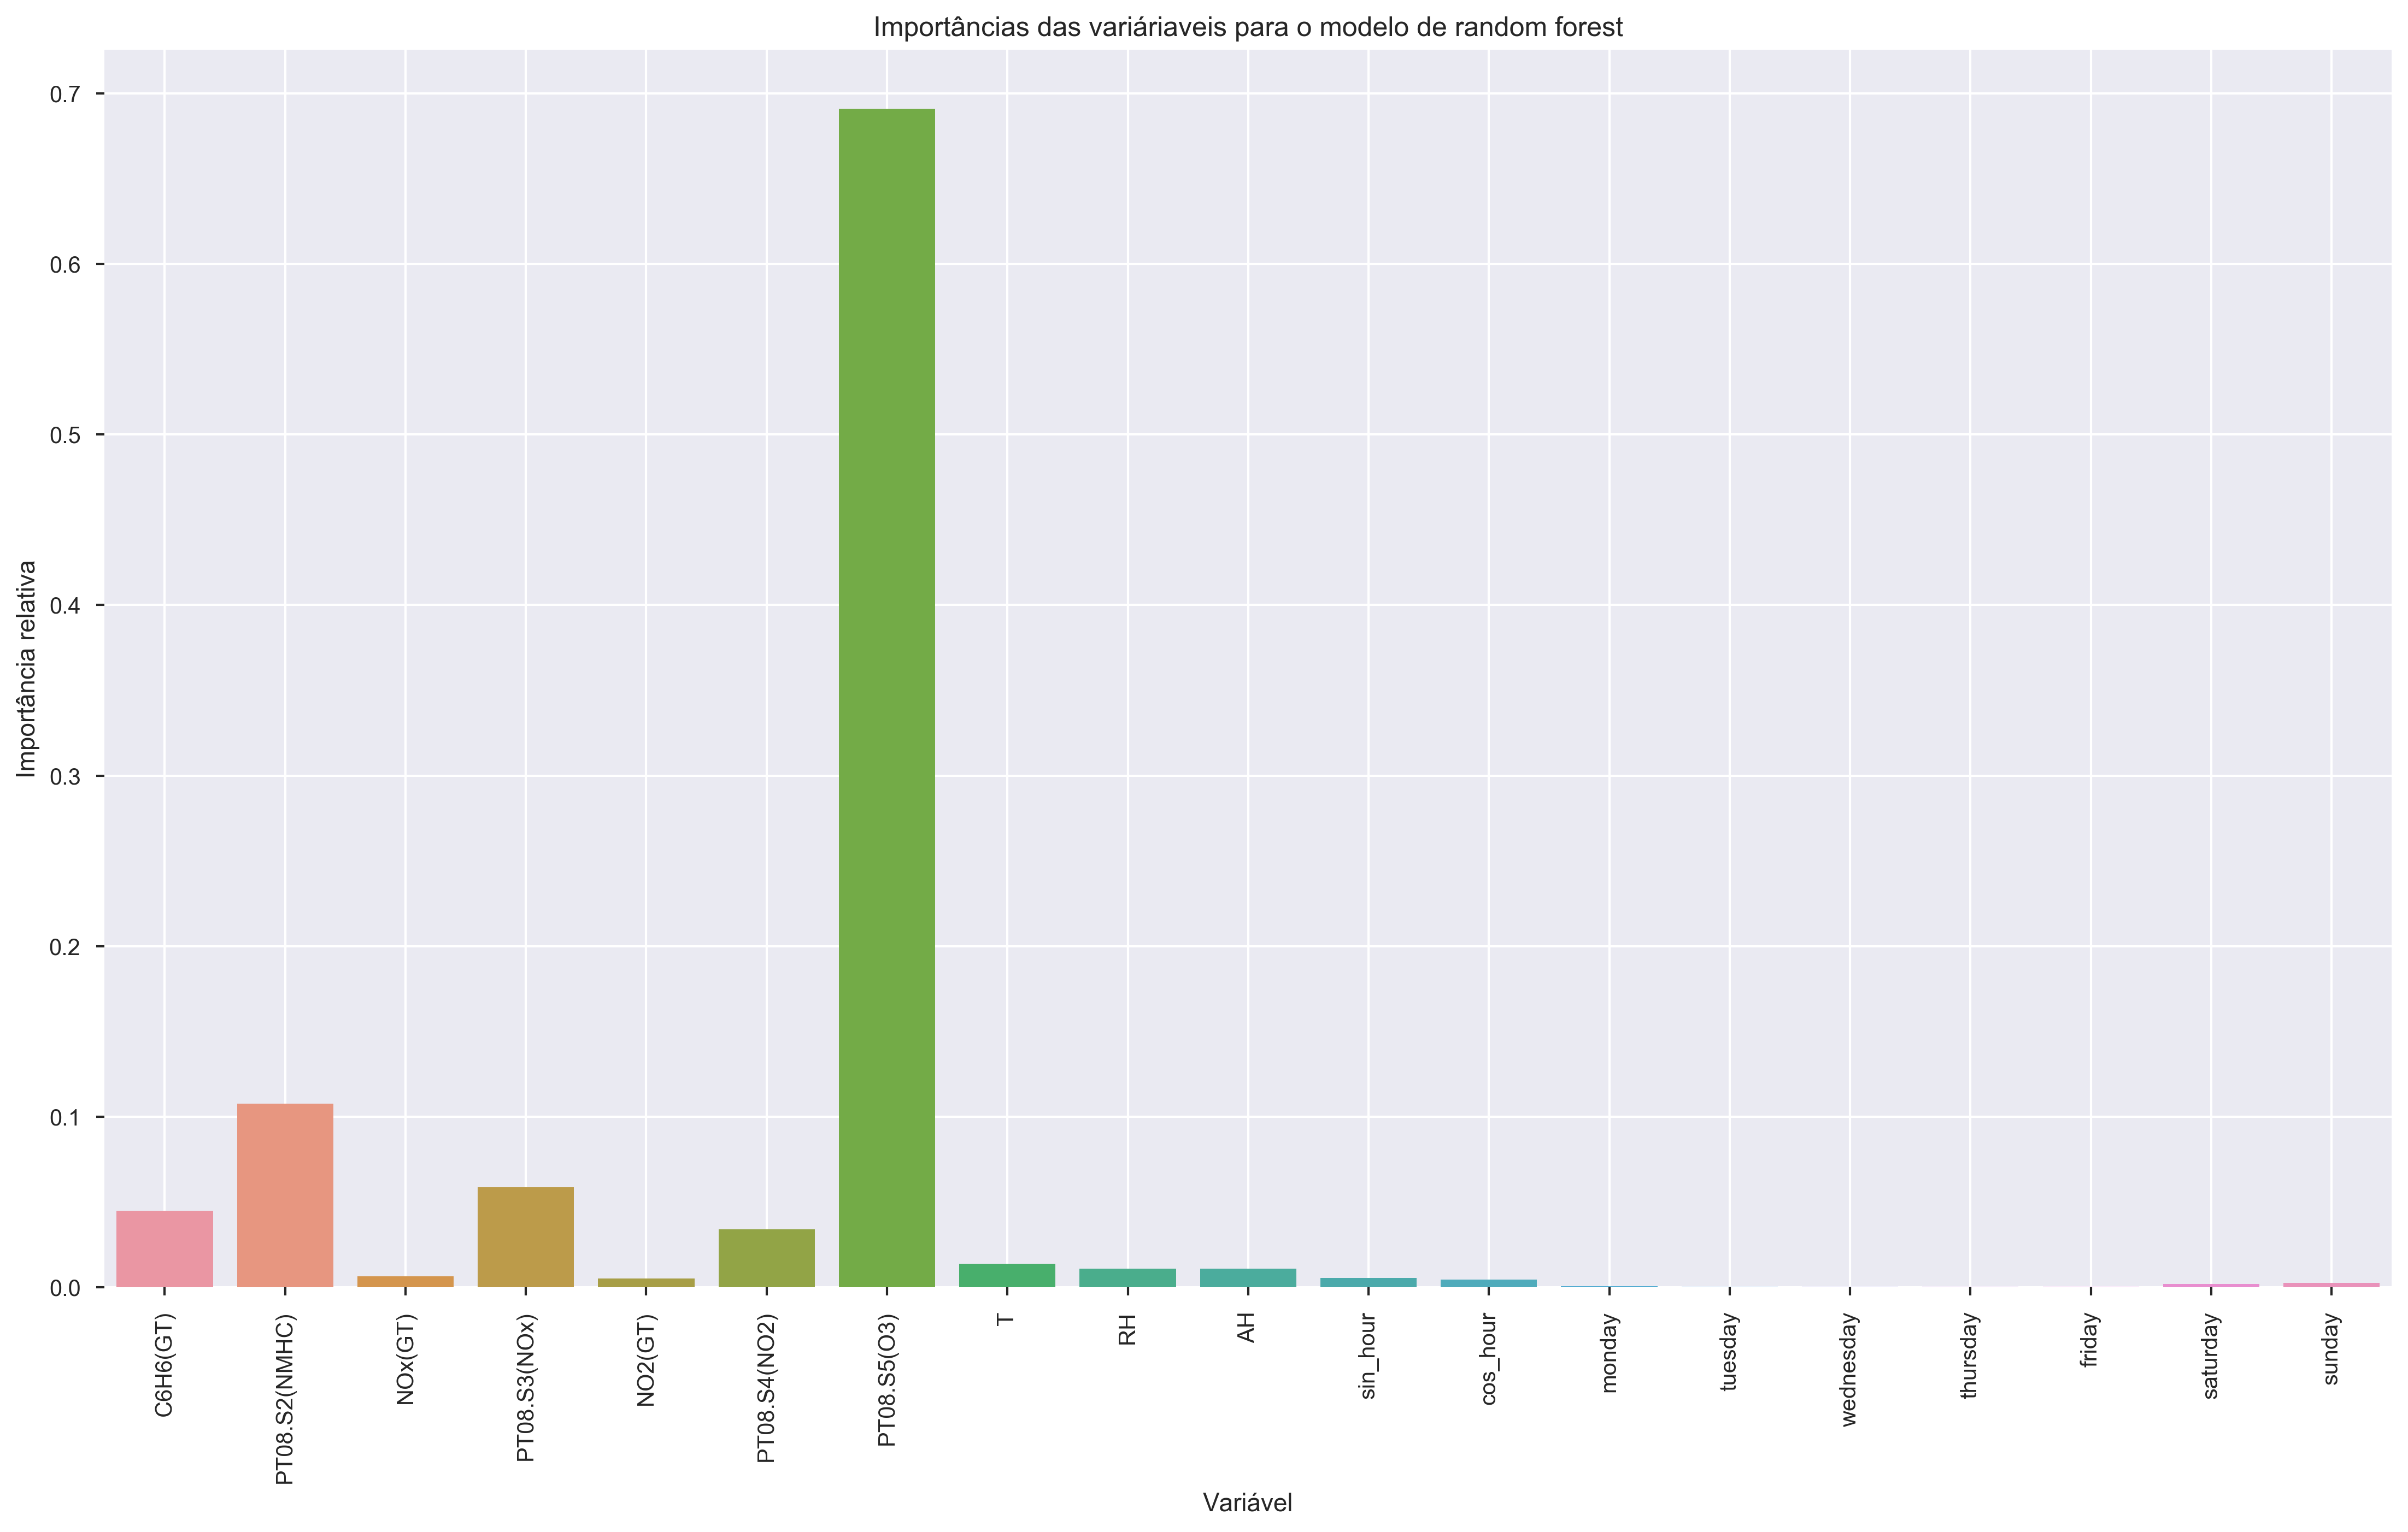

In [122]:
feature_importances_df = pd.DataFrame(
    {
        'Variável': FEATURES,
        'Importância relativa': feature_importances,
    }
)
plt.figure(figsize=(18, 10))
plt.title('Importâncias das variáriaveis para o modelo de random forest')
sns.barplot(x='Variável', y='Importância relativa', data=feature_importances_df)
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

Agora vamos avaliar a performance do modelo utilizando validação cruzada (como a separação do conjunto é diferente daquela utilizada na *random search*, pode ser que tenhamos diferenças nas métricas):

In [116]:
folds = get_n_folds_no_day_repetition(air_quality_df, n_folds=N_FOLDS)
y_test_all = []
y_pred_all = []

for i in range(N_FOLDS):
    train_indexes = [index for k, indexes in enumerate(folds) if k != i for index in indexes]
    test_indexes = folds[i]

    X_train = air_quality_df_tree[FEATURES].loc[train_indexes].values
    y_train = air_quality_df_tree['PT08.S1(CO)'].loc[train_indexes].values

    X_test = air_quality_df_tree[FEATURES].loc[test_indexes].values
    y_test = air_quality_df_tree['PT08.S1(CO)'].loc[test_indexes].values

    model = RandomForestRegressor(
        n_estimators=N_ESTIMATORS,
        max_depth=MAX_DEPTH,
        min_samples_leaf=MIN_SAMPLES_LEAF,
        min_samples_split=MIN_SAMPLES_SPLIT,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_test_all.extend(y_test)
    y_pred_all.extend(y_pred)

In [117]:
print('*** RESULTADOS ***')
print('RMSE:', math.sqrt(mean_squared_error(y_test_all, y_pred_all)))
print('R^2:', r2_score(y_test_all, y_pred_all))

*** RESULTADOS ***
RMSE: 55.849913020600106
R^2: 0.9338006792615297


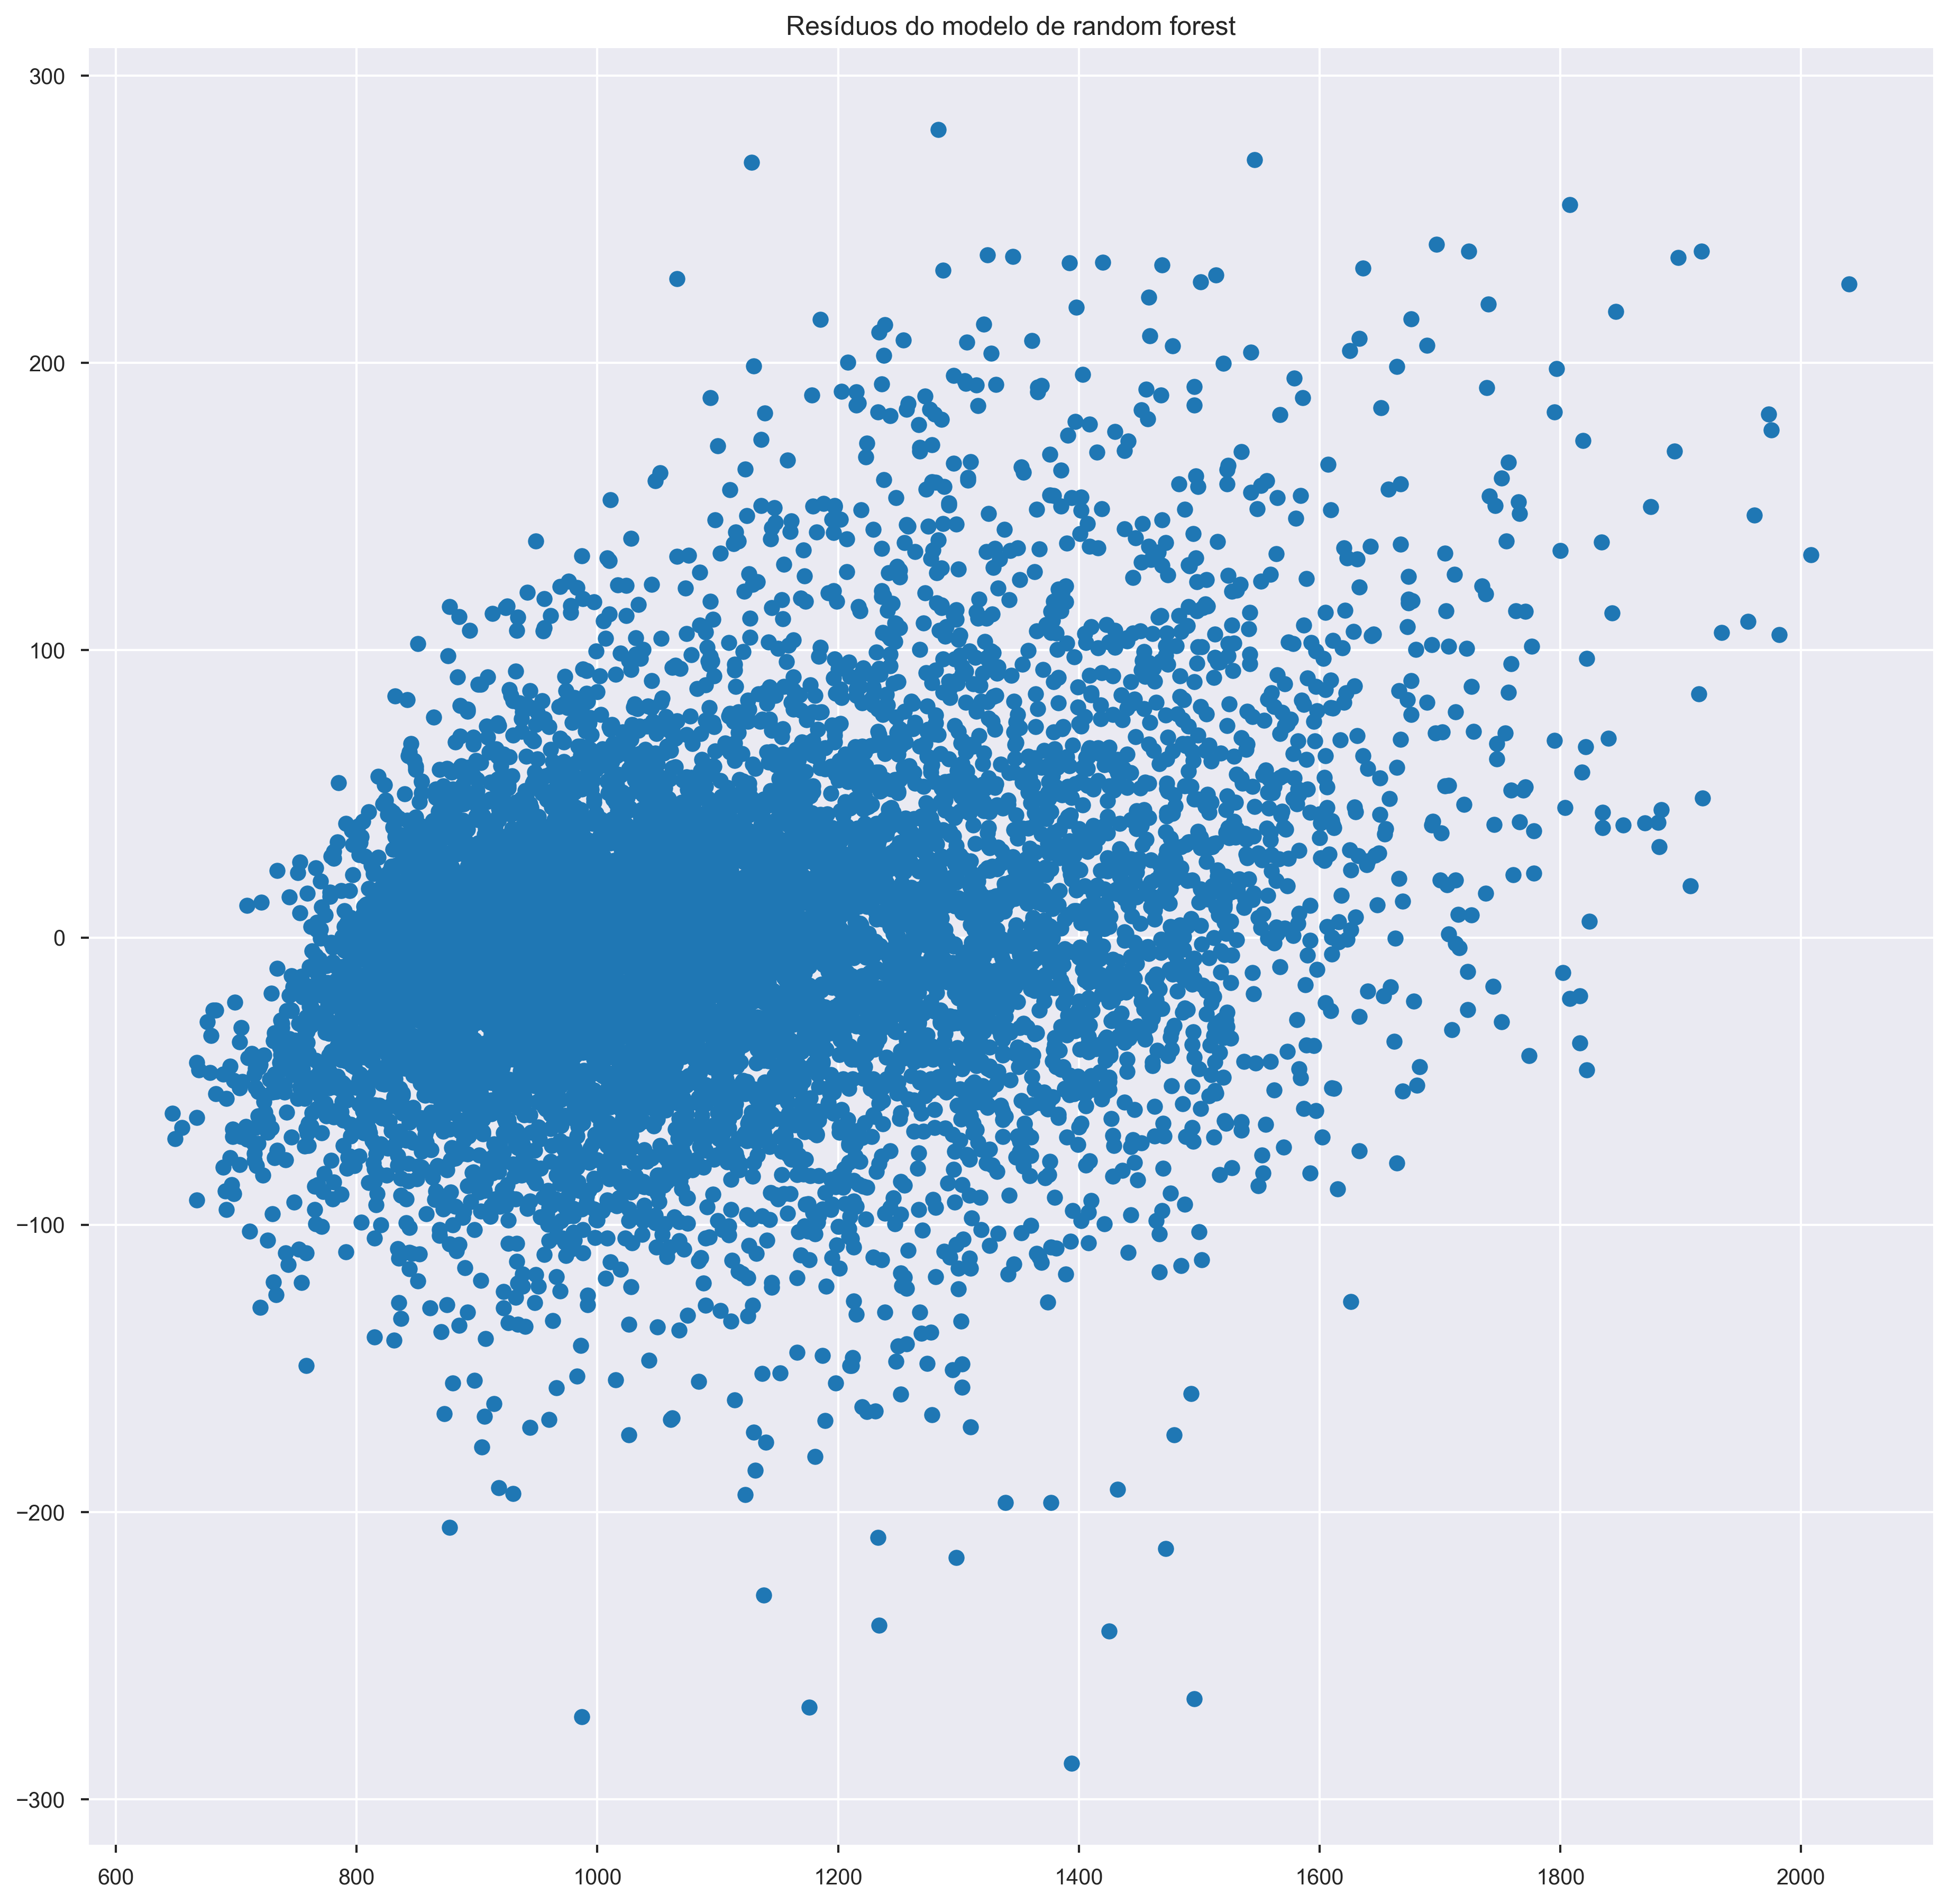

In [118]:
plt.figure(figsize=(15, 15))
plt.title('Resíduos do modelo de random forest')
plt.scatter(y_test_all, np.asarray(y_test_all) - np.asarray(y_pred_all))
plt.grid(True)
plt.show()

Mais uma vez, a distribuição dos resíduos é aleatória e tende a ser gaussiana, portanto o modelo não está simples demais.

### XGBoost

Vamos realizar uma *random search* (busca aleatória) para definir o conjunto ótimo de hiperparâmetros para nosso modelo.

In [209]:
NUM_SEARCH_ITERATIONS = 100

In [124]:
air_quality_df_tree = air_quality_df.copy()

In [226]:
n_estimators = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500]
max_depth = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50]
colsample_bytree = [0.5, 0.6, 0.7, 0.8, 0.9, 1]
subsample = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [232]:
random_search_cols = [
    'n_estimators', 'max_depth', 'colsample_bytree', 'subsample', 
    'rmse', 'r2_score'
]

xgb_random_search = pd.DataFrame(columns=random_search_cols)

In [228]:
hyperparams_options = list(product(n_estimators, max_depth, colsample_bytree, subsample))

In [229]:
shuffle(hyperparams_options)

In [233]:
for ne, md, cs, ss in tqdm_notebook(hyperparams_options[:NUM_SEARCH_ITERATIONS], desc='Params'):

    folds = get_n_folds_no_day_repetition(air_quality_df, n_folds=N_FOLDS)
    y_test_all = []
    y_pred_all = []

    for i in range(N_FOLDS):
        train_indexes = [index for k, indexes in enumerate(folds) if k != i for index in indexes]
        test_indexes = folds[i]

        X_train = air_quality_df_tree[FEATURES].loc[train_indexes].values
        y_train = air_quality_df_tree['PT08.S1(CO)'].loc[train_indexes].values

        X_test = air_quality_df_tree[FEATURES].loc[test_indexes].values
        y_test = air_quality_df_tree['PT08.S1(CO)'].loc[test_indexes].values

        model = XGBRegressor(
            n_estimators=ne,
            max_depth=md,
            colsample_bytree=cs,
            subsample=ss,
            seed=42
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        y_test_all.extend(y_test)
        y_pred_all.extend(y_pred)
    
    rmse = math.sqrt(mean_squared_error(y_test_all, y_pred_all))
    r2 = r2_score(y_test_all, y_pred_all)
        
    data = [
        ne, md, cs, ss,
        rmse, r2
    ]
    
    xgb_random_search = xgb_random_search.append(
        pd.Series(index=random_search_cols, data=data), 
        ignore_index=True
    )

HBox(children=(IntProgress(value=0, description='Params'), HTML(value='')))

Exception in thread Thread-21:
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.6.4_4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/heitor/Envs/master/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/heitor/Envs/master/bin/../lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [235]:
xgb_random_search[xgb_random_search['rmse'] == xgb_random_search['rmse'].min()]

n_estimators  max_depth  colsample_bytree  subsample       rmse  r2_score
94         300.0        6.0               1.0        0.5  53.234963  0.939855

In [236]:
xgb_random_search[xgb_random_search['r2_score'] == xgb_random_search['r2_score'].max()]

n_estimators  max_depth  colsample_bytree  subsample       rmse  r2_score
94         300.0        6.0               1.0        0.5  53.234963  0.939855

O mesmo conjunto de hiperparâmetros nos trouxe menor RMSE e máximo $R^2$, portanto vamos usá-lo para configurar nosso modelo definitivo.

In [125]:
N_ESTIMATORS = 300
MAX_DEPTH = 6
COLSAMPLE_BYTREE = 1
SUBSAMPLE = 0.5

Vamos treinar um modelo com todo o conjunto de dados para analisarmos **a importância de cada variável**:

In [126]:
X = air_quality_df_tree[FEATURES].values
y = air_quality_df_tree['PT08.S1(CO)'].values

In [127]:
model = XGBRegressor(
    n_estimators=N_ESTIMATORS,
    max_depth=MAX_DEPTH,
    colsample_bytree=COLSAMPLE_BYTREE,
    subsample=SUBSAMPLE,
    seed=42
)

In [128]:
model.fit(X_train, y_train)
feature_importances = model.feature_importances_

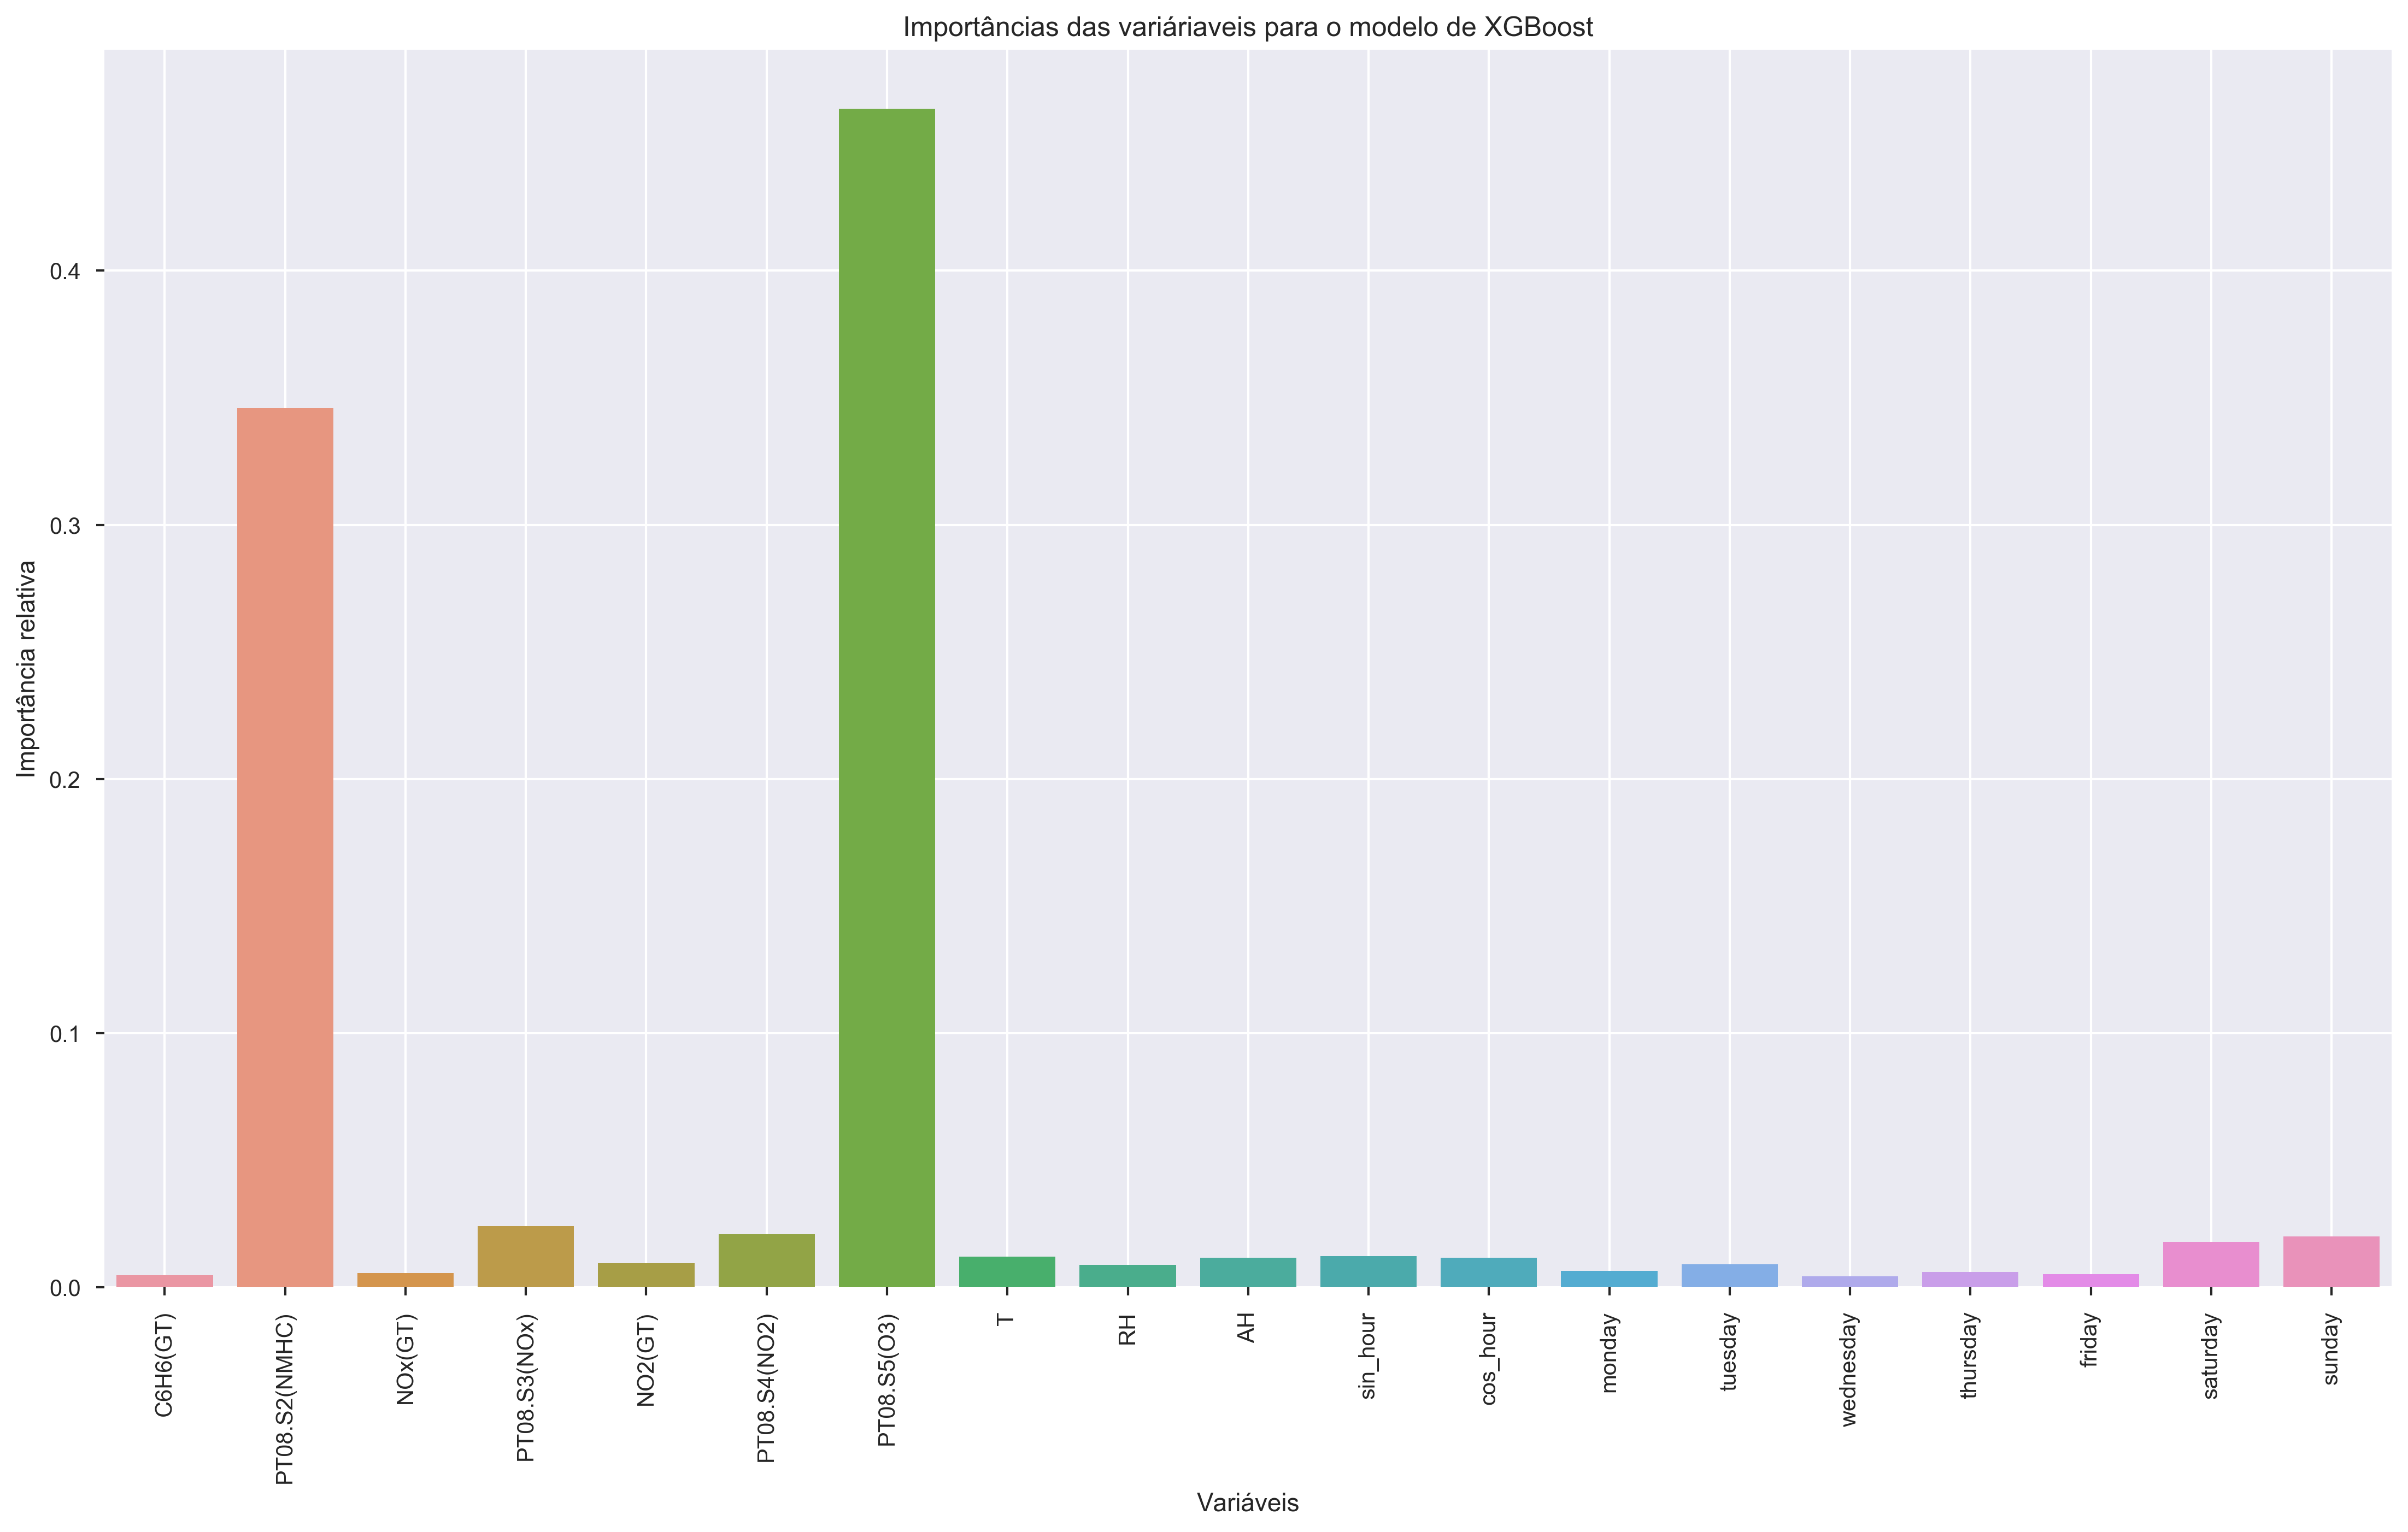

In [129]:
feature_importances_df = pd.DataFrame(
    {
        'Variáveis': FEATURES,
        'Importância relativa': feature_importances,
    }
)
plt.figure(figsize=(18, 10))
plt.title('Importâncias das variáriaveis para o modelo de XGBoost')
sns.barplot(x='Variáveis', y='Importância relativa', data=feature_importances_df)
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

Agora vamos avaliar a performance do modelo utilizando validação cruzada (como a separação do conjunto é diferente daquela utilizada na *random search*, pode ser que tenhamos diferenças nas métricas):

In [130]:
folds = get_n_folds_no_day_repetition(air_quality_df, n_folds=N_FOLDS)
y_test_all = []
y_pred_all = []

for i in range(N_FOLDS):
    train_indexes = [index for k, indexes in enumerate(folds) if k != i for index in indexes]
    test_indexes = folds[i]

    X_train = air_quality_df_tree[FEATURES].loc[train_indexes].values
    y_train = air_quality_df_tree['PT08.S1(CO)'].loc[train_indexes].values

    X_test = air_quality_df_tree[FEATURES].loc[test_indexes].values
    y_test = air_quality_df_tree['PT08.S1(CO)'].loc[test_indexes].values

    model = XGBRegressor(
        n_estimators=N_ESTIMATORS,
        max_depth=MAX_DEPTH,
        colsample_bytree=COLSAMPLE_BYTREE,
        subsample=SUBSAMPLE,
        seed=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_test_all.extend(y_test)
    y_pred_all.extend(y_pred)

In [131]:
print('*** RESULTADOS ***')
print('RMSE:', math.sqrt(mean_squared_error(y_test_all, y_pred_all)))
print('R^2:', r2_score(y_test_all, y_pred_all))

*** RESULTADOS ***
RMSE: 53.00461670922309
R^2: 0.9403739654009696


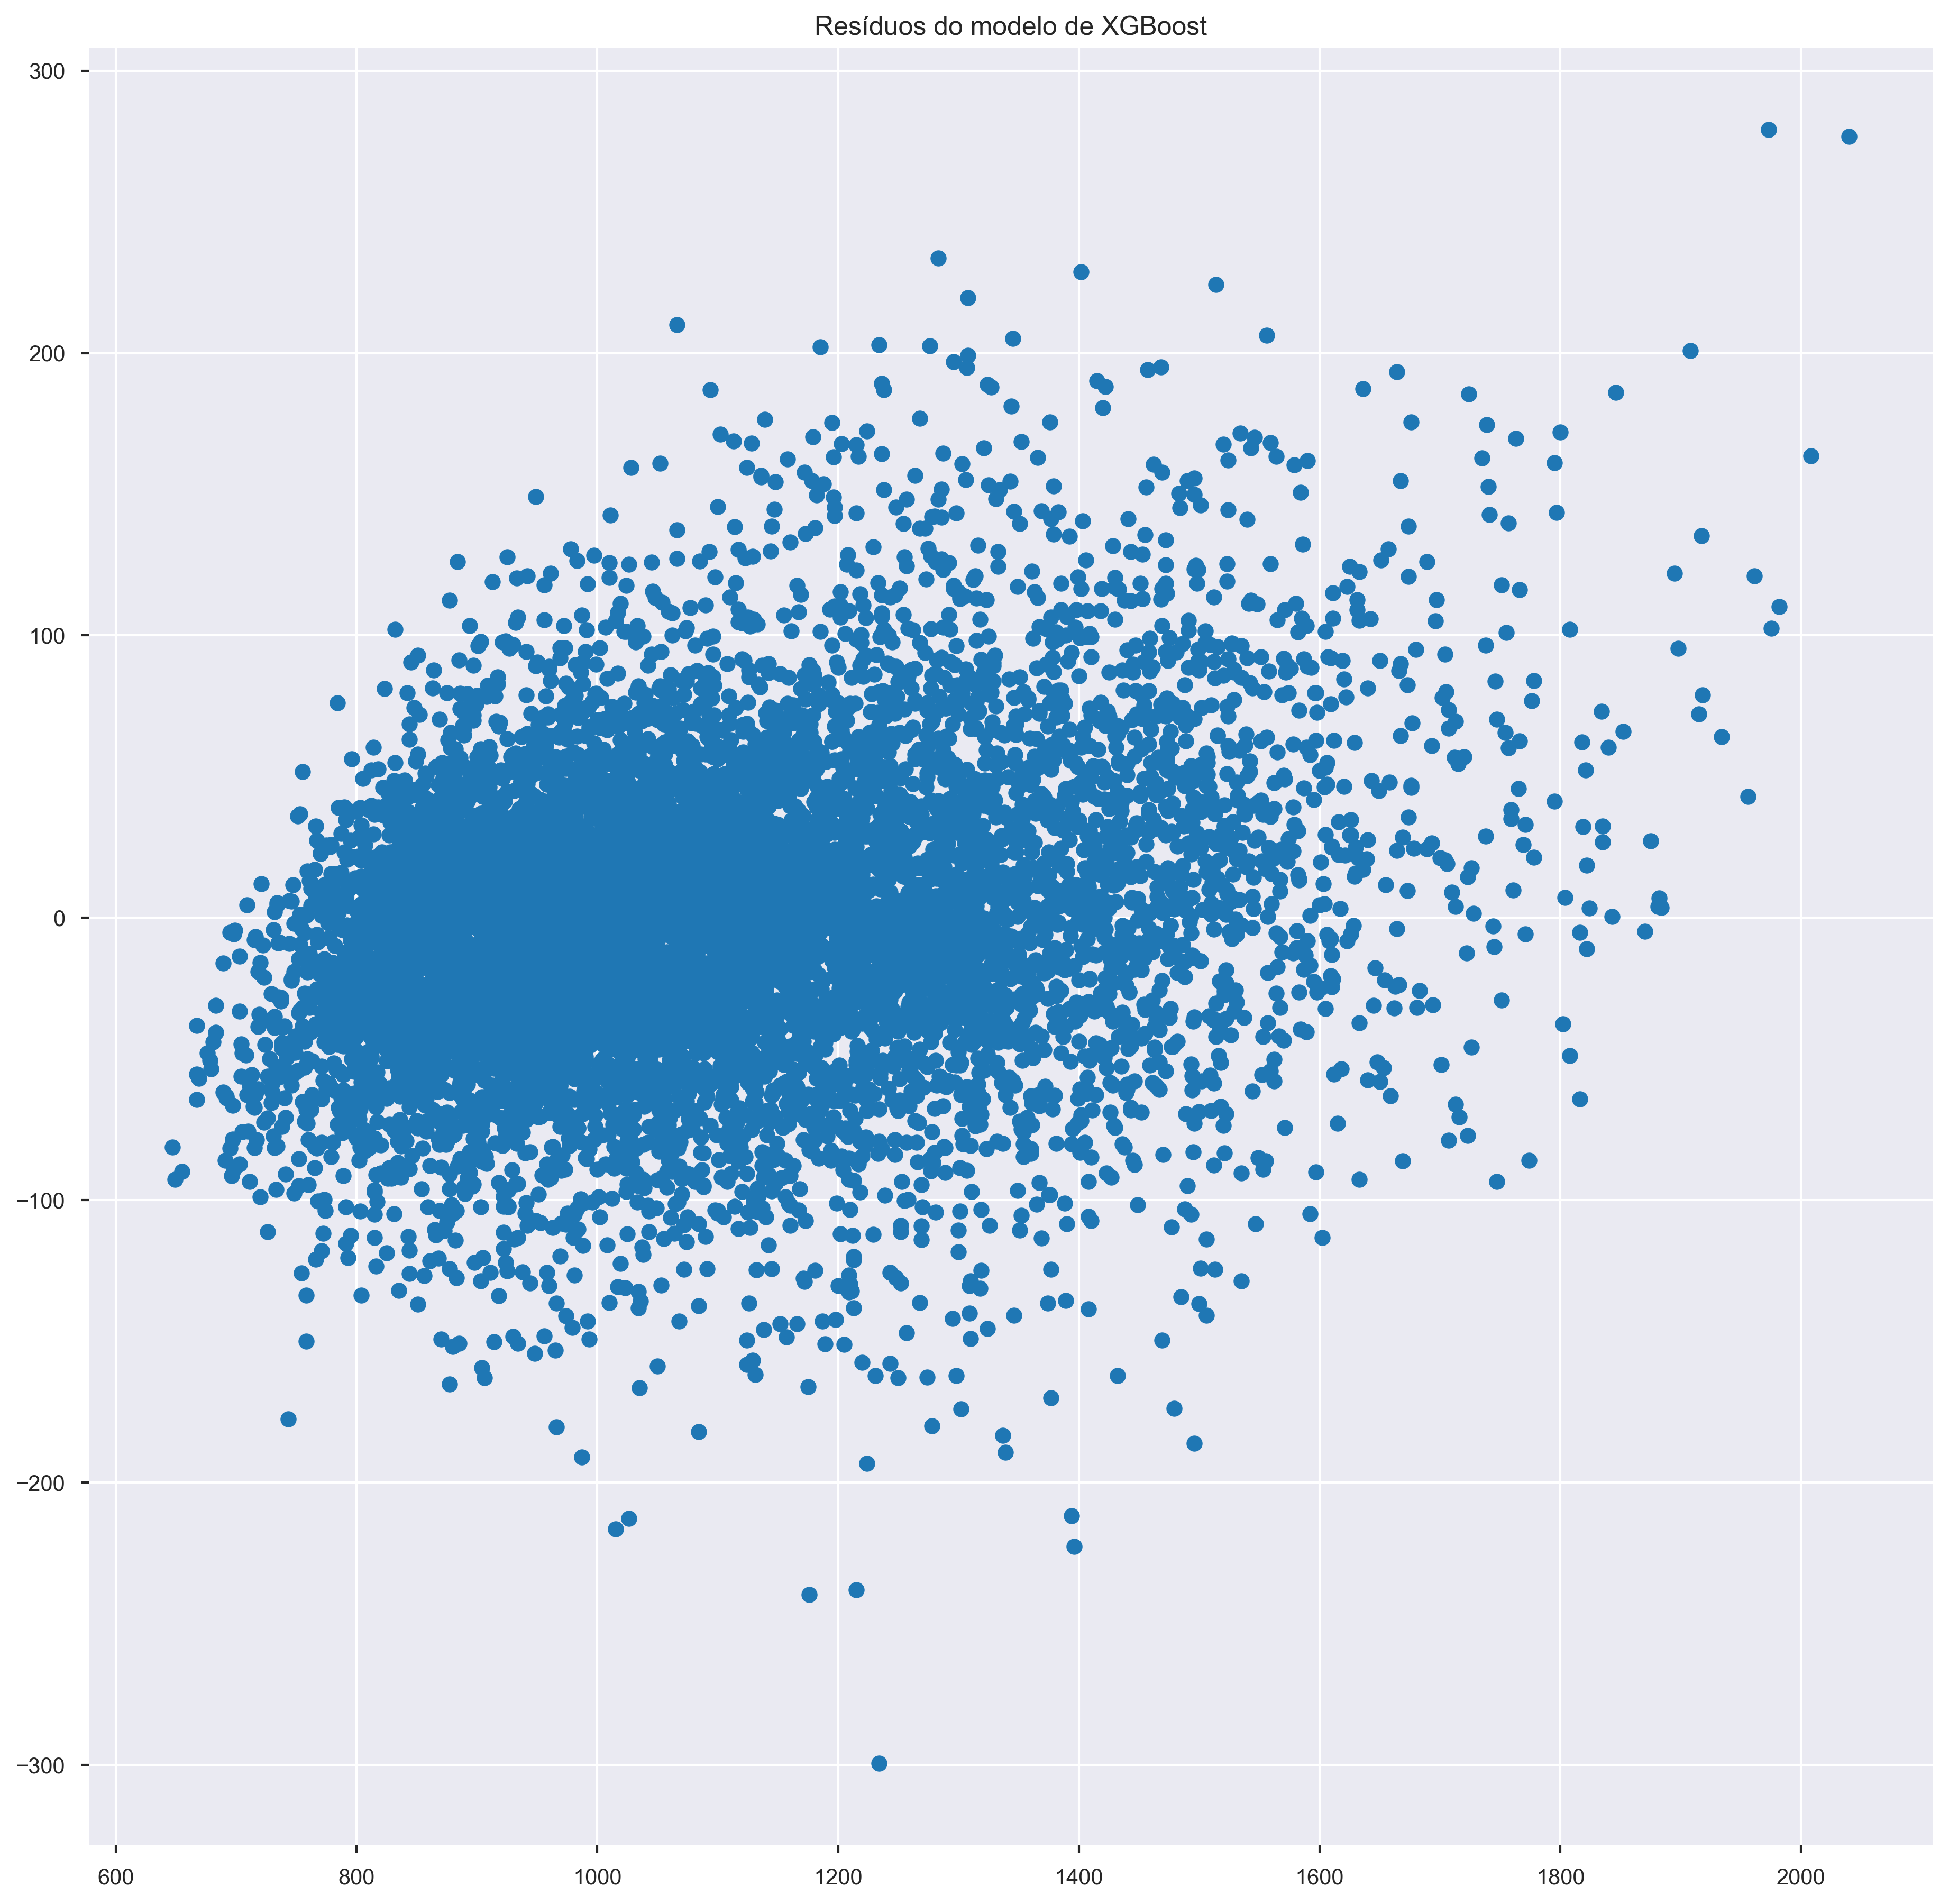

In [132]:
plt.figure(figsize=(15, 15))
plt.title('Resíduos do modelo de XGBoost')
plt.scatter(y_test_all, np.asarray(y_test_all) - np.asarray(y_pred_all))
plt.grid(True)
plt.show()

Finalmente, a distribuição dos resíduos é aleatória e tende a ser gaussiana, portanto o modelo não está simples demais.

### Escolha do modelo

Vamos comparar as métricas de performance dos 3 modelos:

| Modelo | RMSE | $R^2$ | Resíduo aleatório?   |
|------|------|------|------|
| **Regressão linear** | 70.05|   0.896  | Sim |
| **Random forest** | 55.85|   0.934  | Sim |
| **XGBoost** | 53.00|   0.940  | Sim |

**Escolhemos o modelo de XGBoost**, pois foi o que apresentou menor RMSE e também maior $R^2$.

## Perguntas finais

### Quais são os horários de pico às quartas-feiras?

In [133]:
air_quality_wednesday_df = air_quality_df[air_quality_df['wednesday'] == 1]

In [134]:
air_quality_wednesday_df.shape

(1251, 26)

In [135]:
air_quality_wednesday_df.head()

Date      Time  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
datetime                                                                     
2004-03-10 18:00:00  10/03/2004  18.00.00         1360       150      11.9   
2004-03-10 19:00:00  10/03/2004  19.00.00         1292       112       9.4   
2004-03-10 20:00:00  10/03/2004  20.00.00         1402        88       9.0   
2004-03-10 21:00:00  10/03/2004  21.00.00         1376        80       9.2   
2004-03-10 22:00:00  10/03/2004  22.00.00         1272        51       6.5   

                     PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  \
datetime                                                             
2004-03-10 18:00:00           1046      166          1056      113   
2004-03-10 19:00:00            955      103          1174       92   
2004-03-10 20:00:00            939      131          1140      114   
2004-03-10 21:00:00            948      172          1092      122   
2004-03-10 22:00:00            836      131          1205      116   

                     PT08.S4(NO2)  ...      cos_hour    weekday  friday  \
datetime                           ...                                    
2004-03-10 18:00:00          1692  ... -1.836970e-16  wednesday       0   
2004-03-10 19:00:00          1559  ...  2.588190e-01  wednesday       0   
2004-03-10 20:00:00          1555  ...  5.000000e-01  wednesday       0   
2004-03-10 21:00:00          1584  ...  7.071068e-01  wednesday       0   
2004-03-10 22:00:00          1490  ...  8.660254e-01  wednesday       0   

                     monday  saturday  sunday  thursday tuesday  wednesday  \
datetime                                                                     
2004-03-10 18:00:00       0         0       0         0       0          1   
2004-03-10 19:00:00       0         0       0         0       0          1   
2004-03-10 20:00:00       0         0       0         0       0          1   
2004-03-10 21:00:00       0         0       0         0       0          1   
2004-03-10 22:00:00       0         0       0         0       0          1   

                     k_means_cluster  
datetime                              
2004-03-10 18:00:00                0  
2004-03-10 19:00:00                0  
2004-03-10 20:00:00                0  
2004-03-10 21:00:00                0  
2004-03-10 22:00:00                0  

[5 rows x 26 columns]

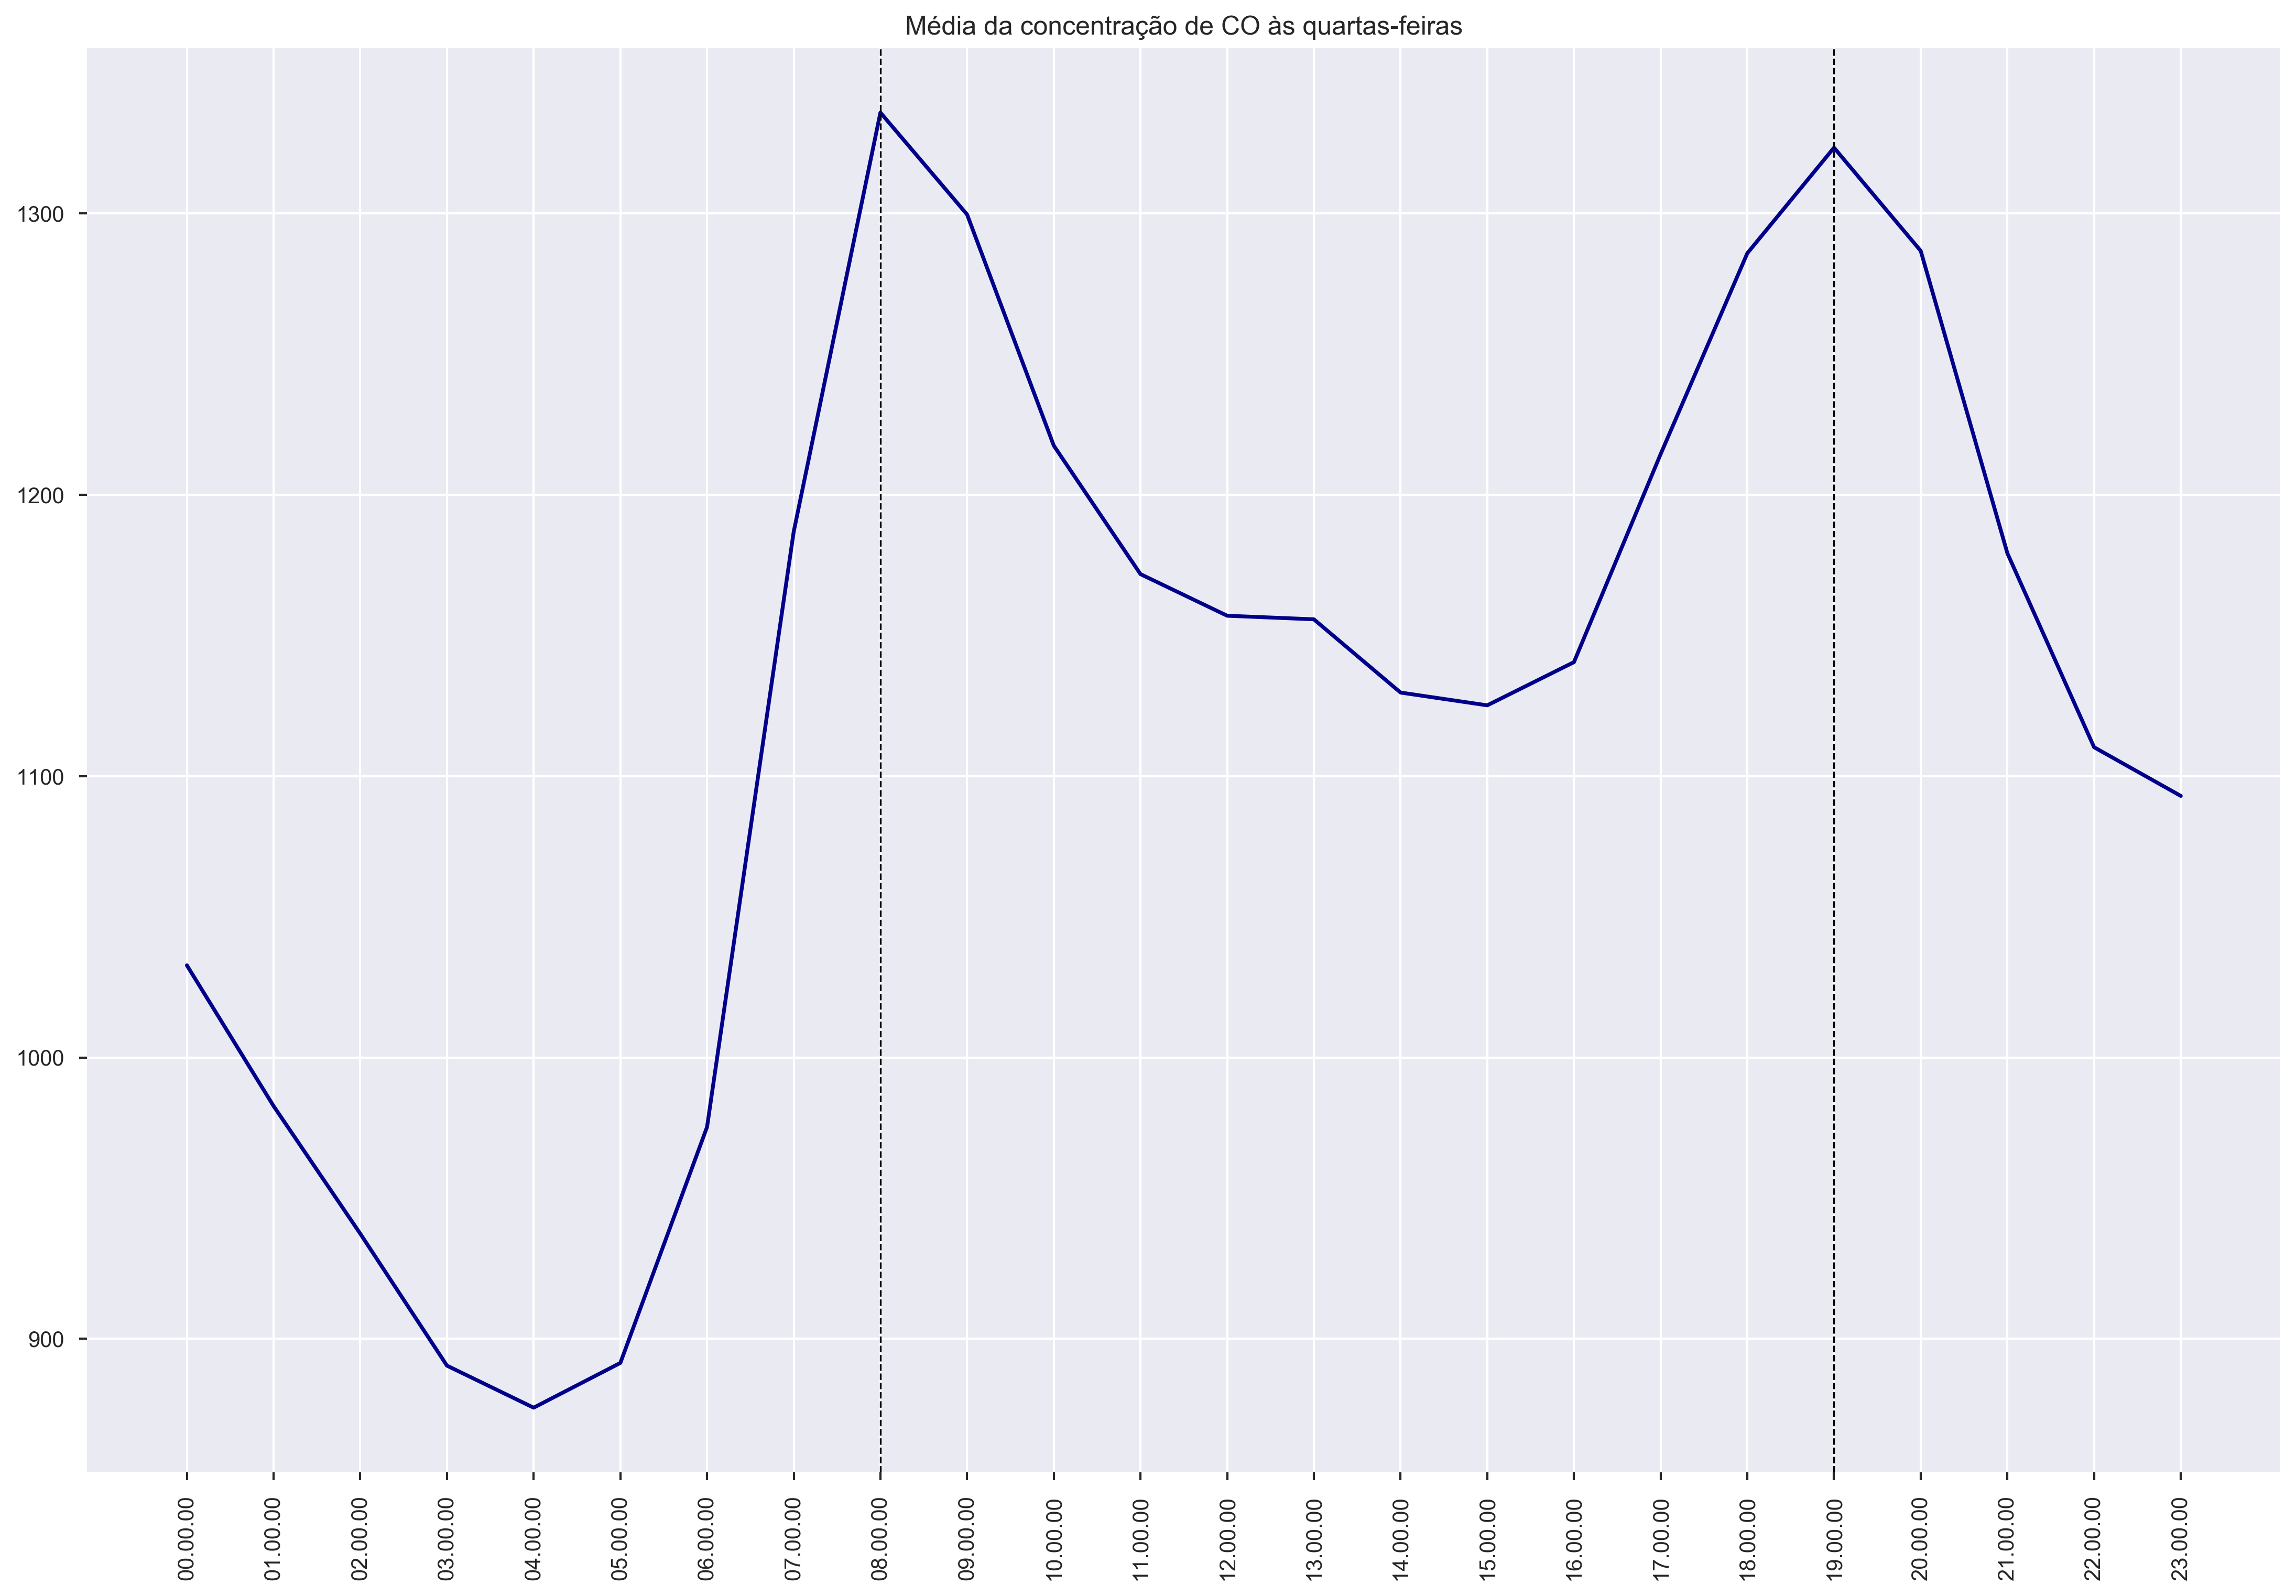

In [141]:
plt.figure(figsize=(18, 12))
plt.title('Média da concentração de CO às quartas-feiras')
sns.lineplot(data=air_quality_wednesday_df.groupby('Time').mean()['PT08.S1(CO)'], color='darkblue')
# plt.fill_between(
#     air_quality_wednesday_df.groupby('Time').mean().index, 
#     air_quality_wednesday_df.groupby('Time').mean()['PT08.S1(CO)'] - air_quality_wednesday_df.groupby('Time').std()['PT08.S1(CO)'], 
#     air_quality_wednesday_df.groupby('Time').mean()['PT08.S1(CO)'] + air_quality_wednesday_df.groupby('Time').std()['PT08.S1(CO)'], 
#     color='royalblue', 
#     alpha=0.3
# )
plt.axvline(x='08.00.00', color='k', linestyle='--', linewidth=0.8)
plt.axvline(x='19.00.00', color='k', linestyle='--', linewidth=0.8)
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

Pelo gráfico, podemos ver que os picos de concentração de monóxido de carbono (CO) ocorrem às `8h` e `19h` at às quartas-feiras, em média. Isso é coerente com a expectativa de que a poluição aumente em horários de pico do trânsito.

### Como as estações do ano influenciam as medições?

In [143]:
spring_months = [3, 4, 5]
summer_months = [6, 7, 8]
fall_months = [9, 10, 11]
winter_months = [12, 1, 2]

In [144]:
def set_season(month):
    '''
    Return season
    '''
    if month in spring_months:
        season = 'spring'
    elif month in summer_months:
        season = 'summer'
    elif month in fall_months:
        season = 'fall'
    else:
        season = 'winter'
    return season

In [145]:
air_quality_df['season'] = air_quality_df.index.map(lambda x: set_season(x.month))

In [146]:
air_quality_df['season'].value_counts()

spring    2763
fall      2165
summer    2120
winter    1943
Name: season, dtype: int64

In [147]:
air_quality_df.groupby('season').mean()

PT08.S1(CO)    NMHC(GT)   C6H6(GT)  PT08.S2(NMHC)     NOx(GT)  \
season                                                                  
fall    1133.854042 -200.000000  12.549238    1021.673903  184.164434   
spring  1139.848353  -65.615273   9.621535     922.809627  133.356135   
summer  1016.754245 -200.000000   9.416179     926.239623   62.290094   
winter  1095.669583 -200.000000   8.719249     884.535769  294.903757   

        PT08.S3(NOx)     NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)          T  ...  \
season                                                                  ...   
fall      761.621247   12.849423   1519.660970  1125.030485  19.502402  ...   
spring    894.058270   65.185306   1477.448426   998.509953  16.307854  ...   
summer    845.786321   44.540566   1648.479245   905.005660  28.377830  ...   
winter    823.295419  106.606794   1145.776119  1072.446217   8.879722  ...   

        sin_hour  cos_hour    friday    monday  saturday    sunday  thursday  \
season                                                                         
fall   -0.001308  0.001151  0.143649  0.144111  0.144111  0.144111  0.144111   
spring  0.000551 -0.000844  0.138979  0.144408  0.147666  0.147666  0.146218   
summer  0.005758 -0.001669  0.135849  0.143396  0.140566  0.135849  0.138679   
winter  0.008491 -0.006352  0.133299  0.148224  0.159547  0.159032  0.135872   

         tuesday  wednesday  k_means_cluster  
season                                        
fall    0.143649   0.136259         1.325173  
spring  0.137170   0.137894         1.456026  
summer  0.158491   0.147170         0.934906  
winter  0.128667   0.135358         2.166752  

[4 rows x 23 columns]

In [148]:
air_quality_df.groupby('season').describe()['PT08.S1(CO)']

count         mean         std    min     25%     50%      75%  \
season                                                                    
fall    2165.0  1133.854042  244.483518  647.0  943.00  1103.0  1303.00   
spring  2763.0  1139.848353  220.724731  715.0  973.00  1106.0  1284.00   
summer  2120.0  1016.754245  150.668360  708.0  903.75  1008.0  1105.25   
winter  1943.0  1095.669583  215.315949  691.0  928.00  1054.0  1222.50   

           max  
season          
fall    2008.0  
spring  2040.0  
summer  1626.0  
winter  1881.0

In [152]:
air_quality_df.groupby('season').describe()['PT08.S2(NMHC)']

count         mean         std    min    25%    50%      75%     max
season                                                                       
fall    2165.0  1021.673903  300.858726  397.0  790.0  988.0  1233.00  2214.0
spring  2763.0   922.809627  259.648750  387.0  718.0  902.0  1096.50  1776.0
summer  2120.0   926.239623  220.618345  437.0  762.0  905.0  1074.25  1713.0
winter  1943.0   884.535769  261.922671  383.0  685.0  849.0  1067.00  1983.0

In [149]:
air_quality_df.groupby('season').describe()['PT08.S5(O3)']

count         mean         std    min     25%     50%      75%  \
season                                                                    
fall    2165.0  1125.030485  409.597784  261.0  825.00  1082.0  1405.00   
spring  2763.0   998.509953  383.331576  221.0  716.50   954.0  1248.50   
summer  2120.0   905.005660  317.065978  334.0  674.75   851.0  1084.25   
winter  1943.0  1072.446217  446.476778  252.0  735.00  1009.0  1370.50   

           max  
season          
fall    2522.0  
spring  2359.0  
summer  2475.0  
winter  2523.0

Analisando as distribuições das concentrações de monóxido de carbono, hidrocarbonetos e ozônio de cada estação, não parece haver grandes diferenças entre elas.

___

Vamos checar os intervalos de 95% de confiança das concentrações de monóxido de carbono para cada estação:

In [425]:
spring_co_values = air_quality_df.groupby('season').get_group('spring')['PT08.S1(CO)'].sort_values().values
spring_co_values[math.floor(len(spring_co_values) * 0.05)], spring_co_values[math.ceil(len(spring_co_values) * 0.95)]

(835, 1537)

In [426]:
summer_co_values = air_quality_df.groupby('season').get_group('summer')['PT08.S1(CO)'].sort_values().values
summer_co_values[math.floor(len(summer_co_values) * 0.05)], summer_co_values[math.ceil(len(summer_co_values) * 0.95)]

(797, 1291)

In [427]:
fall_co_values = air_quality_df.groupby('season').get_group('fall')['PT08.S1(CO)'].sort_values().values
fall_co_values[math.floor(len(fall_co_values) * 0.05)], fall_co_values[math.ceil(len(fall_co_values) * 0.95)]

(795, 1570)

In [428]:
winter_co_values = air_quality_df.groupby('season').get_group('winter')['PT08.S1(CO)'].sort_values().values
winter_co_values[math.floor(len(winter_co_values) * 0.05)], winter_co_values[math.ceil(len(winter_co_values) * 0.95)]

(812, 1514)

Como há bastante intersecção entre os intervalos, não parece haver diferença estatisticamente significativa entre as concentrações de CO de cada estação. **Aparentemente, as estações do ano não influenciam nas medições e nem na variável de predição**.